`torchvision
models <https://pytorch.org/docs/stable/torchvision/models.html>`

**finetuning**, 

start with a pretrained model and update *all* of the model’s parameters for our new
task, in essence retraining the whole model. 

**feature extraction**,

start with a pretrained model and only update the final layer weights
from which we derive predictions. 

`<https://cs231n.github.io/transfer-learning/>`

`<https://ruder.io/transfer-learning/>`

both methods follow same steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the
   number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to
   update during training
-  Run the training step




# Use a diagonal True/False mask to set all the off-diagonal elements of the gradient matrix to 0
# So the weights on off-diagonal is not updated anymore

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.2.0
Torchvision Version:  0.4.0a0


Inputs
------

Here are all of the parameters to change for the run. We will use the
*hymenoptera_data* dataset which can be downloaded
`here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`__.
This dataset contains two classes, **bees** and **ants**, and is
structured such that we can use the
`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset, rather than writing our own custom dataset. Download the data
and set the ``data_dir`` input to the root directory of the dataset. The
``model_name`` input is the name of the model you wish to use and must
be selected from this list:

::

   [resnet, alexnet, vgg, squeezenet, densenet, inception]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs we want to run,
and ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting. If ``feature_extract = False``, the model is
finetuned and all model parameters are updated. If
``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.




In [2]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg" #"squeezenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 20

# Number of epochs to train for 
num_epochs = 5000

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

Helper Functions
----------------

Before we write the code for adjusting the models, lets define a few
helper functions.

Model Training and Validation Code
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model. The *is_inception* flag is used to accomodate the
*Inception v3* model, as that architecture uses an auxiliary output and
the overall model loss respects both the auxiliary output and the final
output, as described
`here <https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958>`__.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.




In [30]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    '''
    # =============== Grad Mask: 0===================
    shape0 = model.classifier[0].weight.shape[0]
    shape1 = model.classifier[0].weight.shape[1]
    gradMask0 = torch.zeros(size=model.classifier[0].weight.shape).cuda(device)
    for j in range(shape0):
        for k in range(shape1):
            if j == k % shape0:
                gradMask0[j][k] = 1            
    
    # =============== Grad Mask: 3===================
    shape0 = model.classifier[3].weight.shape[0]
    shape1 = model.classifier[3].weight.shape[1]
    gradMask3 = torch.zeros(size=model.classifier[3].weight.shape).cuda(device)
    for j in range(shape0):
        for k in range(shape1):
            if j == k % shape0:
                gradMask3[j][k] = 1            

    
    # =============== Grad Mask: 6===================
    shape0 = model.classifier[6].weight.shape[0]
    shape1 = model.classifier[6].weight.shape[1]
    gradMask6 = torch.zeros(size=model.classifier[6].weight.shape).cuda(device)
    for j in range(shape0):
        for k in range(shape1):
            if j == k % shape0:
                gradMask6[j][k] = 1            

    '''
                           
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # -----------------------
        if epoch % 50 == 0:
            plt.plot(val_acc_history)
            plt.show()
            
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        
                        """
                        Set small FC weights do not update
                        """
                        if epoch % 10 == 0:
                            # =============== Grad Mask: 0===================
                            shape0 = model.classifier[0].weight.shape[0]
                            shape1 = model.classifier[0].weight.shape[1]
                            threshold = torch.max(torch.abs(model.classifier[0].weight)) / 10 * 9
                            gradMask0 = (model.classifier[0].weight > threshold).type(torch.FloatTensor).cuda(device)
                            
                            # =============== Grad Mask: 3===================
                            shape0 = model.classifier[3].weight.shape[0]
                            shape1 = model.classifier[3].weight.shape[1]
                            threshold = torch.max(torch.abs(model.classifier[3].weight)) / 10 * 9
                            gradMask3 = (model.classifier[3].weight > threshold).type(torch.FloatTensor).cuda(device)

                            # =============== Grad Mask: 6===================
                            shape0 = model.classifier[6].weight.shape[0]
                            shape1 = model.classifier[6].weight.shape[1]
                            threshold = torch.max(torch.abs(model.classifier[6].weight)) / 10 * 9
                            gradMask6 = (model.classifier[6].weight > threshold).type(torch.FloatTensor).cuda(device)

                            model.classifier[0].weight.grad = gradMask0
                            model.classifier[3].weight.grad = gradMask3
                            model.classifier[6].weight.grad = gradMask6
                        # ========================================================
                        
                        # print("Let's see shape", model.classfier[6].shape)
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Set Model Parameters’ .requires_grad attribute
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




In [31]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            # print("let's set param grad to false", param.shape)
            param.requires_grad = False

Initialize and Reshape the Networks
-----------------------------------

Now to the most interesting part. Here is where we handle the reshaping
of each network. Note, this is not an automatic procedure and is unique
to each model. Recall, the final layer of a CNN model, which is often
times an FC layer, has the same number of nodes as the number of output
classes in the dataset. Since all of the models have been pretrained on
Imagenet, they all have output layers of size 1000, one node for each
class. The goal here is to reshape the last layer to have the same
number of inputs as before, AND to have the same number of outputs as
the number of classes in the dataset. In the following sections we will
discuss how to alter the architecture of each model individually. But
first, there is one important detail regarding the difference between
finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the
last layer, or in other words, we only want to update the parameters for
the layer(s) we are reshaping. Therefore, we do not need to compute the
gradients of the parameters that we are not changing, so for efficiency
we set the .requires_grad attribute to False. This is important because
by default, this attribute is set to True. Then, when we initialize the
new layer and by default the new parameters have ``.requires_grad=True``
so only the new layer’s parameters will be updated. When we are
finetuning we can leave all of the .required_grad’s set to the default
of True.

Finally, notice that inception_v3 requires the input size to be
(299,299), whereas all of the other models expect (224,224).

Resnet
~~~~~~

Resnet was introduced in the paper `Deep Residual Learning for Image
Recognition <https://arxiv.org/abs/1512.03385>`__. There are several
variants of different sizes, including Resnet18, Resnet34, Resnet50,
Resnet101, and Resnet152, all of which are available from torchvision
models. Here we use Resnet18, as our dataset is small and only has two
classes. When we print the model, we see that the last layer is a fully
connected layer as shown below:

::

   (fc): Linear(in_features=512, out_features=1000, bias=True) 

Thus, we must reinitialize ``model.fc`` to be a Linear layer with 512
input features and 2 output features with:

::

   model.fc = nn.Linear(512, num_classes)

Alexnet
~~~~~~~

Alexnet was introduced in the paper `ImageNet Classification with Deep
Convolutional Neural
Networks <https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf>`__
and was the first very successful CNN on the ImageNet dataset. When we
print the model architecture, we see the model output comes from the 6th
layer of the classifier

::

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    ) 

To use the model with our dataset we reinitialize this layer as

::

   model.classifier[6] = nn.Linear(4096,num_classes)

VGG
~~~

VGG was introduced in the paper `Very Deep Convolutional Networks for
Large-Scale Image Recognition <https://arxiv.org/pdf/1409.1556.pdf>`__.
Torchvision offers eight versions of VGG with various lengths and some
that have batch normalizations layers. Here we use VGG-11 with batch
normalization. The output layer is similar to Alexnet, i.e.

::

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )

Therefore, we use the same technique to modify the output layer

::

   model.classifier[6] = nn.Linear(4096,num_classes)

Squeezenet
~~~~~~~~~~

The Squeeznet architecture is described in the paper `SqueezeNet:
AlexNet-level accuracy with 50x fewer parameters and <0.5MB model
size <https://arxiv.org/abs/1602.07360>`__ and uses a different output
structure than any of the other models shown here. Torchvision has two
versions of Squeezenet, we use version 1.0. The output comes from a 1x1
convolutional layer which is the 1st layer of the classifier:

::

   (classifier): Sequential(
       (0): Dropout(p=0.5)
       (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
       (2): ReLU(inplace)
       (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
    ) 

To modify the network, we reinitialize the Conv2d layer to have an
output feature map of depth 2 as

::

   model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

Densenet
~~~~~~~~

Densenet was introduced in the paper `Densely Connected Convolutional
Networks <https://arxiv.org/abs/1608.06993>`__. Torchvision has four
variants of Densenet but here we only use Densenet-121. The output layer
is a linear layer with 1024 input features:

::

   (classifier): Linear(in_features=1024, out_features=1000, bias=True) 

To reshape the network, we reinitialize the classifier’s linear layer as

::

   model.classifier = nn.Linear(1024, num_classes)

Inception v3
~~~~~~~~~~~~

Finally, Inception v3 was first described in `Rethinking the Inception
Architecture for Computer
Vision <https://arxiv.org/pdf/1512.00567v1.pdf>`__. This network is
unique because it has two output layers when training. The second output
is known as an auxiliary output and is contained in the AuxLogits part
of the network. The primary output is a linear layer at the end of the
network. Note, when testing we only consider the primary output. The
auxiliary output and primary output of the loaded model are printed as:

::

   (AuxLogits): InceptionAux(
       ...
       (fc): Linear(in_features=768, out_features=1000, bias=True)
    )
    ...
   (fc): Linear(in_features=2048, out_features=1000, bias=True)

To finetune this model we must reshape both layers. This is accomplished
with the following

::

   model.AuxLogits.fc = nn.Linear(768, num_classes)
   model.fc = nn.Linear(2048, num_classes)

Notice, many of the models have similar output structures, but each must
be handled slightly differently. Also, check out the printed model
architecture of the reshaped network and make sure the number of output
features is the same as the number of classes in the dataset.




In [32]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        print("Before change:", model_ft)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        # model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft.classifier = nn.Sequential(*[model_ft.classifier[0], nn.Linear(num_ftrs,num_classes)])
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg19(pretrained=use_pretrained)
        print("Before change:", model_ft)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[3].out_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        
        model_ft.classifier[0].weight.requires_grad = True
        model_ft.classifier[0].bias.requires_grad = True
        model_ft.classifier[3].weight.requires_grad = True
        model_ft.classifier[3].bias.requires_grad = True
        model_ft.classifier[6].weight.requires_grad = True
        model_ft.classifier[6].bias.requires_grad = True
        
        # print(model_ft.classifier[6].weight.grad)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated

print('After change:', model_ft)
for name,param in model_ft.named_parameters():
    print("\t",name, param.requires_grad)


Before change: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stri

Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [33]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [34]:
device

device(type='cuda', index=1)

Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [35]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




Epoch 0/4999
----------


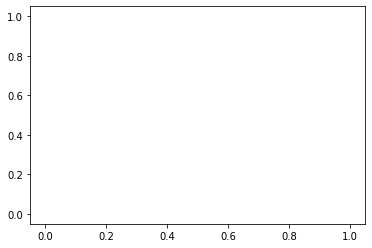

train Loss: 0.7589 Acc: 0.5164
val Loss: 0.7378 Acc: 0.4510

Epoch 1/4999
----------
train Loss: 0.3345 Acc: 0.8607
val Loss: 0.1437 Acc: 0.9477

Epoch 2/4999
----------
train Loss: 0.1661 Acc: 0.9385
val Loss: 0.1150 Acc: 0.9542

Epoch 3/4999
----------
train Loss: 0.0802 Acc: 0.9754
val Loss: 0.1102 Acc: 0.9542

Epoch 4/4999
----------
train Loss: 0.1283 Acc: 0.9590
val Loss: 0.1124 Acc: 0.9608

Epoch 5/4999
----------
train Loss: 0.0925 Acc: 0.9549
val Loss: 0.1130 Acc: 0.9608

Epoch 6/4999
----------
train Loss: 0.1088 Acc: 0.9508
val Loss: 0.1170 Acc: 0.9608

Epoch 7/4999
----------
train Loss: 0.1400 Acc: 0.9344
val Loss: 0.1156 Acc: 0.9542

Epoch 8/4999
----------
train Loss: 0.1154 Acc: 0.9549
val Loss: 0.1208 Acc: 0.9608

Epoch 9/4999
----------
train Loss: 0.0697 Acc: 0.9713
val Loss: 0.1172 Acc: 0.9608

Epoch 10/4999
----------
train Loss: 0.0601 Acc: 0.9672
val Loss: 0.1198 Acc: 0.9542

Epoch 11/4999
----------
train Loss: 0.1022 Acc: 0.9549
val Loss: 0.1140 Acc: 0.9608

Ep

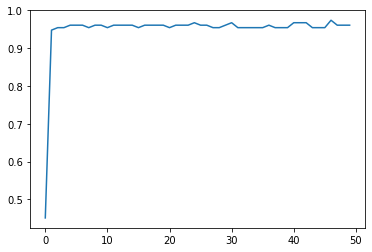

train Loss: 0.0465 Acc: 0.9795
val Loss: 0.1342 Acc: 0.9673

Epoch 51/4999
----------
train Loss: 0.0257 Acc: 0.9918
val Loss: 0.1256 Acc: 0.9542

Epoch 52/4999
----------
train Loss: 0.0333 Acc: 0.9836
val Loss: 0.1171 Acc: 0.9542

Epoch 53/4999
----------
train Loss: 0.0330 Acc: 0.9836
val Loss: 0.1135 Acc: 0.9608

Epoch 54/4999
----------
train Loss: 0.0498 Acc: 0.9959
val Loss: 0.1135 Acc: 0.9608

Epoch 55/4999
----------
train Loss: 0.0515 Acc: 0.9713
val Loss: 0.1097 Acc: 0.9542

Epoch 56/4999
----------
train Loss: 0.0448 Acc: 0.9959
val Loss: 0.1139 Acc: 0.9608

Epoch 57/4999
----------
train Loss: 0.0192 Acc: 0.9918
val Loss: 0.1136 Acc: 0.9542

Epoch 58/4999
----------
train Loss: 0.0449 Acc: 0.9836
val Loss: 0.1206 Acc: 0.9608

Epoch 59/4999
----------
train Loss: 0.0353 Acc: 0.9795
val Loss: 0.1152 Acc: 0.9608

Epoch 60/4999
----------
train Loss: 0.0225 Acc: 0.9836
val Loss: 0.1138 Acc: 0.9542

Epoch 61/4999
----------
train Loss: 0.0400 Acc: 0.9877
val Loss: 0.1201 Acc: 0

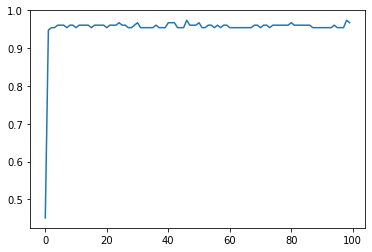

train Loss: 0.0478 Acc: 0.9836
val Loss: 0.1169 Acc: 0.9542

Epoch 101/4999
----------
train Loss: 0.0350 Acc: 0.9877
val Loss: 0.1252 Acc: 0.9542

Epoch 102/4999
----------
train Loss: 0.0434 Acc: 0.9795
val Loss: 0.1358 Acc: 0.9542

Epoch 103/4999
----------
train Loss: 0.0288 Acc: 0.9877
val Loss: 0.1417 Acc: 0.9542

Epoch 104/4999
----------
train Loss: 0.0495 Acc: 0.9836
val Loss: 0.1483 Acc: 0.9542

Epoch 105/4999
----------
train Loss: 0.0272 Acc: 0.9918
val Loss: 0.1503 Acc: 0.9542

Epoch 106/4999
----------
train Loss: 0.0543 Acc: 0.9754
val Loss: 0.1536 Acc: 0.9542

Epoch 107/4999
----------
train Loss: 0.0485 Acc: 0.9877
val Loss: 0.1482 Acc: 0.9542

Epoch 108/4999
----------
train Loss: 0.0290 Acc: 0.9836
val Loss: 0.1473 Acc: 0.9542

Epoch 109/4999
----------
train Loss: 0.0313 Acc: 0.9877
val Loss: 0.1510 Acc: 0.9542

Epoch 110/4999
----------
train Loss: 0.0774 Acc: 0.9754
val Loss: 0.1491 Acc: 0.9542

Epoch 111/4999
----------
train Loss: 0.0470 Acc: 0.9795
val Loss: 0.

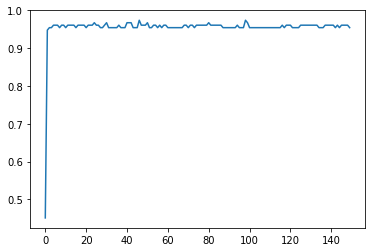

train Loss: 0.0342 Acc: 0.9795
val Loss: 0.1465 Acc: 0.9608

Epoch 151/4999
----------
train Loss: 0.0257 Acc: 0.9877
val Loss: 0.1537 Acc: 0.9608

Epoch 152/4999
----------
train Loss: 0.0118 Acc: 1.0000
val Loss: 0.1579 Acc: 0.9608

Epoch 153/4999
----------
train Loss: 0.0202 Acc: 0.9918
val Loss: 0.1608 Acc: 0.9608

Epoch 154/4999
----------
train Loss: 0.0181 Acc: 0.9918
val Loss: 0.1658 Acc: 0.9673

Epoch 155/4999
----------
train Loss: 0.0264 Acc: 0.9918
val Loss: 0.1652 Acc: 0.9608

Epoch 156/4999
----------
train Loss: 0.0570 Acc: 0.9754
val Loss: 0.1703 Acc: 0.9542

Epoch 157/4999
----------
train Loss: 0.0181 Acc: 0.9918
val Loss: 0.1616 Acc: 0.9542

Epoch 158/4999
----------
train Loss: 0.0275 Acc: 0.9918
val Loss: 0.1611 Acc: 0.9673

Epoch 159/4999
----------
train Loss: 0.0310 Acc: 0.9836
val Loss: 0.1591 Acc: 0.9673

Epoch 160/4999
----------
train Loss: 0.0707 Acc: 0.9795
val Loss: 0.1550 Acc: 0.9608

Epoch 161/4999
----------
train Loss: 0.0265 Acc: 0.9959
val Loss: 0.

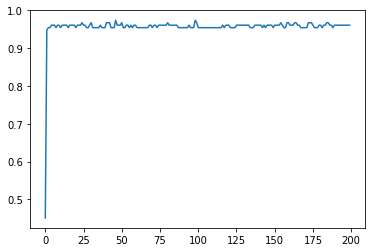

train Loss: 0.0260 Acc: 0.9877
val Loss: 0.1836 Acc: 0.9608

Epoch 201/4999
----------
train Loss: 0.0252 Acc: 0.9918
val Loss: 0.1829 Acc: 0.9608

Epoch 202/4999
----------
train Loss: 0.0200 Acc: 0.9918
val Loss: 0.1832 Acc: 0.9542

Epoch 203/4999
----------
train Loss: 0.0092 Acc: 1.0000
val Loss: 0.1861 Acc: 0.9608

Epoch 204/4999
----------
train Loss: 0.0306 Acc: 0.9918
val Loss: 0.1835 Acc: 0.9542

Epoch 205/4999
----------
train Loss: 0.0376 Acc: 0.9836
val Loss: 0.1794 Acc: 0.9608

Epoch 206/4999
----------
train Loss: 0.0565 Acc: 0.9795
val Loss: 0.1796 Acc: 0.9608

Epoch 207/4999
----------
train Loss: 0.0319 Acc: 0.9918
val Loss: 0.1774 Acc: 0.9608

Epoch 208/4999
----------
train Loss: 0.0518 Acc: 0.9672
val Loss: 0.1675 Acc: 0.9608

Epoch 209/4999
----------
train Loss: 0.0509 Acc: 0.9836
val Loss: 0.1588 Acc: 0.9608

Epoch 210/4999
----------
train Loss: 0.0255 Acc: 0.9877
val Loss: 0.1583 Acc: 0.9608

Epoch 211/4999
----------
train Loss: 0.0223 Acc: 0.9959
val Loss: 0.

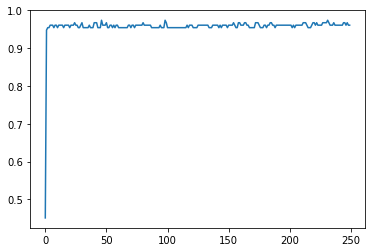

train Loss: 0.0471 Acc: 0.9795
val Loss: 0.1501 Acc: 0.9608

Epoch 251/4999
----------
train Loss: 0.0062 Acc: 1.0000
val Loss: 0.1509 Acc: 0.9608

Epoch 252/4999
----------
train Loss: 0.0182 Acc: 0.9959
val Loss: 0.1501 Acc: 0.9608

Epoch 253/4999
----------
train Loss: 0.0107 Acc: 1.0000
val Loss: 0.1525 Acc: 0.9608

Epoch 254/4999
----------
train Loss: 0.0163 Acc: 0.9918
val Loss: 0.1520 Acc: 0.9608

Epoch 255/4999
----------
train Loss: 0.0302 Acc: 0.9877
val Loss: 0.1519 Acc: 0.9608

Epoch 256/4999
----------
train Loss: 0.0136 Acc: 0.9959
val Loss: 0.1529 Acc: 0.9608

Epoch 257/4999
----------
train Loss: 0.0183 Acc: 0.9959
val Loss: 0.1560 Acc: 0.9608

Epoch 258/4999
----------
train Loss: 0.0203 Acc: 0.9877
val Loss: 0.1608 Acc: 0.9673

Epoch 259/4999
----------
train Loss: 0.0764 Acc: 0.9754
val Loss: 0.1567 Acc: 0.9673

Epoch 260/4999
----------
train Loss: 0.0224 Acc: 0.9918
val Loss: 0.1565 Acc: 0.9673

Epoch 261/4999
----------
train Loss: 0.0252 Acc: 0.9918
val Loss: 0.

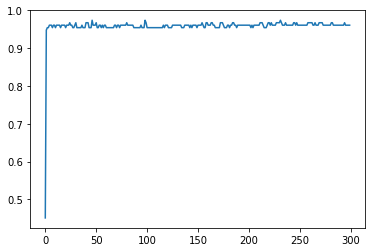

train Loss: 0.0211 Acc: 0.9959
val Loss: 0.1656 Acc: 0.9608

Epoch 301/4999
----------
train Loss: 0.0022 Acc: 1.0000
val Loss: 0.1663 Acc: 0.9608

Epoch 302/4999
----------
train Loss: 0.0064 Acc: 1.0000
val Loss: 0.1676 Acc: 0.9608

Epoch 303/4999
----------
train Loss: 0.0231 Acc: 0.9959
val Loss: 0.1738 Acc: 0.9608

Epoch 304/4999
----------
train Loss: 0.0067 Acc: 0.9959
val Loss: 0.1769 Acc: 0.9608

Epoch 305/4999
----------
train Loss: 0.0443 Acc: 0.9795
val Loss: 0.1778 Acc: 0.9608

Epoch 306/4999
----------
train Loss: 0.0240 Acc: 0.9918
val Loss: 0.1753 Acc: 0.9608

Epoch 307/4999
----------
train Loss: 0.0431 Acc: 0.9877
val Loss: 0.1829 Acc: 0.9608

Epoch 308/4999
----------
train Loss: 0.0496 Acc: 0.9754
val Loss: 0.1852 Acc: 0.9608

Epoch 309/4999
----------
train Loss: 0.0157 Acc: 0.9918
val Loss: 0.1826 Acc: 0.9477

Epoch 310/4999
----------
train Loss: 0.0345 Acc: 0.9836
val Loss: 0.1854 Acc: 0.9542

Epoch 311/4999
----------
train Loss: 0.0041 Acc: 1.0000
val Loss: 0.

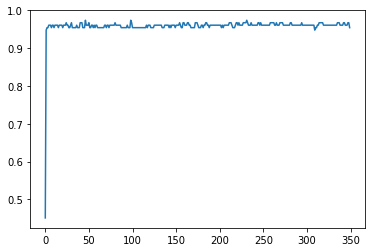

train Loss: 0.0405 Acc: 0.9795
val Loss: 0.1675 Acc: 0.9477

Epoch 351/4999
----------
train Loss: 0.0238 Acc: 0.9877
val Loss: 0.1641 Acc: 0.9608

Epoch 352/4999
----------
train Loss: 0.0254 Acc: 0.9836
val Loss: 0.1619 Acc: 0.9608

Epoch 353/4999
----------
train Loss: 0.0260 Acc: 0.9918
val Loss: 0.1622 Acc: 0.9608

Epoch 354/4999
----------
train Loss: 0.0263 Acc: 0.9918
val Loss: 0.1642 Acc: 0.9608

Epoch 355/4999
----------
train Loss: 0.0194 Acc: 0.9959
val Loss: 0.1691 Acc: 0.9608

Epoch 356/4999
----------
train Loss: 0.0292 Acc: 0.9918
val Loss: 0.1763 Acc: 0.9608

Epoch 357/4999
----------
train Loss: 0.0414 Acc: 0.9713
val Loss: 0.1820 Acc: 0.9608

Epoch 358/4999
----------
train Loss: 0.0079 Acc: 1.0000
val Loss: 0.2006 Acc: 0.9673

Epoch 359/4999
----------
train Loss: 0.0492 Acc: 0.9877
val Loss: 0.1815 Acc: 0.9608

Epoch 360/4999
----------
train Loss: 0.0133 Acc: 0.9959
val Loss: 0.1735 Acc: 0.9608

Epoch 361/4999
----------
train Loss: 0.0111 Acc: 1.0000
val Loss: 0.

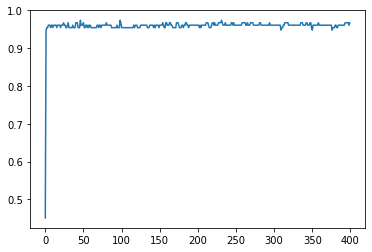

train Loss: 0.0311 Acc: 0.9918
val Loss: 0.1405 Acc: 0.9673

Epoch 401/4999
----------
train Loss: 0.0287 Acc: 0.9795
val Loss: 0.1422 Acc: 0.9673

Epoch 402/4999
----------
train Loss: 0.0177 Acc: 0.9918
val Loss: 0.1485 Acc: 0.9673

Epoch 403/4999
----------
train Loss: 0.0284 Acc: 0.9877
val Loss: 0.1893 Acc: 0.9608

Epoch 404/4999
----------
train Loss: 0.0463 Acc: 0.9877
val Loss: 0.1916 Acc: 0.9542

Epoch 405/4999
----------
train Loss: 0.0200 Acc: 0.9918
val Loss: 0.1841 Acc: 0.9608

Epoch 406/4999
----------
train Loss: 0.0288 Acc: 0.9836
val Loss: 0.1816 Acc: 0.9608

Epoch 407/4999
----------
train Loss: 0.0219 Acc: 0.9877
val Loss: 0.1810 Acc: 0.9608

Epoch 408/4999
----------
train Loss: 0.0164 Acc: 0.9877
val Loss: 0.1820 Acc: 0.9608

Epoch 409/4999
----------
train Loss: 0.0071 Acc: 1.0000
val Loss: 0.1838 Acc: 0.9608

Epoch 410/4999
----------
train Loss: 0.0064 Acc: 1.0000
val Loss: 0.1837 Acc: 0.9608

Epoch 411/4999
----------
train Loss: 0.0314 Acc: 0.9877
val Loss: 0.

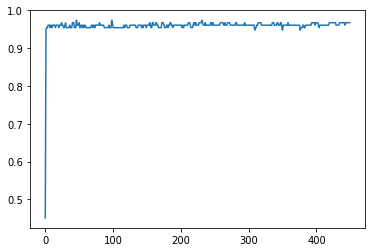

train Loss: 0.0309 Acc: 0.9918
val Loss: 0.1565 Acc: 0.9673

Epoch 451/4999
----------
train Loss: 0.0118 Acc: 0.9959
val Loss: 0.1588 Acc: 0.9673

Epoch 452/4999
----------
train Loss: 0.0105 Acc: 0.9959
val Loss: 0.1633 Acc: 0.9673

Epoch 453/4999
----------
train Loss: 0.0111 Acc: 0.9959
val Loss: 0.1630 Acc: 0.9673

Epoch 454/4999
----------
train Loss: 0.0325 Acc: 0.9836
val Loss: 0.1652 Acc: 0.9673

Epoch 455/4999
----------
train Loss: 0.0090 Acc: 0.9959
val Loss: 0.1665 Acc: 0.9673

Epoch 456/4999
----------
train Loss: 0.0119 Acc: 0.9959
val Loss: 0.1661 Acc: 0.9673

Epoch 457/4999
----------
train Loss: 0.0087 Acc: 0.9959
val Loss: 0.1686 Acc: 0.9673

Epoch 458/4999
----------
train Loss: 0.0144 Acc: 0.9959
val Loss: 0.1726 Acc: 0.9673

Epoch 459/4999
----------
train Loss: 0.0184 Acc: 0.9877
val Loss: 0.1744 Acc: 0.9673

Epoch 460/4999
----------
train Loss: 0.0396 Acc: 0.9754
val Loss: 0.1756 Acc: 0.9673

Epoch 461/4999
----------
train Loss: 0.0091 Acc: 0.9959
val Loss: 0.

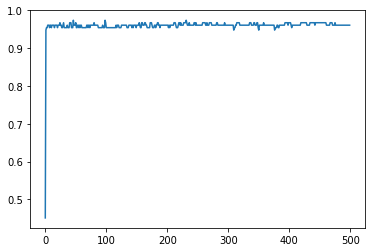

train Loss: 0.0072 Acc: 1.0000
val Loss: 0.1806 Acc: 0.9608

Epoch 501/4999
----------
train Loss: 0.0129 Acc: 0.9918
val Loss: 0.1817 Acc: 0.9608

Epoch 502/4999
----------
train Loss: 0.0218 Acc: 0.9877
val Loss: 0.1828 Acc: 0.9608

Epoch 503/4999
----------
train Loss: 0.0136 Acc: 0.9959
val Loss: 0.1835 Acc: 0.9608

Epoch 504/4999
----------
train Loss: 0.0086 Acc: 0.9918
val Loss: 0.1820 Acc: 0.9608

Epoch 505/4999
----------
train Loss: 0.0238 Acc: 0.9877
val Loss: 0.1770 Acc: 0.9608

Epoch 506/4999
----------
train Loss: 0.0136 Acc: 0.9959
val Loss: 0.1782 Acc: 0.9608

Epoch 507/4999
----------
train Loss: 0.0089 Acc: 0.9959
val Loss: 0.1809 Acc: 0.9608

Epoch 508/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.1817 Acc: 0.9608

Epoch 509/4999
----------
train Loss: 0.0124 Acc: 0.9959
val Loss: 0.1819 Acc: 0.9608

Epoch 510/4999
----------
train Loss: 0.0213 Acc: 0.9918
val Loss: 0.1816 Acc: 0.9608

Epoch 511/4999
----------
train Loss: 0.0530 Acc: 0.9836
val Loss: 0.

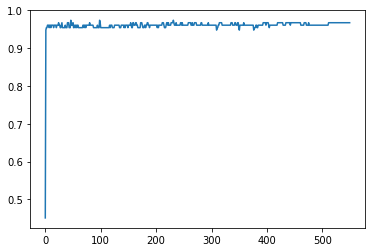

train Loss: 0.0358 Acc: 0.9918
val Loss: 0.1877 Acc: 0.9673

Epoch 551/4999
----------
train Loss: 0.0281 Acc: 0.9877
val Loss: 0.1912 Acc: 0.9673

Epoch 552/4999
----------
train Loss: 0.0374 Acc: 0.9918
val Loss: 0.1858 Acc: 0.9673

Epoch 553/4999
----------
train Loss: 0.0344 Acc: 0.9918
val Loss: 0.1820 Acc: 0.9673

Epoch 554/4999
----------
train Loss: 0.0143 Acc: 0.9959
val Loss: 0.1813 Acc: 0.9673

Epoch 555/4999
----------
train Loss: 0.0068 Acc: 1.0000
val Loss: 0.1808 Acc: 0.9673

Epoch 556/4999
----------
train Loss: 0.0188 Acc: 0.9918
val Loss: 0.1780 Acc: 0.9673

Epoch 557/4999
----------
train Loss: 0.0144 Acc: 0.9959
val Loss: 0.1732 Acc: 0.9673

Epoch 558/4999
----------
train Loss: 0.0044 Acc: 1.0000
val Loss: 0.1720 Acc: 0.9673

Epoch 559/4999
----------
train Loss: 0.0234 Acc: 0.9918
val Loss: 0.1674 Acc: 0.9673

Epoch 560/4999
----------
train Loss: 0.0457 Acc: 0.9713
val Loss: 0.1659 Acc: 0.9673

Epoch 561/4999
----------
train Loss: 0.0065 Acc: 0.9959
val Loss: 0.

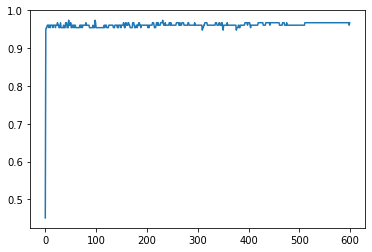

train Loss: 0.0136 Acc: 0.9918
val Loss: 0.1882 Acc: 0.9673

Epoch 601/4999
----------
train Loss: 0.0106 Acc: 0.9959
val Loss: 0.1884 Acc: 0.9673

Epoch 602/4999
----------
train Loss: 0.0195 Acc: 0.9959
val Loss: 0.1901 Acc: 0.9673

Epoch 603/4999
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.1898 Acc: 0.9673

Epoch 604/4999
----------
train Loss: 0.0080 Acc: 1.0000
val Loss: 0.1911 Acc: 0.9673

Epoch 605/4999
----------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.1928 Acc: 0.9673

Epoch 606/4999
----------
train Loss: 0.0188 Acc: 0.9918
val Loss: 0.1844 Acc: 0.9673

Epoch 607/4999
----------
train Loss: 0.0030 Acc: 1.0000
val Loss: 0.1818 Acc: 0.9673

Epoch 608/4999
----------
train Loss: 0.0408 Acc: 0.9836
val Loss: 0.1766 Acc: 0.9673

Epoch 609/4999
----------
train Loss: 0.0341 Acc: 0.9877
val Loss: 0.1821 Acc: 0.9673

Epoch 610/4999
----------
train Loss: 0.0053 Acc: 1.0000
val Loss: 0.1836 Acc: 0.9673

Epoch 611/4999
----------
train Loss: 0.0083 Acc: 0.9959
val Loss: 0.

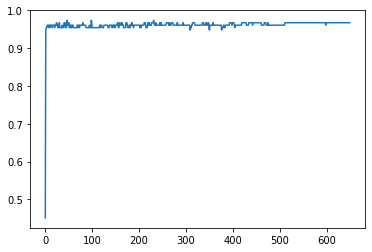

train Loss: 0.0191 Acc: 0.9918
val Loss: 0.1828 Acc: 0.9673

Epoch 651/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.1839 Acc: 0.9673

Epoch 652/4999
----------
train Loss: 0.0096 Acc: 1.0000
val Loss: 0.1841 Acc: 0.9673

Epoch 653/4999
----------
train Loss: 0.0077 Acc: 1.0000
val Loss: 0.1861 Acc: 0.9673

Epoch 654/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.1866 Acc: 0.9673

Epoch 655/4999
----------
train Loss: 0.0209 Acc: 0.9918
val Loss: 0.1828 Acc: 0.9673

Epoch 656/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.1761 Acc: 0.9673

Epoch 657/4999
----------
train Loss: 0.0212 Acc: 0.9877
val Loss: 0.1778 Acc: 0.9673

Epoch 658/4999
----------
train Loss: 0.0101 Acc: 0.9959
val Loss: 0.1794 Acc: 0.9673

Epoch 659/4999
----------
train Loss: 0.0080 Acc: 0.9959
val Loss: 0.1785 Acc: 0.9673

Epoch 660/4999
----------
train Loss: 0.0203 Acc: 0.9877
val Loss: 0.1711 Acc: 0.9673

Epoch 661/4999
----------
train Loss: 0.0078 Acc: 1.0000
val Loss: 0.

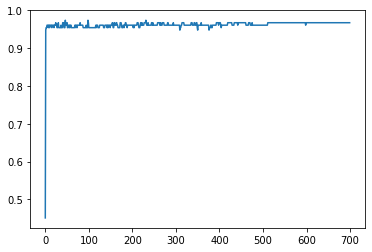

train Loss: 0.0126 Acc: 0.9959
val Loss: 0.2114 Acc: 0.9673

Epoch 701/4999
----------
train Loss: 0.0093 Acc: 0.9959
val Loss: 0.2134 Acc: 0.9673

Epoch 702/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.2175 Acc: 0.9673

Epoch 703/4999
----------
train Loss: 0.0057 Acc: 1.0000
val Loss: 0.2183 Acc: 0.9673

Epoch 704/4999
----------
train Loss: 0.0241 Acc: 0.9959
val Loss: 0.2231 Acc: 0.9673

Epoch 705/4999
----------
train Loss: 0.0233 Acc: 0.9918
val Loss: 0.2211 Acc: 0.9673

Epoch 706/4999
----------
train Loss: 0.0046 Acc: 1.0000
val Loss: 0.2210 Acc: 0.9673

Epoch 707/4999
----------
train Loss: 0.0141 Acc: 0.9918
val Loss: 0.2225 Acc: 0.9673

Epoch 708/4999
----------
train Loss: 0.0202 Acc: 0.9918
val Loss: 0.2161 Acc: 0.9673

Epoch 709/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.2154 Acc: 0.9673

Epoch 710/4999
----------
train Loss: 0.0077 Acc: 1.0000
val Loss: 0.2165 Acc: 0.9673

Epoch 711/4999
----------
train Loss: 0.0143 Acc: 0.9959
val Loss: 0.

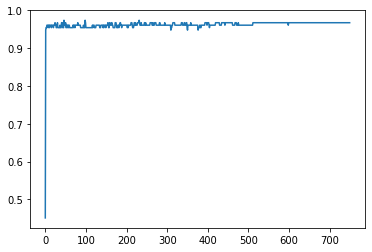

train Loss: 0.0054 Acc: 1.0000
val Loss: 0.2157 Acc: 0.9673

Epoch 751/4999
----------
train Loss: 0.0062 Acc: 1.0000
val Loss: 0.2152 Acc: 0.9673

Epoch 752/4999
----------
train Loss: 0.0080 Acc: 0.9959
val Loss: 0.2170 Acc: 0.9673

Epoch 753/4999
----------
train Loss: 0.0106 Acc: 0.9918
val Loss: 0.2183 Acc: 0.9673

Epoch 754/4999
----------
train Loss: 0.0041 Acc: 1.0000
val Loss: 0.2191 Acc: 0.9673

Epoch 755/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.2200 Acc: 0.9673

Epoch 756/4999
----------
train Loss: 0.0071 Acc: 0.9959
val Loss: 0.2191 Acc: 0.9673

Epoch 757/4999
----------
train Loss: 0.0124 Acc: 0.9959
val Loss: 0.2182 Acc: 0.9673

Epoch 758/4999
----------
train Loss: 0.0222 Acc: 0.9918
val Loss: 0.2206 Acc: 0.9673

Epoch 759/4999
----------
train Loss: 0.0128 Acc: 0.9959
val Loss: 0.2197 Acc: 0.9673

Epoch 760/4999
----------
train Loss: 0.0163 Acc: 0.9959
val Loss: 0.2173 Acc: 0.9673

Epoch 761/4999
----------
train Loss: 0.0308 Acc: 0.9918
val Loss: 0.

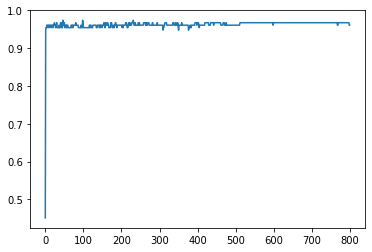

train Loss: 0.0014 Acc: 1.0000
val Loss: 0.2186 Acc: 0.9608

Epoch 801/4999
----------
train Loss: 0.0278 Acc: 0.9918
val Loss: 0.2166 Acc: 0.9608

Epoch 802/4999
----------
train Loss: 0.0132 Acc: 0.9959
val Loss: 0.2181 Acc: 0.9673

Epoch 803/4999
----------
train Loss: 0.0155 Acc: 0.9959
val Loss: 0.2218 Acc: 0.9673

Epoch 804/4999
----------
train Loss: 0.0175 Acc: 0.9918
val Loss: 0.2116 Acc: 0.9608

Epoch 805/4999
----------
train Loss: 0.0160 Acc: 0.9918
val Loss: 0.2058 Acc: 0.9608

Epoch 806/4999
----------
train Loss: 0.0064 Acc: 1.0000
val Loss: 0.1951 Acc: 0.9673

Epoch 807/4999
----------
train Loss: 0.0069 Acc: 1.0000
val Loss: 0.1892 Acc: 0.9673

Epoch 808/4999
----------
train Loss: 0.0041 Acc: 1.0000
val Loss: 0.1854 Acc: 0.9673

Epoch 809/4999
----------
train Loss: 0.0076 Acc: 0.9959
val Loss: 0.1793 Acc: 0.9608

Epoch 810/4999
----------
train Loss: 0.0082 Acc: 1.0000
val Loss: 0.1784 Acc: 0.9608

Epoch 811/4999
----------
train Loss: 0.0128 Acc: 0.9959
val Loss: 0.

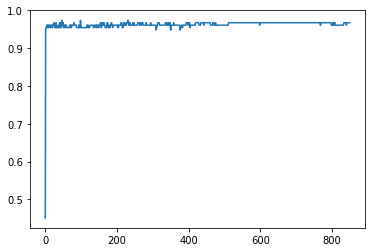

train Loss: 0.0027 Acc: 1.0000
val Loss: 0.2219 Acc: 0.9673

Epoch 851/4999
----------
train Loss: 0.0183 Acc: 0.9877
val Loss: 0.2247 Acc: 0.9673

Epoch 852/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.2287 Acc: 0.9673

Epoch 853/4999
----------
train Loss: 0.0092 Acc: 0.9959
val Loss: 0.2304 Acc: 0.9673

Epoch 854/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.2308 Acc: 0.9673

Epoch 855/4999
----------
train Loss: 0.0347 Acc: 0.9877
val Loss: 0.2308 Acc: 0.9673

Epoch 856/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.2298 Acc: 0.9608

Epoch 857/4999
----------
train Loss: 0.0144 Acc: 0.9918
val Loss: 0.2246 Acc: 0.9673

Epoch 858/4999
----------
train Loss: 0.0065 Acc: 1.0000
val Loss: 0.2241 Acc: 0.9673

Epoch 859/4999
----------
train Loss: 0.0159 Acc: 0.9918
val Loss: 0.2252 Acc: 0.9673

Epoch 860/4999
----------
train Loss: 0.0117 Acc: 0.9918
val Loss: 0.2241 Acc: 0.9608

Epoch 861/4999
----------
train Loss: 0.0136 Acc: 0.9959
val Loss: 0.

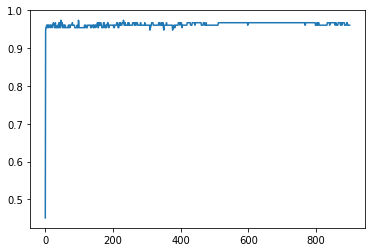

train Loss: 0.0017 Acc: 1.0000
val Loss: 0.2198 Acc: 0.9673

Epoch 901/4999
----------
train Loss: 0.0058 Acc: 1.0000
val Loss: 0.2207 Acc: 0.9673

Epoch 902/4999
----------
train Loss: 0.0027 Acc: 1.0000
val Loss: 0.2207 Acc: 0.9673

Epoch 903/4999
----------
train Loss: 0.0184 Acc: 0.9918
val Loss: 0.2220 Acc: 0.9673

Epoch 904/4999
----------
train Loss: 0.0203 Acc: 0.9877
val Loss: 0.2188 Acc: 0.9608

Epoch 905/4999
----------
train Loss: 0.0077 Acc: 0.9959
val Loss: 0.2127 Acc: 0.9673

Epoch 906/4999
----------
train Loss: 0.0049 Acc: 1.0000
val Loss: 0.2155 Acc: 0.9673

Epoch 907/4999
----------
train Loss: 0.0068 Acc: 1.0000
val Loss: 0.2276 Acc: 0.9673

Epoch 908/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.2319 Acc: 0.9673

Epoch 909/4999
----------
train Loss: 0.0083 Acc: 0.9959
val Loss: 0.2303 Acc: 0.9673

Epoch 910/4999
----------
train Loss: 0.0064 Acc: 1.0000
val Loss: 0.2295 Acc: 0.9673

Epoch 911/4999
----------
train Loss: 0.0243 Acc: 0.9959
val Loss: 0.

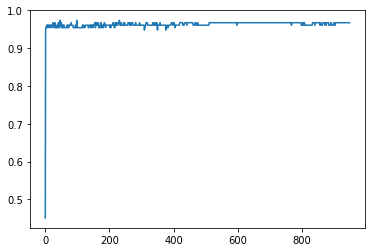

train Loss: 0.0087 Acc: 1.0000
val Loss: 0.2406 Acc: 0.9673

Epoch 951/4999
----------
train Loss: 0.0041 Acc: 1.0000
val Loss: 0.2412 Acc: 0.9673

Epoch 952/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.2400 Acc: 0.9673

Epoch 953/4999
----------
train Loss: 0.0050 Acc: 1.0000
val Loss: 0.2392 Acc: 0.9673

Epoch 954/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.2399 Acc: 0.9673

Epoch 955/4999
----------
train Loss: 0.0159 Acc: 0.9918
val Loss: 0.2342 Acc: 0.9673

Epoch 956/4999
----------
train Loss: 0.0139 Acc: 0.9918
val Loss: 0.2361 Acc: 0.9673

Epoch 957/4999
----------
train Loss: 0.0069 Acc: 0.9959
val Loss: 0.2434 Acc: 0.9673

Epoch 958/4999
----------
train Loss: 0.0036 Acc: 1.0000
val Loss: 0.2460 Acc: 0.9673

Epoch 959/4999
----------
train Loss: 0.0149 Acc: 0.9918
val Loss: 0.2362 Acc: 0.9673

Epoch 960/4999
----------
train Loss: 0.0125 Acc: 0.9918
val Loss: 0.2319 Acc: 0.9673

Epoch 961/4999
----------
train Loss: 0.0076 Acc: 0.9959
val Loss: 0.

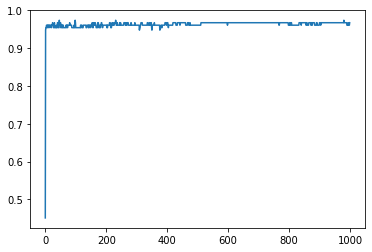

train Loss: 0.0046 Acc: 1.0000
val Loss: 0.2445 Acc: 0.9673

Epoch 1001/4999
----------
train Loss: 0.0185 Acc: 0.9918
val Loss: 0.2263 Acc: 0.9608

Epoch 1002/4999
----------
train Loss: 0.0035 Acc: 1.0000
val Loss: 0.2206 Acc: 0.9608

Epoch 1003/4999
----------
train Loss: 0.0079 Acc: 0.9918
val Loss: 0.2198 Acc: 0.9673

Epoch 1004/4999
----------
train Loss: 0.0126 Acc: 0.9959
val Loss: 0.2200 Acc: 0.9608

Epoch 1005/4999
----------
train Loss: 0.0097 Acc: 0.9959
val Loss: 0.2177 Acc: 0.9608

Epoch 1006/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.2178 Acc: 0.9608

Epoch 1007/4999
----------
train Loss: 0.0030 Acc: 1.0000
val Loss: 0.2193 Acc: 0.9608

Epoch 1008/4999
----------
train Loss: 0.0278 Acc: 0.9836
val Loss: 0.2166 Acc: 0.9673

Epoch 1009/4999
----------
train Loss: 0.0222 Acc: 0.9918
val Loss: 0.2185 Acc: 0.9673

Epoch 1010/4999
----------
train Loss: 0.0040 Acc: 1.0000
val Loss: 0.2199 Acc: 0.9673

Epoch 1011/4999
----------
train Loss: 0.0031 Acc: 1.0000
v

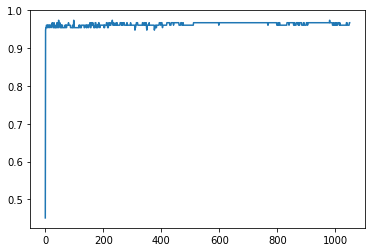

train Loss: 0.0070 Acc: 0.9959
val Loss: 0.2617 Acc: 0.9673

Epoch 1051/4999
----------
train Loss: 0.0053 Acc: 1.0000
val Loss: 0.2635 Acc: 0.9673

Epoch 1052/4999
----------
train Loss: 0.0068 Acc: 0.9959
val Loss: 0.2615 Acc: 0.9673

Epoch 1053/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.2579 Acc: 0.9673

Epoch 1054/4999
----------
train Loss: 0.0155 Acc: 0.9918
val Loss: 0.2573 Acc: 0.9673

Epoch 1055/4999
----------
train Loss: 0.0066 Acc: 1.0000
val Loss: 0.2573 Acc: 0.9673

Epoch 1056/4999
----------
train Loss: 0.0373 Acc: 0.9877
val Loss: 0.2553 Acc: 0.9673

Epoch 1057/4999
----------
train Loss: 0.0044 Acc: 1.0000
val Loss: 0.2479 Acc: 0.9673

Epoch 1058/4999
----------
train Loss: 0.0042 Acc: 1.0000
val Loss: 0.2452 Acc: 0.9673

Epoch 1059/4999
----------
train Loss: 0.0180 Acc: 0.9959
val Loss: 0.2474 Acc: 0.9673

Epoch 1060/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.2476 Acc: 0.9673

Epoch 1061/4999
----------
train Loss: 0.0315 Acc: 0.9836
v

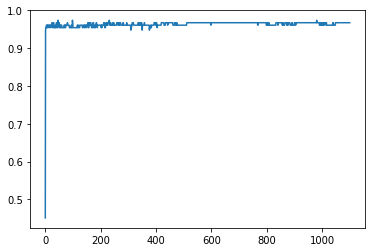

train Loss: 0.0060 Acc: 1.0000
val Loss: 0.2445 Acc: 0.9673

Epoch 1101/4999
----------
train Loss: 0.0118 Acc: 0.9959
val Loss: 0.2490 Acc: 0.9673

Epoch 1102/4999
----------
train Loss: 0.0308 Acc: 0.9918
val Loss: 0.2572 Acc: 0.9673

Epoch 1103/4999
----------
train Loss: 0.0105 Acc: 0.9959
val Loss: 0.2505 Acc: 0.9673

Epoch 1104/4999
----------
train Loss: 0.0253 Acc: 0.9918
val Loss: 0.2469 Acc: 0.9673

Epoch 1105/4999
----------
train Loss: 0.0052 Acc: 1.0000
val Loss: 0.2469 Acc: 0.9673

Epoch 1106/4999
----------
train Loss: 0.0214 Acc: 0.9918
val Loss: 0.2477 Acc: 0.9673

Epoch 1107/4999
----------
train Loss: 0.0281 Acc: 0.9877
val Loss: 0.2528 Acc: 0.9673

Epoch 1108/4999
----------
train Loss: 0.0055 Acc: 0.9959
val Loss: 0.2595 Acc: 0.9673

Epoch 1109/4999
----------
train Loss: 0.0081 Acc: 0.9959
val Loss: 0.2599 Acc: 0.9673

Epoch 1110/4999
----------
train Loss: 0.0185 Acc: 0.9959
val Loss: 0.2600 Acc: 0.9673

Epoch 1111/4999
----------
train Loss: 0.0057 Acc: 1.0000
v

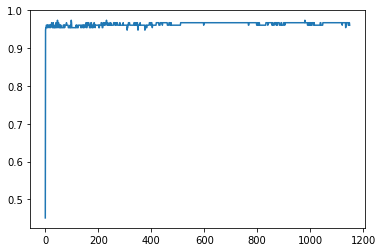

train Loss: 0.0067 Acc: 0.9959
val Loss: 0.2426 Acc: 0.9608

Epoch 1151/4999
----------
train Loss: 0.0203 Acc: 0.9918
val Loss: 0.2484 Acc: 0.9673

Epoch 1152/4999
----------
train Loss: 0.0088 Acc: 0.9959
val Loss: 0.2674 Acc: 0.9673

Epoch 1153/4999
----------
train Loss: 0.0054 Acc: 0.9959
val Loss: 0.2703 Acc: 0.9673

Epoch 1154/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.2711 Acc: 0.9673

Epoch 1155/4999
----------
train Loss: 0.0038 Acc: 1.0000
val Loss: 0.2698 Acc: 0.9673

Epoch 1156/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.2692 Acc: 0.9673

Epoch 1157/4999
----------
train Loss: 0.0066 Acc: 0.9959
val Loss: 0.2664 Acc: 0.9673

Epoch 1158/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.2665 Acc: 0.9673

Epoch 1159/4999
----------
train Loss: 0.0163 Acc: 0.9918
val Loss: 0.2660 Acc: 0.9673

Epoch 1160/4999
----------
train Loss: 0.0116 Acc: 0.9918
val Loss: 0.2654 Acc: 0.9673

Epoch 1161/4999
----------
train Loss: 0.0042 Acc: 1.0000
v

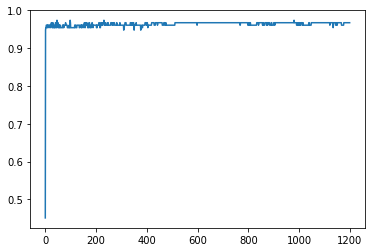

train Loss: 0.0247 Acc: 0.9918
val Loss: 0.2163 Acc: 0.9673

Epoch 1201/4999
----------
train Loss: 0.0054 Acc: 1.0000
val Loss: 0.2167 Acc: 0.9673

Epoch 1202/4999
----------
train Loss: 0.0152 Acc: 0.9918
val Loss: 0.2221 Acc: 0.9673

Epoch 1203/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.2282 Acc: 0.9673

Epoch 1204/4999
----------
train Loss: 0.0045 Acc: 1.0000
val Loss: 0.2300 Acc: 0.9673

Epoch 1205/4999
----------
train Loss: 0.0065 Acc: 1.0000
val Loss: 0.2327 Acc: 0.9673

Epoch 1206/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.2335 Acc: 0.9673

Epoch 1207/4999
----------
train Loss: 0.0076 Acc: 0.9959
val Loss: 0.2314 Acc: 0.9673

Epoch 1208/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.2298 Acc: 0.9673

Epoch 1209/4999
----------
train Loss: 0.0055 Acc: 1.0000
val Loss: 0.2308 Acc: 0.9673

Epoch 1210/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.2316 Acc: 0.9673

Epoch 1211/4999
----------
train Loss: 0.0043 Acc: 1.0000
v

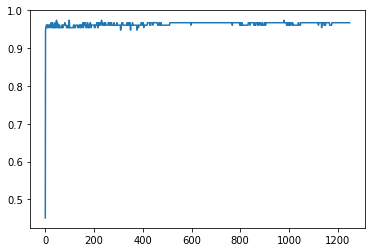

train Loss: 0.0015 Acc: 1.0000
val Loss: 0.2117 Acc: 0.9673

Epoch 1251/4999
----------
train Loss: 0.0148 Acc: 0.9959
val Loss: 0.2122 Acc: 0.9673

Epoch 1252/4999
----------
train Loss: 0.0035 Acc: 1.0000
val Loss: 0.2123 Acc: 0.9673

Epoch 1253/4999
----------
train Loss: 0.0120 Acc: 0.9918
val Loss: 0.2165 Acc: 0.9673

Epoch 1254/4999
----------
train Loss: 0.0038 Acc: 1.0000
val Loss: 0.2179 Acc: 0.9673

Epoch 1255/4999
----------
train Loss: 0.0176 Acc: 0.9877
val Loss: 0.2220 Acc: 0.9673

Epoch 1256/4999
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.2247 Acc: 0.9673

Epoch 1257/4999
----------
train Loss: 0.0267 Acc: 0.9918
val Loss: 0.2133 Acc: 0.9673

Epoch 1258/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.2113 Acc: 0.9673

Epoch 1259/4999
----------
train Loss: 0.0067 Acc: 0.9959
val Loss: 0.2102 Acc: 0.9673

Epoch 1260/4999
----------
train Loss: 0.0120 Acc: 0.9959
val Loss: 0.2096 Acc: 0.9673

Epoch 1261/4999
----------
train Loss: 0.0227 Acc: 0.9918
v

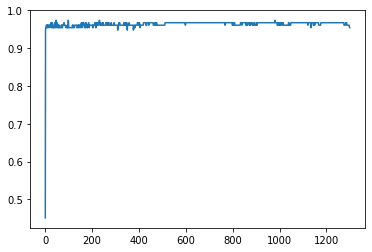

train Loss: 0.0189 Acc: 0.9959
val Loss: 0.2092 Acc: 0.9608

Epoch 1301/4999
----------
train Loss: 0.0188 Acc: 0.9877
val Loss: 0.2062 Acc: 0.9608

Epoch 1302/4999
----------
train Loss: 0.0049 Acc: 0.9959
val Loss: 0.2121 Acc: 0.9608

Epoch 1303/4999
----------
train Loss: 0.0045 Acc: 1.0000
val Loss: 0.2179 Acc: 0.9608

Epoch 1304/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.2199 Acc: 0.9608

Epoch 1305/4999
----------
train Loss: 0.0095 Acc: 0.9959
val Loss: 0.2293 Acc: 0.9608

Epoch 1306/4999
----------
train Loss: 0.0070 Acc: 1.0000
val Loss: 0.2361 Acc: 0.9542

Epoch 1307/4999
----------
train Loss: 0.0123 Acc: 0.9959
val Loss: 0.2409 Acc: 0.9542

Epoch 1308/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.2423 Acc: 0.9542

Epoch 1309/4999
----------
train Loss: 0.0069 Acc: 0.9959
val Loss: 0.2414 Acc: 0.9608

Epoch 1310/4999
----------
train Loss: 0.0123 Acc: 0.9918
val Loss: 0.2412 Acc: 0.9608

Epoch 1311/4999
----------
train Loss: 0.0064 Acc: 0.9959
v

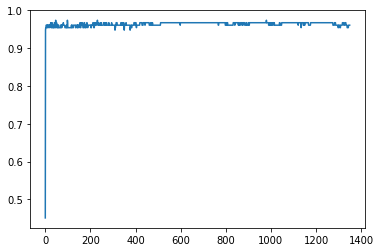

train Loss: 0.0277 Acc: 0.9877
val Loss: 0.2449 Acc: 0.9608

Epoch 1351/4999
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.2460 Acc: 0.9608

Epoch 1352/4999
----------
train Loss: 0.0058 Acc: 0.9959
val Loss: 0.2460 Acc: 0.9608

Epoch 1353/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.2465 Acc: 0.9608

Epoch 1354/4999
----------
train Loss: 0.0043 Acc: 1.0000
val Loss: 0.2500 Acc: 0.9608

Epoch 1355/4999
----------
train Loss: 0.0116 Acc: 0.9918
val Loss: 0.2613 Acc: 0.9608

Epoch 1356/4999
----------
train Loss: 0.0051 Acc: 1.0000
val Loss: 0.2674 Acc: 0.9608

Epoch 1357/4999
----------
train Loss: 0.0344 Acc: 0.9918
val Loss: 0.2668 Acc: 0.9608

Epoch 1358/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.2680 Acc: 0.9608

Epoch 1359/4999
----------
train Loss: 0.0081 Acc: 0.9959
val Loss: 0.2674 Acc: 0.9608

Epoch 1360/4999
----------
train Loss: 0.0108 Acc: 0.9918
val Loss: 0.2678 Acc: 0.9608

Epoch 1361/4999
----------
train Loss: 0.0030 Acc: 1.0000
v

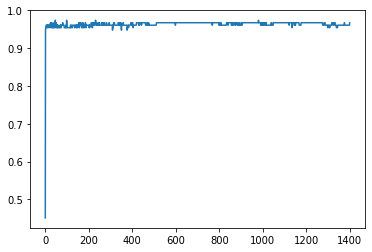

train Loss: 0.0107 Acc: 0.9959
val Loss: 0.3290 Acc: 0.9673

Epoch 1401/4999
----------
train Loss: 0.0228 Acc: 0.9959
val Loss: 0.3131 Acc: 0.9673

Epoch 1402/4999
----------
train Loss: 0.0061 Acc: 1.0000
val Loss: 0.3064 Acc: 0.9608

Epoch 1403/4999
----------
train Loss: 0.0235 Acc: 0.9877
val Loss: 0.3079 Acc: 0.9673

Epoch 1404/4999
----------
train Loss: 0.0075 Acc: 1.0000
val Loss: 0.3098 Acc: 0.9673

Epoch 1405/4999
----------
train Loss: 0.0069 Acc: 1.0000
val Loss: 0.3114 Acc: 0.9673

Epoch 1406/4999
----------
train Loss: 0.0143 Acc: 0.9918
val Loss: 0.3065 Acc: 0.9673

Epoch 1407/4999
----------
train Loss: 0.0071 Acc: 0.9959
val Loss: 0.3001 Acc: 0.9673

Epoch 1408/4999
----------
train Loss: 0.0096 Acc: 0.9918
val Loss: 0.2994 Acc: 0.9673

Epoch 1409/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.3010 Acc: 0.9673

Epoch 1410/4999
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.3017 Acc: 0.9673

Epoch 1411/4999
----------
train Loss: 0.0086 Acc: 0.9959
v

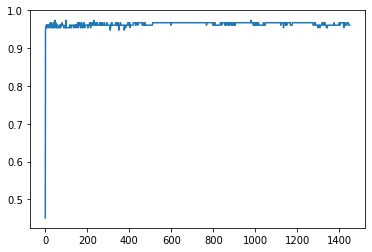

train Loss: 0.0088 Acc: 0.9918
val Loss: 0.3066 Acc: 0.9608

Epoch 1451/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.3064 Acc: 0.9608

Epoch 1452/4999
----------
train Loss: 0.0085 Acc: 0.9959
val Loss: 0.3062 Acc: 0.9608

Epoch 1453/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3076 Acc: 0.9608

Epoch 1454/4999
----------
train Loss: 0.0107 Acc: 0.9959
val Loss: 0.3053 Acc: 0.9608

Epoch 1455/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.3048 Acc: 0.9608

Epoch 1456/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.3049 Acc: 0.9608

Epoch 1457/4999
----------
train Loss: 0.0054 Acc: 0.9959
val Loss: 0.3023 Acc: 0.9608

Epoch 1458/4999
----------
train Loss: 0.0101 Acc: 0.9959
val Loss: 0.3029 Acc: 0.9608

Epoch 1459/4999
----------
train Loss: 0.0190 Acc: 0.9918
val Loss: 0.3140 Acc: 0.9673

Epoch 1460/4999
----------
train Loss: 0.0143 Acc: 0.9918
val Loss: 0.3173 Acc: 0.9673

Epoch 1461/4999
----------
train Loss: 0.0009 Acc: 1.0000
v

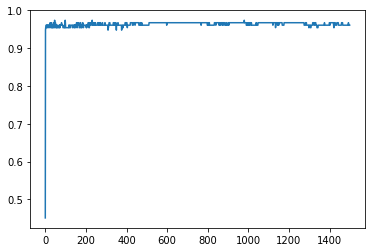

train Loss: 0.0035 Acc: 1.0000
val Loss: 0.2679 Acc: 0.9608

Epoch 1501/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.2682 Acc: 0.9608

Epoch 1502/4999
----------
train Loss: 0.0050 Acc: 1.0000
val Loss: 0.2647 Acc: 0.9608

Epoch 1503/4999
----------
train Loss: 0.0107 Acc: 0.9959
val Loss: 0.2638 Acc: 0.9608

Epoch 1504/4999
----------
train Loss: 0.0038 Acc: 1.0000
val Loss: 0.2902 Acc: 0.9542

Epoch 1505/4999
----------
train Loss: 0.0045 Acc: 1.0000
val Loss: 0.3003 Acc: 0.9542

Epoch 1506/4999
----------
train Loss: 0.0154 Acc: 0.9918
val Loss: 0.3023 Acc: 0.9542

Epoch 1507/4999
----------
train Loss: 0.0194 Acc: 0.9918
val Loss: 0.3078 Acc: 0.9542

Epoch 1508/4999
----------
train Loss: 0.0102 Acc: 0.9959
val Loss: 0.3075 Acc: 0.9542

Epoch 1509/4999
----------
train Loss: 0.0057 Acc: 0.9959
val Loss: 0.3049 Acc: 0.9542

Epoch 1510/4999
----------
train Loss: 0.0079 Acc: 0.9959
val Loss: 0.3029 Acc: 0.9542

Epoch 1511/4999
----------
train Loss: 0.0023 Acc: 1.0000
v

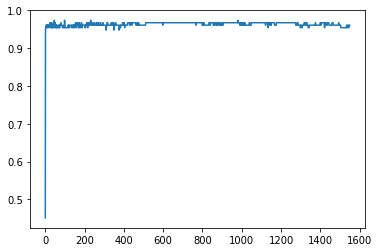

train Loss: 0.0156 Acc: 0.9918
val Loss: 0.2666 Acc: 0.9608

Epoch 1551/4999
----------
train Loss: 0.0084 Acc: 0.9959
val Loss: 0.2676 Acc: 0.9608

Epoch 1552/4999
----------
train Loss: 0.0102 Acc: 0.9918
val Loss: 0.2658 Acc: 0.9608

Epoch 1553/4999
----------
train Loss: 0.0157 Acc: 0.9877
val Loss: 0.2636 Acc: 0.9673

Epoch 1554/4999
----------
train Loss: 0.0152 Acc: 0.9959
val Loss: 0.2573 Acc: 0.9673

Epoch 1555/4999
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.2535 Acc: 0.9673

Epoch 1556/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.2529 Acc: 0.9673

Epoch 1557/4999
----------
train Loss: 0.0095 Acc: 0.9959
val Loss: 0.2536 Acc: 0.9673

Epoch 1558/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.2565 Acc: 0.9673

Epoch 1559/4999
----------
train Loss: 0.0049 Acc: 0.9959
val Loss: 0.2559 Acc: 0.9673

Epoch 1560/4999
----------
train Loss: 0.0053 Acc: 0.9959
val Loss: 0.2557 Acc: 0.9673

Epoch 1561/4999
----------
train Loss: 0.0088 Acc: 0.9959
v

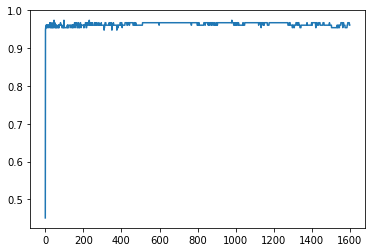

train Loss: 0.0050 Acc: 1.0000
val Loss: 0.2848 Acc: 0.9608

Epoch 1601/4999
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.2858 Acc: 0.9608

Epoch 1602/4999
----------
train Loss: 0.0154 Acc: 0.9918
val Loss: 0.2881 Acc: 0.9608

Epoch 1603/4999
----------
train Loss: 0.0027 Acc: 1.0000
val Loss: 0.2854 Acc: 0.9608

Epoch 1604/4999
----------
train Loss: 0.0128 Acc: 0.9959
val Loss: 0.2845 Acc: 0.9608

Epoch 1605/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.2835 Acc: 0.9608

Epoch 1606/4999
----------
train Loss: 0.0079 Acc: 0.9959
val Loss: 0.2850 Acc: 0.9608

Epoch 1607/4999
----------
train Loss: 0.0081 Acc: 0.9959
val Loss: 0.2819 Acc: 0.9608

Epoch 1608/4999
----------
train Loss: 0.0027 Acc: 1.0000
val Loss: 0.2815 Acc: 0.9608

Epoch 1609/4999
----------
train Loss: 0.0058 Acc: 0.9959
val Loss: 0.2823 Acc: 0.9608

Epoch 1610/4999
----------
train Loss: 0.0063 Acc: 1.0000
val Loss: 0.2824 Acc: 0.9608

Epoch 1611/4999
----------
train Loss: 0.0085 Acc: 0.9959
v

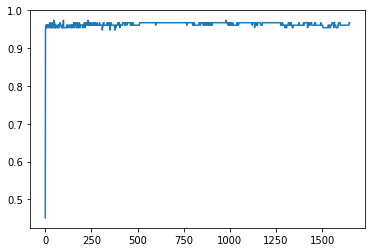

train Loss: 0.0053 Acc: 1.0000
val Loss: 0.2669 Acc: 0.9673

Epoch 1651/4999
----------
train Loss: 0.0077 Acc: 0.9959
val Loss: 0.2673 Acc: 0.9673

Epoch 1652/4999
----------
train Loss: 0.0110 Acc: 0.9918
val Loss: 0.2667 Acc: 0.9673

Epoch 1653/4999
----------
train Loss: 0.0268 Acc: 0.9959
val Loss: 0.2687 Acc: 0.9673

Epoch 1654/4999
----------
train Loss: 0.0069 Acc: 0.9959
val Loss: 0.2747 Acc: 0.9608

Epoch 1655/4999
----------
train Loss: 0.0063 Acc: 0.9959
val Loss: 0.2766 Acc: 0.9608

Epoch 1656/4999
----------
train Loss: 0.0099 Acc: 0.9959
val Loss: 0.2736 Acc: 0.9608

Epoch 1657/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.2737 Acc: 0.9608

Epoch 1658/4999
----------
train Loss: 0.0127 Acc: 0.9918
val Loss: 0.2742 Acc: 0.9608

Epoch 1659/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.2756 Acc: 0.9608

Epoch 1660/4999
----------
train Loss: 0.0113 Acc: 0.9959
val Loss: 0.2764 Acc: 0.9608

Epoch 1661/4999
----------
train Loss: 0.0064 Acc: 0.9959
v

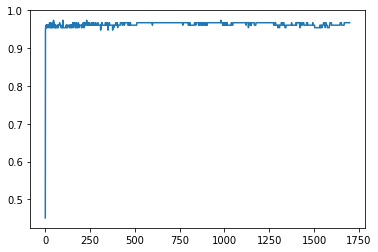

train Loss: 0.0085 Acc: 0.9959
val Loss: 0.2480 Acc: 0.9673

Epoch 1701/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.2476 Acc: 0.9673

Epoch 1702/4999
----------
train Loss: 0.0041 Acc: 0.9959
val Loss: 0.2462 Acc: 0.9673

Epoch 1703/4999
----------
train Loss: 0.0180 Acc: 0.9918
val Loss: 0.2441 Acc: 0.9673

Epoch 1704/4999
----------
train Loss: 0.0131 Acc: 0.9959
val Loss: 0.2387 Acc: 0.9673

Epoch 1705/4999
----------
train Loss: 0.0051 Acc: 0.9959
val Loss: 0.2380 Acc: 0.9673

Epoch 1706/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.2383 Acc: 0.9673

Epoch 1707/4999
----------
train Loss: 0.0079 Acc: 0.9959
val Loss: 0.2430 Acc: 0.9673

Epoch 1708/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.2458 Acc: 0.9673

Epoch 1709/4999
----------
train Loss: 0.0043 Acc: 1.0000
val Loss: 0.2463 Acc: 0.9673

Epoch 1710/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.2463 Acc: 0.9673

Epoch 1711/4999
----------
train Loss: 0.0027 Acc: 1.0000
v

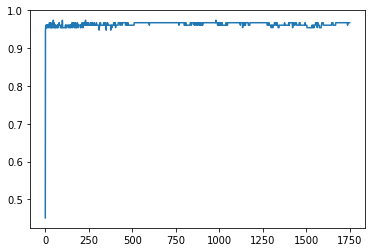

train Loss: 0.0011 Acc: 1.0000
val Loss: 0.2718 Acc: 0.9673

Epoch 1751/4999
----------
train Loss: 0.0071 Acc: 0.9959
val Loss: 0.2731 Acc: 0.9673

Epoch 1752/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.2748 Acc: 0.9608

Epoch 1753/4999
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.2755 Acc: 0.9608

Epoch 1754/4999
----------
train Loss: 0.0069 Acc: 1.0000
val Loss: 0.2769 Acc: 0.9608

Epoch 1755/4999
----------
train Loss: 0.0074 Acc: 1.0000
val Loss: 0.2761 Acc: 0.9673

Epoch 1756/4999
----------
train Loss: 0.0189 Acc: 0.9959
val Loss: 0.2772 Acc: 0.9673

Epoch 1757/4999
----------
train Loss: 0.0071 Acc: 0.9959
val Loss: 0.2793 Acc: 0.9673

Epoch 1758/4999
----------
train Loss: 0.0061 Acc: 1.0000
val Loss: 0.2817 Acc: 0.9673

Epoch 1759/4999
----------
train Loss: 0.0037 Acc: 1.0000
val Loss: 0.2848 Acc: 0.9673

Epoch 1760/4999
----------
train Loss: 0.0071 Acc: 0.9959
val Loss: 0.2852 Acc: 0.9673

Epoch 1761/4999
----------
train Loss: 0.0006 Acc: 1.0000
v

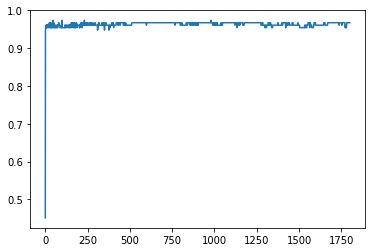

train Loss: 0.0075 Acc: 1.0000
val Loss: 0.2746 Acc: 0.9673

Epoch 1801/4999
----------
train Loss: 0.0065 Acc: 0.9959
val Loss: 0.2762 Acc: 0.9673

Epoch 1802/4999
----------
train Loss: 0.0123 Acc: 0.9959
val Loss: 0.2799 Acc: 0.9673

Epoch 1803/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.2768 Acc: 0.9673

Epoch 1804/4999
----------
train Loss: 0.0092 Acc: 0.9959
val Loss: 0.2767 Acc: 0.9673

Epoch 1805/4999
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.2753 Acc: 0.9673

Epoch 1806/4999
----------
train Loss: 0.0039 Acc: 1.0000
val Loss: 0.2733 Acc: 0.9673

Epoch 1807/4999
----------
train Loss: 0.0112 Acc: 0.9918
val Loss: 0.2839 Acc: 0.9739

Epoch 1808/4999
----------
train Loss: 0.0051 Acc: 1.0000
val Loss: 0.2866 Acc: 0.9739

Epoch 1809/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.2867 Acc: 0.9673

Epoch 1810/4999
----------
train Loss: 0.0129 Acc: 0.9918
val Loss: 0.2861 Acc: 0.9673

Epoch 1811/4999
----------
train Loss: 0.0069 Acc: 1.0000
v

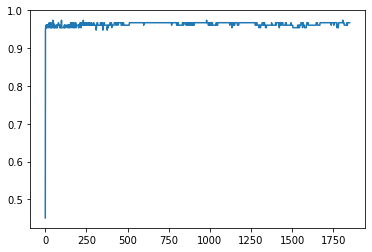

train Loss: 0.0074 Acc: 0.9959
val Loss: 0.2307 Acc: 0.9673

Epoch 1851/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.2310 Acc: 0.9673

Epoch 1852/4999
----------
train Loss: 0.0040 Acc: 1.0000
val Loss: 0.2324 Acc: 0.9673

Epoch 1853/4999
----------
train Loss: 0.0073 Acc: 1.0000
val Loss: 0.2344 Acc: 0.9608

Epoch 1854/4999
----------
train Loss: 0.0111 Acc: 0.9959
val Loss: 0.2410 Acc: 0.9673

Epoch 1855/4999
----------
train Loss: 0.0108 Acc: 0.9959
val Loss: 0.2544 Acc: 0.9673

Epoch 1856/4999
----------
train Loss: 0.0069 Acc: 0.9959
val Loss: 0.2582 Acc: 0.9739

Epoch 1857/4999
----------
train Loss: 0.0127 Acc: 0.9959
val Loss: 0.2491 Acc: 0.9673

Epoch 1858/4999
----------
train Loss: 0.0035 Acc: 1.0000
val Loss: 0.2485 Acc: 0.9673

Epoch 1859/4999
----------
train Loss: 0.0049 Acc: 1.0000
val Loss: 0.2507 Acc: 0.9673

Epoch 1860/4999
----------
train Loss: 0.0036 Acc: 1.0000
val Loss: 0.2516 Acc: 0.9673

Epoch 1861/4999
----------
train Loss: 0.0318 Acc: 0.9959
v

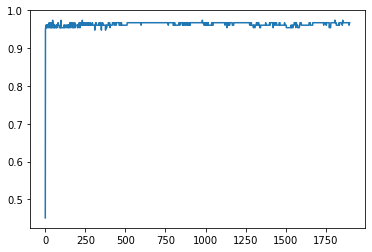

train Loss: 0.0243 Acc: 0.9918
val Loss: 0.2804 Acc: 0.9673

Epoch 1901/4999
----------
train Loss: 0.0137 Acc: 0.9959
val Loss: 0.2813 Acc: 0.9673

Epoch 1902/4999
----------
train Loss: 0.0046 Acc: 1.0000
val Loss: 0.2797 Acc: 0.9608

Epoch 1903/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.2767 Acc: 0.9542

Epoch 1904/4999
----------
train Loss: 0.0139 Acc: 0.9959
val Loss: 0.2767 Acc: 0.9542

Epoch 1905/4999
----------
train Loss: 0.0102 Acc: 0.9959
val Loss: 0.2778 Acc: 0.9542

Epoch 1906/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.2786 Acc: 0.9608

Epoch 1907/4999
----------
train Loss: 0.0087 Acc: 1.0000
val Loss: 0.2741 Acc: 0.9608

Epoch 1908/4999
----------
train Loss: 0.0042 Acc: 1.0000
val Loss: 0.2701 Acc: 0.9608

Epoch 1909/4999
----------
train Loss: 0.0047 Acc: 1.0000
val Loss: 0.2677 Acc: 0.9608

Epoch 1910/4999
----------
train Loss: 0.0189 Acc: 0.9959
val Loss: 0.2668 Acc: 0.9673

Epoch 1911/4999
----------
train Loss: 0.0075 Acc: 1.0000
v

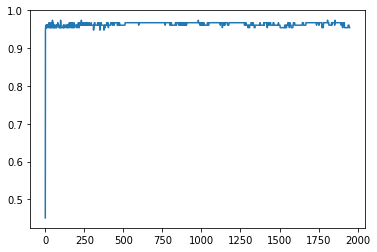

train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3064 Acc: 0.9542

Epoch 1951/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3066 Acc: 0.9542

Epoch 1952/4999
----------
train Loss: 0.0155 Acc: 0.9918
val Loss: 0.3051 Acc: 0.9542

Epoch 1953/4999
----------
train Loss: 0.0103 Acc: 0.9959
val Loss: 0.3015 Acc: 0.9542

Epoch 1954/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.2959 Acc: 0.9608

Epoch 1955/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.2961 Acc: 0.9608

Epoch 1956/4999
----------
train Loss: 0.0036 Acc: 1.0000
val Loss: 0.2974 Acc: 0.9608

Epoch 1957/4999
----------
train Loss: 0.0072 Acc: 0.9959
val Loss: 0.2999 Acc: 0.9608

Epoch 1958/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3010 Acc: 0.9608

Epoch 1959/4999
----------
train Loss: 0.0151 Acc: 0.9959
val Loss: 0.3067 Acc: 0.9608

Epoch 1960/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.3431 Acc: 0.9673

Epoch 1961/4999
----------
train Loss: 0.0115 Acc: 0.9959
v

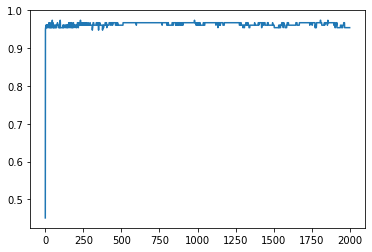

train Loss: 0.0191 Acc: 0.9877
val Loss: 0.2884 Acc: 0.9608

Epoch 2001/4999
----------
train Loss: 0.0075 Acc: 0.9959
val Loss: 0.2917 Acc: 0.9542

Epoch 2002/4999
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.2943 Acc: 0.9542

Epoch 2003/4999
----------
train Loss: 0.0149 Acc: 0.9918
val Loss: 0.2921 Acc: 0.9608

Epoch 2004/4999
----------
train Loss: 0.0148 Acc: 0.9918
val Loss: 0.2910 Acc: 0.9608

Epoch 2005/4999
----------
train Loss: 0.0134 Acc: 0.9959
val Loss: 0.2903 Acc: 0.9608

Epoch 2006/4999
----------
train Loss: 0.0058 Acc: 0.9959
val Loss: 0.2896 Acc: 0.9608

Epoch 2007/4999
----------
train Loss: 0.0215 Acc: 0.9877
val Loss: 0.2915 Acc: 0.9608

Epoch 2008/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.2921 Acc: 0.9673

Epoch 2009/4999
----------
train Loss: 0.0060 Acc: 0.9959
val Loss: 0.2924 Acc: 0.9673

Epoch 2010/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.2922 Acc: 0.9673

Epoch 2011/4999
----------
train Loss: 0.0128 Acc: 0.9918
v

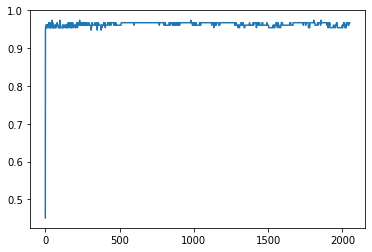

train Loss: 0.0019 Acc: 1.0000
val Loss: 0.2775 Acc: 0.9673

Epoch 2051/4999
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.2776 Acc: 0.9673

Epoch 2052/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.2782 Acc: 0.9673

Epoch 2053/4999
----------
train Loss: 0.0201 Acc: 0.9918
val Loss: 0.2711 Acc: 0.9673

Epoch 2054/4999
----------
train Loss: 0.0081 Acc: 0.9959
val Loss: 0.2661 Acc: 0.9673

Epoch 2055/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.2667 Acc: 0.9673

Epoch 2056/4999
----------
train Loss: 0.0039 Acc: 1.0000
val Loss: 0.2668 Acc: 0.9673

Epoch 2057/4999
----------
train Loss: 0.0076 Acc: 0.9959
val Loss: 0.2710 Acc: 0.9673

Epoch 2058/4999
----------
train Loss: 0.0038 Acc: 1.0000
val Loss: 0.2737 Acc: 0.9673

Epoch 2059/4999
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.2727 Acc: 0.9673

Epoch 2060/4999
----------
train Loss: 0.0067 Acc: 0.9959
val Loss: 0.2726 Acc: 0.9673

Epoch 2061/4999
----------
train Loss: 0.0120 Acc: 0.9918
v

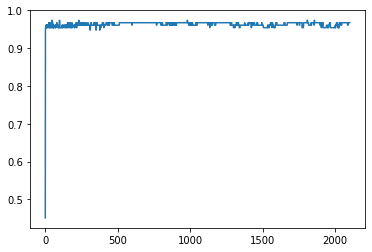

train Loss: 0.0076 Acc: 0.9959
val Loss: 0.2630 Acc: 0.9673

Epoch 2101/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.2640 Acc: 0.9673

Epoch 2102/4999
----------
train Loss: 0.0033 Acc: 0.9959
val Loss: 0.2644 Acc: 0.9673

Epoch 2103/4999
----------
train Loss: 0.0106 Acc: 1.0000
val Loss: 0.2634 Acc: 0.9673

Epoch 2104/4999
----------
train Loss: 0.0117 Acc: 0.9959
val Loss: 0.2714 Acc: 0.9673

Epoch 2105/4999
----------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.2749 Acc: 0.9673

Epoch 2106/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.2750 Acc: 0.9673

Epoch 2107/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.2740 Acc: 0.9673

Epoch 2108/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.2742 Acc: 0.9673

Epoch 2109/4999
----------
train Loss: 0.0054 Acc: 1.0000
val Loss: 0.2768 Acc: 0.9673

Epoch 2110/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.2793 Acc: 0.9673

Epoch 2111/4999
----------
train Loss: 0.0238 Acc: 0.9959
v

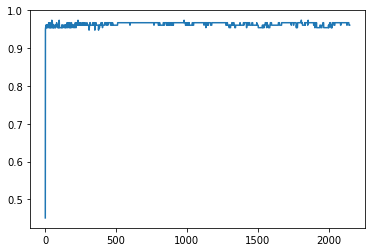

train Loss: 0.0153 Acc: 0.9918
val Loss: 0.2626 Acc: 0.9608

Epoch 2151/4999
----------
train Loss: 0.0072 Acc: 1.0000
val Loss: 0.2659 Acc: 0.9608

Epoch 2152/4999
----------
train Loss: 0.0045 Acc: 0.9959
val Loss: 0.2677 Acc: 0.9608

Epoch 2153/4999
----------
train Loss: 0.0131 Acc: 0.9959
val Loss: 0.2706 Acc: 0.9608

Epoch 2154/4999
----------
train Loss: 0.0046 Acc: 0.9959
val Loss: 0.2696 Acc: 0.9608

Epoch 2155/4999
----------
train Loss: 0.0030 Acc: 1.0000
val Loss: 0.2691 Acc: 0.9608

Epoch 2156/4999
----------
train Loss: 0.0035 Acc: 1.0000
val Loss: 0.2692 Acc: 0.9608

Epoch 2157/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.2710 Acc: 0.9608

Epoch 2158/4999
----------
train Loss: 0.0058 Acc: 0.9959
val Loss: 0.2748 Acc: 0.9608

Epoch 2159/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.2762 Acc: 0.9673

Epoch 2160/4999
----------
train Loss: 0.0041 Acc: 1.0000
val Loss: 0.2767 Acc: 0.9673

Epoch 2161/4999
----------
train Loss: 0.0011 Acc: 1.0000
v

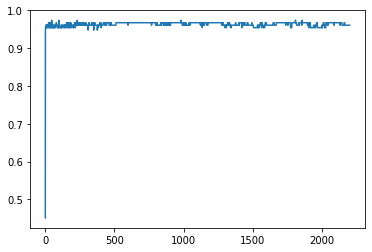

train Loss: 0.0182 Acc: 0.9959
val Loss: 0.2562 Acc: 0.9608

Epoch 2201/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.2578 Acc: 0.9608

Epoch 2202/4999
----------
train Loss: 0.0097 Acc: 0.9959
val Loss: 0.2590 Acc: 0.9608

Epoch 2203/4999
----------
train Loss: 0.0179 Acc: 0.9918
val Loss: 0.2617 Acc: 0.9608

Epoch 2204/4999
----------
train Loss: 0.0047 Acc: 1.0000
val Loss: 0.2640 Acc: 0.9608

Epoch 2205/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.2673 Acc: 0.9608

Epoch 2206/4999
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.2685 Acc: 0.9608

Epoch 2207/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.2696 Acc: 0.9608

Epoch 2208/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.2711 Acc: 0.9608

Epoch 2209/4999
----------
train Loss: 0.0049 Acc: 0.9959
val Loss: 0.2720 Acc: 0.9608

Epoch 2210/4999
----------
train Loss: 0.0068 Acc: 0.9959
val Loss: 0.2727 Acc: 0.9608

Epoch 2211/4999
----------
train Loss: 0.0050 Acc: 0.9959
v

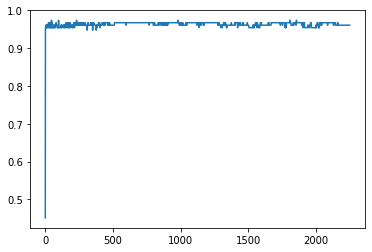

train Loss: 0.0056 Acc: 1.0000
val Loss: 0.2951 Acc: 0.9608

Epoch 2251/4999
----------
train Loss: 0.0384 Acc: 0.9959
val Loss: 0.2877 Acc: 0.9608

Epoch 2252/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.2839 Acc: 0.9608

Epoch 2253/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.2832 Acc: 0.9608

Epoch 2254/4999
----------
train Loss: 0.0045 Acc: 1.0000
val Loss: 0.2762 Acc: 0.9608

Epoch 2255/4999
----------
train Loss: 0.0048 Acc: 0.9959
val Loss: 0.2726 Acc: 0.9608

Epoch 2256/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.2718 Acc: 0.9608

Epoch 2257/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.2719 Acc: 0.9608

Epoch 2258/4999
----------
train Loss: 0.0132 Acc: 0.9918
val Loss: 0.2715 Acc: 0.9608

Epoch 2259/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.2713 Acc: 0.9608

Epoch 2260/4999
----------
train Loss: 0.0035 Acc: 1.0000
val Loss: 0.2713 Acc: 0.9608

Epoch 2261/4999
----------
train Loss: 0.0086 Acc: 0.9918
v

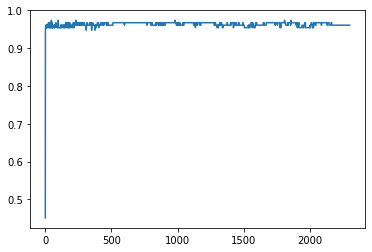

train Loss: 0.0007 Acc: 1.0000
val Loss: 0.3120 Acc: 0.9608

Epoch 2301/4999
----------
train Loss: 0.0063 Acc: 0.9959
val Loss: 0.3127 Acc: 0.9608

Epoch 2302/4999
----------
train Loss: 0.0030 Acc: 1.0000
val Loss: 0.3140 Acc: 0.9608

Epoch 2303/4999
----------
train Loss: 0.0070 Acc: 1.0000
val Loss: 0.3142 Acc: 0.9608

Epoch 2304/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3152 Acc: 0.9608

Epoch 2305/4999
----------
train Loss: 0.0051 Acc: 0.9959
val Loss: 0.3166 Acc: 0.9608

Epoch 2306/4999
----------
train Loss: 0.0054 Acc: 1.0000
val Loss: 0.3146 Acc: 0.9608

Epoch 2307/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.3125 Acc: 0.9608

Epoch 2308/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3117 Acc: 0.9608

Epoch 2309/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.3110 Acc: 0.9608

Epoch 2310/4999
----------
train Loss: 0.0057 Acc: 1.0000
val Loss: 0.3108 Acc: 0.9608

Epoch 2311/4999
----------
train Loss: 0.0034 Acc: 0.9959
v

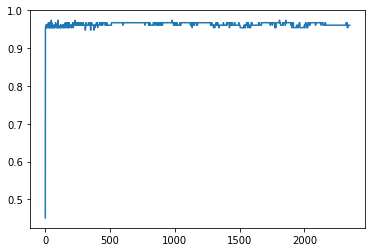

train Loss: 0.0023 Acc: 1.0000
val Loss: 0.2757 Acc: 0.9608

Epoch 2351/4999
----------
train Loss: 0.0056 Acc: 0.9959
val Loss: 0.2784 Acc: 0.9608

Epoch 2352/4999
----------
train Loss: 0.0036 Acc: 1.0000
val Loss: 0.2817 Acc: 0.9608

Epoch 2353/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.2840 Acc: 0.9608

Epoch 2354/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.2849 Acc: 0.9608

Epoch 2355/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.2850 Acc: 0.9608

Epoch 2356/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.2861 Acc: 0.9608

Epoch 2357/4999
----------
train Loss: 0.0045 Acc: 0.9959
val Loss: 0.2897 Acc: 0.9608

Epoch 2358/4999
----------
train Loss: 0.0065 Acc: 0.9959
val Loss: 0.2923 Acc: 0.9608

Epoch 2359/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.2939 Acc: 0.9608

Epoch 2360/4999
----------
train Loss: 0.0036 Acc: 1.0000
val Loss: 0.2946 Acc: 0.9608

Epoch 2361/4999
----------
train Loss: 0.0035 Acc: 1.0000
v

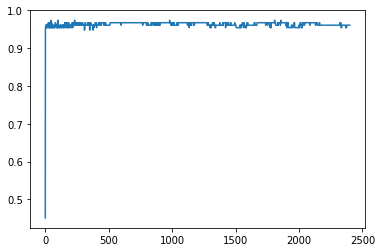

train Loss: 0.0030 Acc: 1.0000
val Loss: 0.3153 Acc: 0.9608

Epoch 2401/4999
----------
train Loss: 0.0038 Acc: 1.0000
val Loss: 0.3146 Acc: 0.9608

Epoch 2402/4999
----------
train Loss: 0.0058 Acc: 0.9959
val Loss: 0.3160 Acc: 0.9608

Epoch 2403/4999
----------
train Loss: 0.0131 Acc: 0.9918
val Loss: 0.3151 Acc: 0.9608

Epoch 2404/4999
----------
train Loss: 0.0057 Acc: 0.9959
val Loss: 0.3141 Acc: 0.9608

Epoch 2405/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3134 Acc: 0.9608

Epoch 2406/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3139 Acc: 0.9608

Epoch 2407/4999
----------
train Loss: 0.0341 Acc: 0.9918
val Loss: 0.3088 Acc: 0.9608

Epoch 2408/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3014 Acc: 0.9608

Epoch 2409/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3004 Acc: 0.9608

Epoch 2410/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3004 Acc: 0.9608

Epoch 2411/4999
----------
train Loss: 0.0018 Acc: 1.0000
v

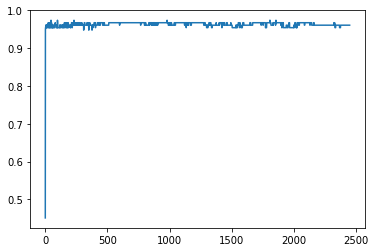

train Loss: 0.0038 Acc: 1.0000
val Loss: 0.2968 Acc: 0.9608

Epoch 2451/4999
----------
train Loss: 0.0071 Acc: 1.0000
val Loss: 0.2988 Acc: 0.9608

Epoch 2452/4999
----------
train Loss: 0.0042 Acc: 1.0000
val Loss: 0.2935 Acc: 0.9608

Epoch 2453/4999
----------
train Loss: 0.0180 Acc: 0.9959
val Loss: 0.2841 Acc: 0.9542

Epoch 2454/4999
----------
train Loss: 0.0041 Acc: 1.0000
val Loss: 0.2830 Acc: 0.9542

Epoch 2455/4999
----------
train Loss: 0.0060 Acc: 1.0000
val Loss: 0.2843 Acc: 0.9542

Epoch 2456/4999
----------
train Loss: 0.0056 Acc: 0.9959
val Loss: 0.2850 Acc: 0.9542

Epoch 2457/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.2848 Acc: 0.9542

Epoch 2458/4999
----------
train Loss: 0.0075 Acc: 0.9959
val Loss: 0.2868 Acc: 0.9542

Epoch 2459/4999
----------
train Loss: 0.0091 Acc: 0.9959
val Loss: 0.2878 Acc: 0.9608

Epoch 2460/4999
----------
train Loss: 0.0088 Acc: 0.9959
val Loss: 0.2845 Acc: 0.9608

Epoch 2461/4999
----------
train Loss: 0.0026 Acc: 1.0000
v

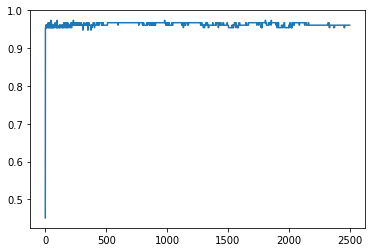

train Loss: 0.0019 Acc: 1.0000
val Loss: 0.2892 Acc: 0.9608

Epoch 2501/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.2894 Acc: 0.9608

Epoch 2502/4999
----------
train Loss: 0.0158 Acc: 0.9959
val Loss: 0.2907 Acc: 0.9608

Epoch 2503/4999
----------
train Loss: 0.0066 Acc: 0.9959
val Loss: 0.2911 Acc: 0.9608

Epoch 2504/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.2920 Acc: 0.9608

Epoch 2505/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.2926 Acc: 0.9608

Epoch 2506/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.2929 Acc: 0.9608

Epoch 2507/4999
----------
train Loss: 0.0069 Acc: 0.9959
val Loss: 0.2937 Acc: 0.9608

Epoch 2508/4999
----------
train Loss: 0.0056 Acc: 1.0000
val Loss: 0.2969 Acc: 0.9608

Epoch 2509/4999
----------
train Loss: 0.0105 Acc: 0.9959
val Loss: 0.2962 Acc: 0.9608

Epoch 2510/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.2941 Acc: 0.9608

Epoch 2511/4999
----------
train Loss: 0.0089 Acc: 0.9959
v

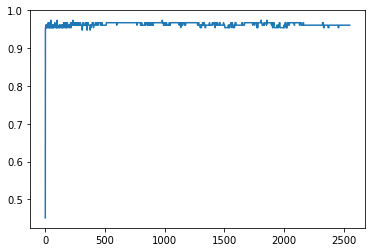

train Loss: 0.0060 Acc: 0.9959
val Loss: 0.3087 Acc: 0.9608

Epoch 2551/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3089 Acc: 0.9608

Epoch 2552/4999
----------
train Loss: 0.0073 Acc: 0.9959
val Loss: 0.3096 Acc: 0.9608

Epoch 2553/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3100 Acc: 0.9608

Epoch 2554/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3116 Acc: 0.9608

Epoch 2555/4999
----------
train Loss: 0.0066 Acc: 0.9959
val Loss: 0.3152 Acc: 0.9608

Epoch 2556/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3153 Acc: 0.9608

Epoch 2557/4999
----------
train Loss: 0.0039 Acc: 1.0000
val Loss: 0.3166 Acc: 0.9608

Epoch 2558/4999
----------
train Loss: 0.0036 Acc: 1.0000
val Loss: 0.3206 Acc: 0.9608

Epoch 2559/4999
----------
train Loss: 0.0050 Acc: 1.0000
val Loss: 0.3196 Acc: 0.9608

Epoch 2560/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3163 Acc: 0.9608

Epoch 2561/4999
----------
train Loss: 0.0004 Acc: 1.0000
v

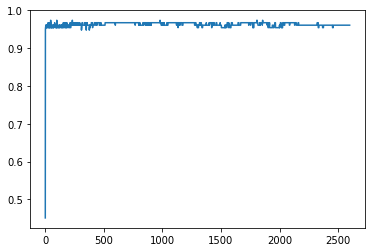

train Loss: 0.0017 Acc: 1.0000
val Loss: 0.2893 Acc: 0.9608

Epoch 2601/4999
----------
train Loss: 0.0030 Acc: 1.0000
val Loss: 0.2890 Acc: 0.9608

Epoch 2602/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.2885 Acc: 0.9608

Epoch 2603/4999
----------
train Loss: 0.0122 Acc: 0.9959
val Loss: 0.2850 Acc: 0.9608

Epoch 2604/4999
----------
train Loss: 0.0115 Acc: 0.9959
val Loss: 0.2802 Acc: 0.9608

Epoch 2605/4999
----------
train Loss: 0.0044 Acc: 0.9959
val Loss: 0.2761 Acc: 0.9608

Epoch 2606/4999
----------
train Loss: 0.0098 Acc: 0.9918
val Loss: 0.2741 Acc: 0.9608

Epoch 2607/4999
----------
train Loss: 0.0079 Acc: 1.0000
val Loss: 0.2750 Acc: 0.9608

Epoch 2608/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.2759 Acc: 0.9608

Epoch 2609/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.2769 Acc: 0.9608

Epoch 2610/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.2772 Acc: 0.9608

Epoch 2611/4999
----------
train Loss: 0.0013 Acc: 1.0000
v

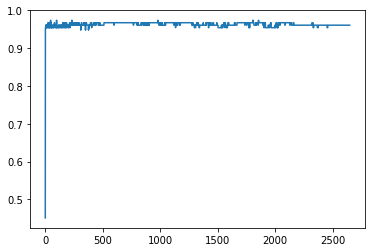

train Loss: 0.0077 Acc: 0.9959
val Loss: 0.2948 Acc: 0.9608

Epoch 2651/4999
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.2937 Acc: 0.9608

Epoch 2652/4999
----------
train Loss: 0.0073 Acc: 0.9959
val Loss: 0.2934 Acc: 0.9608

Epoch 2653/4999
----------
train Loss: 0.0044 Acc: 1.0000
val Loss: 0.2942 Acc: 0.9608

Epoch 2654/4999
----------
train Loss: 0.0186 Acc: 0.9959
val Loss: 0.2899 Acc: 0.9608

Epoch 2655/4999
----------
train Loss: 0.0101 Acc: 0.9959
val Loss: 0.2845 Acc: 0.9608

Epoch 2656/4999
----------
train Loss: 0.0075 Acc: 0.9959
val Loss: 0.2778 Acc: 0.9608

Epoch 2657/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.2741 Acc: 0.9608

Epoch 2658/4999
----------
train Loss: 0.0088 Acc: 0.9918
val Loss: 0.2757 Acc: 0.9608

Epoch 2659/4999
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.2766 Acc: 0.9608

Epoch 2660/4999
----------
train Loss: 0.0027 Acc: 1.0000
val Loss: 0.2770 Acc: 0.9608

Epoch 2661/4999
----------
train Loss: 0.0012 Acc: 1.0000
v

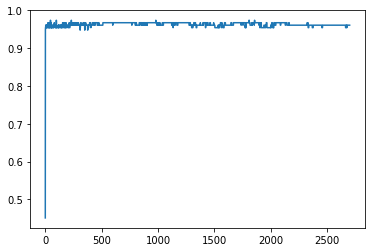

train Loss: 0.0034 Acc: 1.0000
val Loss: 0.2765 Acc: 0.9608

Epoch 2701/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.2771 Acc: 0.9608

Epoch 2702/4999
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.2784 Acc: 0.9608

Epoch 2703/4999
----------
train Loss: 0.0095 Acc: 0.9959
val Loss: 0.2794 Acc: 0.9608

Epoch 2704/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.2775 Acc: 0.9608

Epoch 2705/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.2779 Acc: 0.9608

Epoch 2706/4999
----------
train Loss: 0.0087 Acc: 0.9918
val Loss: 0.2811 Acc: 0.9608

Epoch 2707/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.2828 Acc: 0.9608

Epoch 2708/4999
----------
train Loss: 0.0061 Acc: 0.9959
val Loss: 0.2778 Acc: 0.9608

Epoch 2709/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.2772 Acc: 0.9608

Epoch 2710/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.2772 Acc: 0.9608

Epoch 2711/4999
----------
train Loss: 0.0233 Acc: 0.9918
v

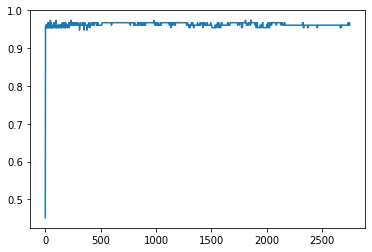

train Loss: 0.0046 Acc: 1.0000
val Loss: 0.2743 Acc: 0.9608

Epoch 2751/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.2733 Acc: 0.9608

Epoch 2752/4999
----------
train Loss: 0.0047 Acc: 1.0000
val Loss: 0.2718 Acc: 0.9608

Epoch 2753/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.2702 Acc: 0.9608

Epoch 2754/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.2703 Acc: 0.9608

Epoch 2755/4999
----------
train Loss: 0.0062 Acc: 0.9959
val Loss: 0.2692 Acc: 0.9608

Epoch 2756/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.2684 Acc: 0.9608

Epoch 2757/4999
----------
train Loss: 0.0086 Acc: 0.9959
val Loss: 0.2655 Acc: 0.9608

Epoch 2758/4999
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.2662 Acc: 0.9608

Epoch 2759/4999
----------
train Loss: 0.0042 Acc: 1.0000
val Loss: 0.2695 Acc: 0.9608

Epoch 2760/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.2711 Acc: 0.9608

Epoch 2761/4999
----------
train Loss: 0.0046 Acc: 0.9959
v

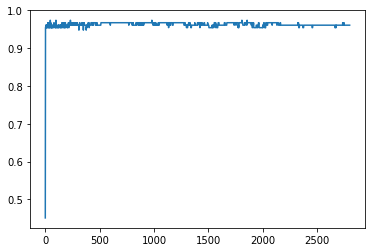

train Loss: 0.0006 Acc: 1.0000
val Loss: 0.2998 Acc: 0.9608

Epoch 2801/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.2991 Acc: 0.9608

Epoch 2802/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.2989 Acc: 0.9608

Epoch 2803/4999
----------
train Loss: 0.0113 Acc: 0.9959
val Loss: 0.2964 Acc: 0.9608

Epoch 2804/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.2962 Acc: 0.9608

Epoch 2805/4999
----------
train Loss: 0.0022 Acc: 1.0000
val Loss: 0.2980 Acc: 0.9608

Epoch 2806/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.2987 Acc: 0.9608

Epoch 2807/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.2988 Acc: 0.9608

Epoch 2808/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.2991 Acc: 0.9608

Epoch 2809/4999
----------
train Loss: 0.0107 Acc: 0.9959
val Loss: 0.3005 Acc: 0.9608

Epoch 2810/4999
----------
train Loss: 0.0048 Acc: 1.0000
val Loss: 0.3010 Acc: 0.9608

Epoch 2811/4999
----------
train Loss: 0.0061 Acc: 0.9959
v

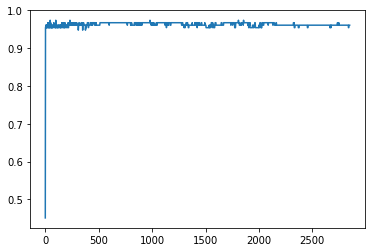

train Loss: 0.0240 Acc: 0.9959
val Loss: 0.2835 Acc: 0.9608

Epoch 2851/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.2832 Acc: 0.9608

Epoch 2852/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.2826 Acc: 0.9608

Epoch 2853/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.2829 Acc: 0.9608

Epoch 2854/4999
----------
train Loss: 0.0058 Acc: 0.9959
val Loss: 0.2851 Acc: 0.9608

Epoch 2855/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.2871 Acc: 0.9608

Epoch 2856/4999
----------
train Loss: 0.0131 Acc: 0.9959
val Loss: 0.2842 Acc: 0.9608

Epoch 2857/4999
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.2812 Acc: 0.9608

Epoch 2858/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.2821 Acc: 0.9608

Epoch 2859/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.2827 Acc: 0.9608

Epoch 2860/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.2824 Acc: 0.9608

Epoch 2861/4999
----------
train Loss: 0.0031 Acc: 1.0000
v

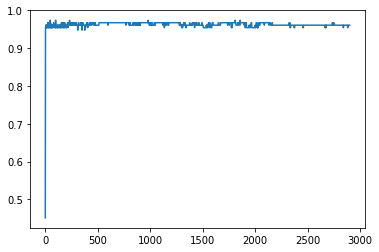

train Loss: 0.0010 Acc: 1.0000
val Loss: 0.2764 Acc: 0.9608

Epoch 2901/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.2776 Acc: 0.9608

Epoch 2902/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.2811 Acc: 0.9608

Epoch 2903/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.2824 Acc: 0.9608

Epoch 2904/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.2845 Acc: 0.9608

Epoch 2905/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.2861 Acc: 0.9608

Epoch 2906/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.2884 Acc: 0.9608

Epoch 2907/4999
----------
train Loss: 0.0174 Acc: 0.9959
val Loss: 0.2985 Acc: 0.9608

Epoch 2908/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3008 Acc: 0.9608

Epoch 2909/4999
----------
train Loss: 0.0080 Acc: 0.9959
val Loss: 0.3008 Acc: 0.9608

Epoch 2910/4999
----------
train Loss: 0.0044 Acc: 0.9959
val Loss: 0.3007 Acc: 0.9608

Epoch 2911/4999
----------
train Loss: 0.0149 Acc: 0.9918
v

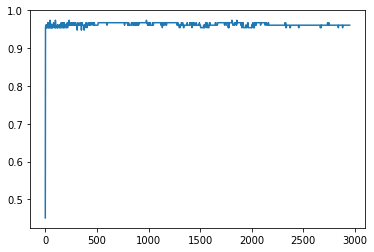

train Loss: 0.0162 Acc: 0.9918
val Loss: 0.2773 Acc: 0.9608

Epoch 2951/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.2786 Acc: 0.9608

Epoch 2952/4999
----------
train Loss: 0.0051 Acc: 0.9959
val Loss: 0.2796 Acc: 0.9608

Epoch 2953/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.2816 Acc: 0.9608

Epoch 2954/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.2823 Acc: 0.9608

Epoch 2955/4999
----------
train Loss: 0.0472 Acc: 0.9877
val Loss: 0.2792 Acc: 0.9608

Epoch 2956/4999
----------
train Loss: 0.0038 Acc: 0.9959
val Loss: 0.2745 Acc: 0.9608

Epoch 2957/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.2737 Acc: 0.9608

Epoch 2958/4999
----------
train Loss: 0.0051 Acc: 1.0000
val Loss: 0.2745 Acc: 0.9608

Epoch 2959/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.2758 Acc: 0.9608

Epoch 2960/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.2761 Acc: 0.9608

Epoch 2961/4999
----------
train Loss: 0.0081 Acc: 0.9959
v

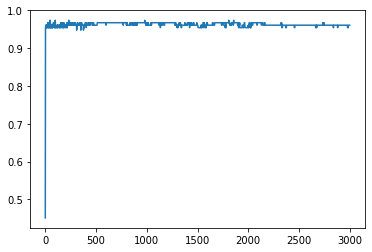

train Loss: 0.0009 Acc: 1.0000
val Loss: 0.2496 Acc: 0.9608

Epoch 3001/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.2500 Acc: 0.9608

Epoch 3002/4999
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.2508 Acc: 0.9608

Epoch 3003/4999
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.2541 Acc: 0.9608

Epoch 3004/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.2554 Acc: 0.9608

Epoch 3005/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.2559 Acc: 0.9608

Epoch 3006/4999
----------
train Loss: 0.0191 Acc: 0.9918
val Loss: 0.2578 Acc: 0.9608

Epoch 3007/4999
----------
train Loss: 0.0051 Acc: 0.9959
val Loss: 0.2600 Acc: 0.9608

Epoch 3008/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.2711 Acc: 0.9608

Epoch 3009/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.2748 Acc: 0.9542

Epoch 3010/4999
----------
train Loss: 0.0056 Acc: 0.9959
val Loss: 0.2758 Acc: 0.9542

Epoch 3011/4999
----------
train Loss: 0.0046 Acc: 1.0000
v

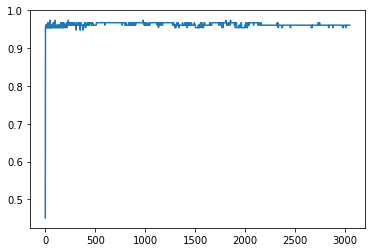

train Loss: 0.0142 Acc: 0.9918
val Loss: 0.2853 Acc: 0.9608

Epoch 3051/4999
----------
train Loss: 0.0075 Acc: 0.9959
val Loss: 0.2859 Acc: 0.9608

Epoch 3052/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.2865 Acc: 0.9608

Epoch 3053/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.2871 Acc: 0.9608

Epoch 3054/4999
----------
train Loss: 0.0079 Acc: 0.9959
val Loss: 0.2876 Acc: 0.9608

Epoch 3055/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.2878 Acc: 0.9608

Epoch 3056/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.2885 Acc: 0.9608

Epoch 3057/4999
----------
train Loss: 0.0247 Acc: 0.9918
val Loss: 0.2936 Acc: 0.9608

Epoch 3058/4999
----------
train Loss: 0.0058 Acc: 1.0000
val Loss: 0.3008 Acc: 0.9608

Epoch 3059/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3030 Acc: 0.9608

Epoch 3060/4999
----------
train Loss: 0.0037 Acc: 0.9959
val Loss: 0.3035 Acc: 0.9608

Epoch 3061/4999
----------
train Loss: 0.0034 Acc: 0.9959
v

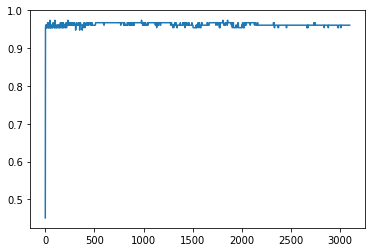

train Loss: 0.0015 Acc: 1.0000
val Loss: 0.3024 Acc: 0.9608

Epoch 3101/4999
----------
train Loss: 0.0058 Acc: 0.9959
val Loss: 0.3029 Acc: 0.9608

Epoch 3102/4999
----------
train Loss: 0.0096 Acc: 0.9959
val Loss: 0.3059 Acc: 0.9608

Epoch 3103/4999
----------
train Loss: 0.0086 Acc: 0.9959
val Loss: 0.3053 Acc: 0.9608

Epoch 3104/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.3044 Acc: 0.9608

Epoch 3105/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3048 Acc: 0.9608

Epoch 3106/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3048 Acc: 0.9608

Epoch 3107/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3046 Acc: 0.9608

Epoch 3108/4999
----------
train Loss: 0.0078 Acc: 0.9959
val Loss: 0.3070 Acc: 0.9608

Epoch 3109/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3223 Acc: 0.9608

Epoch 3110/4999
----------
train Loss: 0.0108 Acc: 0.9959
val Loss: 0.3266 Acc: 0.9608

Epoch 3111/4999
----------
train Loss: 0.0008 Acc: 1.0000
v

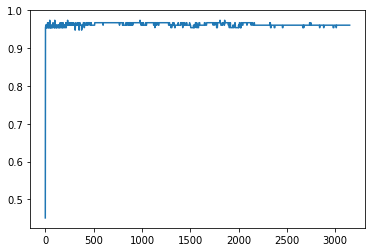

train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3158 Acc: 0.9608

Epoch 3151/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.3159 Acc: 0.9608

Epoch 3152/4999
----------
train Loss: 0.0044 Acc: 1.0000
val Loss: 0.3163 Acc: 0.9608

Epoch 3153/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3167 Acc: 0.9608

Epoch 3154/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3188 Acc: 0.9608

Epoch 3155/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.3194 Acc: 0.9608

Epoch 3156/4999
----------
train Loss: 0.0083 Acc: 1.0000
val Loss: 0.3194 Acc: 0.9608

Epoch 3157/4999
----------
train Loss: 0.0059 Acc: 0.9959
val Loss: 0.3184 Acc: 0.9608

Epoch 3158/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3179 Acc: 0.9608

Epoch 3159/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3186 Acc: 0.9608

Epoch 3160/4999
----------
train Loss: 0.0167 Acc: 0.9918
val Loss: 0.3188 Acc: 0.9608

Epoch 3161/4999
----------
train Loss: 0.0106 Acc: 0.9959
v

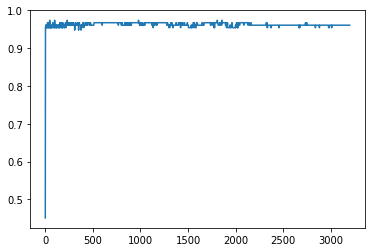

train Loss: 0.0019 Acc: 1.0000
val Loss: 0.2972 Acc: 0.9608

Epoch 3201/4999
----------
train Loss: 0.0178 Acc: 0.9959
val Loss: 0.2917 Acc: 0.9608

Epoch 3202/4999
----------
train Loss: 0.0097 Acc: 0.9918
val Loss: 0.2957 Acc: 0.9608

Epoch 3203/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.2995 Acc: 0.9608

Epoch 3204/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.2996 Acc: 0.9608

Epoch 3205/4999
----------
train Loss: 0.0121 Acc: 0.9918
val Loss: 0.3012 Acc: 0.9608

Epoch 3206/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.3028 Acc: 0.9608

Epoch 3207/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3031 Acc: 0.9608

Epoch 3208/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.3014 Acc: 0.9608

Epoch 3209/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.2998 Acc: 0.9608

Epoch 3210/4999
----------
train Loss: 0.0097 Acc: 0.9959
val Loss: 0.2990 Acc: 0.9608

Epoch 3211/4999
----------
train Loss: 0.0002 Acc: 1.0000
v

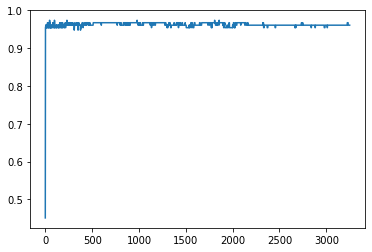

train Loss: 0.0054 Acc: 1.0000
val Loss: 0.2895 Acc: 0.9608

Epoch 3251/4999
----------
train Loss: 0.0072 Acc: 0.9959
val Loss: 0.2892 Acc: 0.9608

Epoch 3252/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.2884 Acc: 0.9608

Epoch 3253/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.2888 Acc: 0.9608

Epoch 3254/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.2894 Acc: 0.9608

Epoch 3255/4999
----------
train Loss: 0.0156 Acc: 0.9918
val Loss: 0.2904 Acc: 0.9608

Epoch 3256/4999
----------
train Loss: 0.0152 Acc: 0.9959
val Loss: 0.2916 Acc: 0.9608

Epoch 3257/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.2917 Acc: 0.9608

Epoch 3258/4999
----------
train Loss: 0.0046 Acc: 0.9959
val Loss: 0.2962 Acc: 0.9608

Epoch 3259/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.2984 Acc: 0.9608

Epoch 3260/4999
----------
train Loss: 0.0113 Acc: 0.9959
val Loss: 0.2991 Acc: 0.9608

Epoch 3261/4999
----------
train Loss: 0.0179 Acc: 0.9918
v

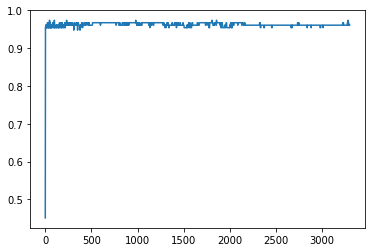

train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3060 Acc: 0.9608

Epoch 3301/4999
----------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.3042 Acc: 0.9608

Epoch 3302/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.3037 Acc: 0.9608

Epoch 3303/4999
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3033 Acc: 0.9608

Epoch 3304/4999
----------
train Loss: 0.0073 Acc: 0.9959
val Loss: 0.3056 Acc: 0.9608

Epoch 3305/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3059 Acc: 0.9608

Epoch 3306/4999
----------
train Loss: 0.0116 Acc: 0.9918
val Loss: 0.3040 Acc: 0.9608

Epoch 3307/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3048 Acc: 0.9608

Epoch 3308/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3034 Acc: 0.9608

Epoch 3309/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3040 Acc: 0.9608

Epoch 3310/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.3044 Acc: 0.9608

Epoch 3311/4999
----------
train Loss: 0.0004 Acc: 1.0000
v

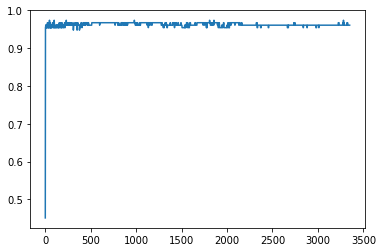

train Loss: 0.0036 Acc: 1.0000
val Loss: 0.2782 Acc: 0.9608

Epoch 3351/4999
----------
train Loss: 0.0071 Acc: 0.9959
val Loss: 0.2797 Acc: 0.9608

Epoch 3352/4999
----------
train Loss: 0.0058 Acc: 1.0000
val Loss: 0.2813 Acc: 0.9608

Epoch 3353/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.2825 Acc: 0.9608

Epoch 3354/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.2822 Acc: 0.9608

Epoch 3355/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.2821 Acc: 0.9608

Epoch 3356/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.2828 Acc: 0.9608

Epoch 3357/4999
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.2838 Acc: 0.9608

Epoch 3358/4999
----------
train Loss: 0.0042 Acc: 1.0000
val Loss: 0.2863 Acc: 0.9608

Epoch 3359/4999
----------
train Loss: 0.0150 Acc: 0.9959
val Loss: 0.2881 Acc: 0.9608

Epoch 3360/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.2906 Acc: 0.9608

Epoch 3361/4999
----------
train Loss: 0.0002 Acc: 1.0000
v

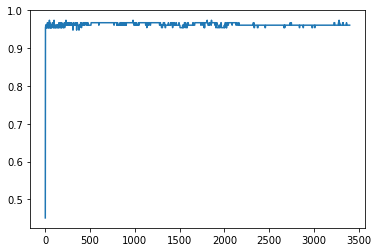

train Loss: 0.0136 Acc: 0.9959
val Loss: 0.3240 Acc: 0.9608

Epoch 3401/4999
----------
train Loss: 0.0042 Acc: 1.0000
val Loss: 0.3250 Acc: 0.9608

Epoch 3402/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3255 Acc: 0.9608

Epoch 3403/4999
----------
train Loss: 0.0091 Acc: 0.9959
val Loss: 0.3256 Acc: 0.9608

Epoch 3404/4999
----------
train Loss: 0.0221 Acc: 0.9918
val Loss: 0.3219 Acc: 0.9608

Epoch 3405/4999
----------
train Loss: 0.0082 Acc: 0.9959
val Loss: 0.3243 Acc: 0.9608

Epoch 3406/4999
----------
train Loss: 0.0042 Acc: 1.0000
val Loss: 0.3197 Acc: 0.9608

Epoch 3407/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3184 Acc: 0.9608

Epoch 3408/4999
----------
train Loss: 0.0102 Acc: 0.9959
val Loss: 0.3236 Acc: 0.9608

Epoch 3409/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3256 Acc: 0.9608

Epoch 3410/4999
----------
train Loss: 0.0139 Acc: 0.9959
val Loss: 0.3262 Acc: 0.9608

Epoch 3411/4999
----------
train Loss: 0.0032 Acc: 1.0000
v

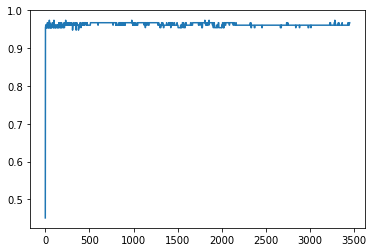

train Loss: 0.0003 Acc: 1.0000
val Loss: 0.2794 Acc: 0.9673

Epoch 3451/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.2791 Acc: 0.9673

Epoch 3452/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.2793 Acc: 0.9673

Epoch 3453/4999
----------
train Loss: 0.0071 Acc: 0.9959
val Loss: 0.2807 Acc: 0.9673

Epoch 3454/4999
----------
train Loss: 0.0233 Acc: 0.9918
val Loss: 0.2835 Acc: 0.9673

Epoch 3455/4999
----------
train Loss: 0.0070 Acc: 0.9959
val Loss: 0.2877 Acc: 0.9673

Epoch 3456/4999
----------
train Loss: 0.0047 Acc: 0.9959
val Loss: 0.2905 Acc: 0.9673

Epoch 3457/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.2920 Acc: 0.9608

Epoch 3458/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.2925 Acc: 0.9608

Epoch 3459/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.2930 Acc: 0.9608

Epoch 3460/4999
----------
train Loss: 0.0090 Acc: 0.9959
val Loss: 0.2933 Acc: 0.9608

Epoch 3461/4999
----------
train Loss: 0.0068 Acc: 0.9959
v

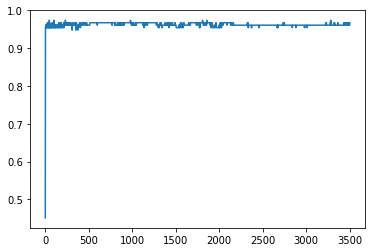

train Loss: 0.0054 Acc: 0.9959
val Loss: 0.2876 Acc: 0.9673

Epoch 3501/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.2875 Acc: 0.9673

Epoch 3502/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.2891 Acc: 0.9673

Epoch 3503/4999
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.2901 Acc: 0.9673

Epoch 3504/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.2905 Acc: 0.9673

Epoch 3505/4999
----------
train Loss: 0.0030 Acc: 1.0000
val Loss: 0.2888 Acc: 0.9673

Epoch 3506/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.2862 Acc: 0.9673

Epoch 3507/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.2860 Acc: 0.9673

Epoch 3508/4999
----------
train Loss: 0.0159 Acc: 0.9959
val Loss: 0.2822 Acc: 0.9608

Epoch 3509/4999
----------
train Loss: 0.0022 Acc: 1.0000
val Loss: 0.2817 Acc: 0.9608

Epoch 3510/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.2816 Acc: 0.9608

Epoch 3511/4999
----------
train Loss: 0.0056 Acc: 0.9959
v

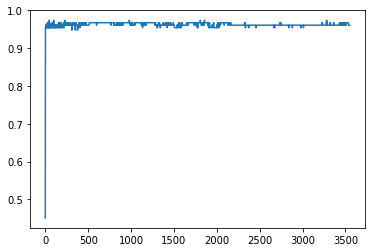

train Loss: 0.0012 Acc: 1.0000
val Loss: 0.2990 Acc: 0.9608

Epoch 3551/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.2995 Acc: 0.9608

Epoch 3552/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.2996 Acc: 0.9608

Epoch 3553/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.3006 Acc: 0.9608

Epoch 3554/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.3010 Acc: 0.9608

Epoch 3555/4999
----------
train Loss: 0.0045 Acc: 0.9959
val Loss: 0.3004 Acc: 0.9608

Epoch 3556/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.2997 Acc: 0.9608

Epoch 3557/4999
----------
train Loss: 0.0371 Acc: 0.9918
val Loss: 0.2985 Acc: 0.9608

Epoch 3558/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.2962 Acc: 0.9608

Epoch 3559/4999
----------
train Loss: 0.0043 Acc: 0.9959
val Loss: 0.2948 Acc: 0.9608

Epoch 3560/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.2941 Acc: 0.9608

Epoch 3561/4999
----------
train Loss: 0.0039 Acc: 0.9959
v

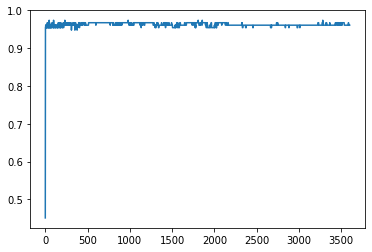

train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3125 Acc: 0.9608

Epoch 3601/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3131 Acc: 0.9608

Epoch 3602/4999
----------
train Loss: 0.0049 Acc: 0.9959
val Loss: 0.3126 Acc: 0.9608

Epoch 3603/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.3123 Acc: 0.9608

Epoch 3604/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.3127 Acc: 0.9608

Epoch 3605/4999
----------
train Loss: 0.0189 Acc: 0.9959
val Loss: 0.3115 Acc: 0.9608

Epoch 3606/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3110 Acc: 0.9608

Epoch 3607/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3110 Acc: 0.9608

Epoch 3608/4999
----------
train Loss: 0.0035 Acc: 1.0000
val Loss: 0.3130 Acc: 0.9608

Epoch 3609/4999
----------
train Loss: 0.0052 Acc: 1.0000
val Loss: 0.3139 Acc: 0.9608

Epoch 3610/4999
----------
train Loss: 0.0131 Acc: 0.9959
val Loss: 0.3148 Acc: 0.9608

Epoch 3611/4999
----------
train Loss: 0.0027 Acc: 1.0000
v

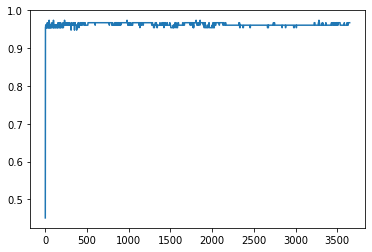

train Loss: 0.0098 Acc: 0.9959
val Loss: 0.3113 Acc: 0.9673

Epoch 3651/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3115 Acc: 0.9673

Epoch 3652/4999
----------
train Loss: 0.0052 Acc: 1.0000
val Loss: 0.3147 Acc: 0.9673

Epoch 3653/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3175 Acc: 0.9673

Epoch 3654/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3183 Acc: 0.9673

Epoch 3655/4999
----------
train Loss: 0.0022 Acc: 1.0000
val Loss: 0.3171 Acc: 0.9673

Epoch 3656/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.3158 Acc: 0.9673

Epoch 3657/4999
----------
train Loss: 0.0043 Acc: 0.9959
val Loss: 0.3159 Acc: 0.9673

Epoch 3658/4999
----------
train Loss: 0.0169 Acc: 0.9959
val Loss: 0.3163 Acc: 0.9673

Epoch 3659/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3189 Acc: 0.9608

Epoch 3660/4999
----------
train Loss: 0.0040 Acc: 0.9959
val Loss: 0.3199 Acc: 0.9608

Epoch 3661/4999
----------
train Loss: 0.0035 Acc: 0.9959
v

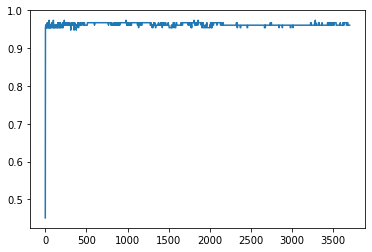

train Loss: 0.0054 Acc: 0.9959
val Loss: 0.3184 Acc: 0.9608

Epoch 3701/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.3180 Acc: 0.9608

Epoch 3702/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3172 Acc: 0.9608

Epoch 3703/4999
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.3162 Acc: 0.9608

Epoch 3704/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3159 Acc: 0.9608

Epoch 3705/4999
----------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.3168 Acc: 0.9608

Epoch 3706/4999
----------
train Loss: 0.0211 Acc: 0.9959
val Loss: 0.3152 Acc: 0.9608

Epoch 3707/4999
----------
train Loss: 0.0056 Acc: 1.0000
val Loss: 0.3162 Acc: 0.9608

Epoch 3708/4999
----------
train Loss: 0.0234 Acc: 0.9918
val Loss: 0.3143 Acc: 0.9608

Epoch 3709/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.3074 Acc: 0.9608

Epoch 3710/4999
----------
train Loss: 0.0099 Acc: 0.9959
val Loss: 0.3057 Acc: 0.9608

Epoch 3711/4999
----------
train Loss: 0.0005 Acc: 1.0000
v

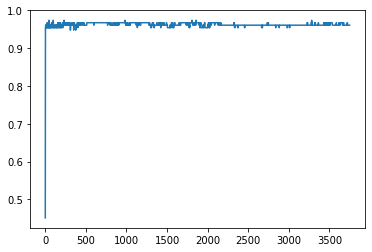

train Loss: 0.0041 Acc: 0.9959
val Loss: 0.3553 Acc: 0.9608

Epoch 3751/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.3554 Acc: 0.9608

Epoch 3752/4999
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.3551 Acc: 0.9608

Epoch 3753/4999
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.3550 Acc: 0.9608

Epoch 3754/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.3558 Acc: 0.9608

Epoch 3755/4999
----------
train Loss: 0.0054 Acc: 0.9959
val Loss: 0.3559 Acc: 0.9608

Epoch 3756/4999
----------
train Loss: 0.0048 Acc: 1.0000
val Loss: 0.3571 Acc: 0.9608

Epoch 3757/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3579 Acc: 0.9608

Epoch 3758/4999
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.3581 Acc: 0.9608

Epoch 3759/4999
----------
train Loss: 0.0054 Acc: 0.9959
val Loss: 0.3587 Acc: 0.9608

Epoch 3760/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.3582 Acc: 0.9608

Epoch 3761/4999
----------
train Loss: 0.0072 Acc: 0.9959
v

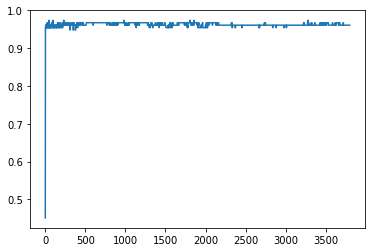

train Loss: 0.0084 Acc: 0.9959
val Loss: 0.3265 Acc: 0.9608

Epoch 3801/4999
----------
train Loss: 0.0076 Acc: 0.9959
val Loss: 0.3266 Acc: 0.9608

Epoch 3802/4999
----------
train Loss: 0.0116 Acc: 0.9959
val Loss: 0.3245 Acc: 0.9608

Epoch 3803/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3241 Acc: 0.9608

Epoch 3804/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3239 Acc: 0.9608

Epoch 3805/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3241 Acc: 0.9608

Epoch 3806/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3224 Acc: 0.9608

Epoch 3807/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3204 Acc: 0.9608

Epoch 3808/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3208 Acc: 0.9608

Epoch 3809/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3217 Acc: 0.9608

Epoch 3810/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3221 Acc: 0.9608

Epoch 3811/4999
----------
train Loss: 0.0051 Acc: 0.9959
v

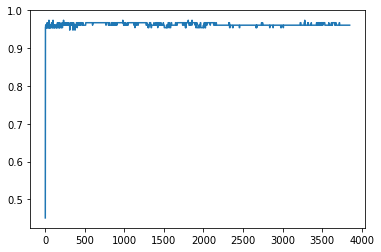

train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3288 Acc: 0.9608

Epoch 3851/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.3291 Acc: 0.9608

Epoch 3852/4999
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.3294 Acc: 0.9608

Epoch 3853/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.3301 Acc: 0.9608

Epoch 3854/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.3312 Acc: 0.9608

Epoch 3855/4999
----------
train Loss: 0.0036 Acc: 1.0000
val Loss: 0.3318 Acc: 0.9608

Epoch 3856/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3324 Acc: 0.9608

Epoch 3857/4999
----------
train Loss: 0.0107 Acc: 0.9959
val Loss: 0.3322 Acc: 0.9608

Epoch 3858/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3312 Acc: 0.9608

Epoch 3859/4999
----------
train Loss: 0.0049 Acc: 1.0000
val Loss: 0.3322 Acc: 0.9608

Epoch 3860/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.3323 Acc: 0.9608

Epoch 3861/4999
----------
train Loss: 0.0046 Acc: 0.9959
v

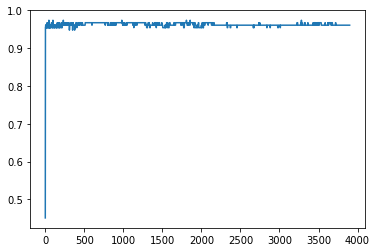

train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3268 Acc: 0.9608

Epoch 3901/4999
----------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.3232 Acc: 0.9608

Epoch 3902/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.3175 Acc: 0.9608

Epoch 3903/4999
----------
train Loss: 0.0034 Acc: 0.9959
val Loss: 0.3169 Acc: 0.9608

Epoch 3904/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3172 Acc: 0.9608

Epoch 3905/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.3167 Acc: 0.9608

Epoch 3906/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3152 Acc: 0.9608

Epoch 3907/4999
----------
train Loss: 0.0056 Acc: 0.9959
val Loss: 0.3134 Acc: 0.9608

Epoch 3908/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3125 Acc: 0.9608

Epoch 3909/4999
----------
train Loss: 0.0093 Acc: 0.9959
val Loss: 0.3142 Acc: 0.9608

Epoch 3910/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.3173 Acc: 0.9608

Epoch 3911/4999
----------
train Loss: 0.0008 Acc: 1.0000
v

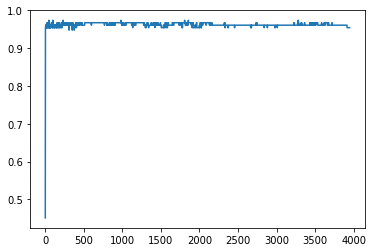

train Loss: 0.0027 Acc: 1.0000
val Loss: 0.3915 Acc: 0.9542

Epoch 3951/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.3914 Acc: 0.9542

Epoch 3952/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.3910 Acc: 0.9542

Epoch 3953/4999
----------
train Loss: 0.0198 Acc: 0.9918
val Loss: 0.3832 Acc: 0.9542

Epoch 3954/4999
----------
train Loss: 0.0055 Acc: 1.0000
val Loss: 0.3810 Acc: 0.9542

Epoch 3955/4999
----------
train Loss: 0.0039 Acc: 1.0000
val Loss: 0.3795 Acc: 0.9542

Epoch 3956/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3784 Acc: 0.9542

Epoch 3957/4999
----------
train Loss: 0.0040 Acc: 1.0000
val Loss: 0.3804 Acc: 0.9542

Epoch 3958/4999
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3808 Acc: 0.9542

Epoch 3959/4999
----------
train Loss: 0.0174 Acc: 0.9959
val Loss: 0.3811 Acc: 0.9542

Epoch 3960/4999
----------
train Loss: 0.0129 Acc: 0.9959
val Loss: 0.3811 Acc: 0.9542

Epoch 3961/4999
----------
train Loss: 0.0008 Acc: 1.0000
v

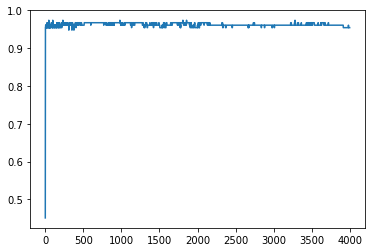

train Loss: 0.0035 Acc: 1.0000
val Loss: 0.3630 Acc: 0.9542

Epoch 4001/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3629 Acc: 0.9542

Epoch 4002/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3629 Acc: 0.9542

Epoch 4003/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3632 Acc: 0.9542

Epoch 4004/4999
----------
train Loss: 0.0062 Acc: 0.9959
val Loss: 0.3607 Acc: 0.9542

Epoch 4005/4999
----------
train Loss: 0.0152 Acc: 0.9918
val Loss: 0.3543 Acc: 0.9542

Epoch 4006/4999
----------
train Loss: 0.0105 Acc: 0.9959
val Loss: 0.3488 Acc: 0.9542

Epoch 4007/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.3489 Acc: 0.9542

Epoch 4008/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.3498 Acc: 0.9542

Epoch 4009/4999
----------
train Loss: 0.0145 Acc: 0.9959
val Loss: 0.3491 Acc: 0.9542

Epoch 4010/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3489 Acc: 0.9542

Epoch 4011/4999
----------
train Loss: 0.0142 Acc: 0.9918
v

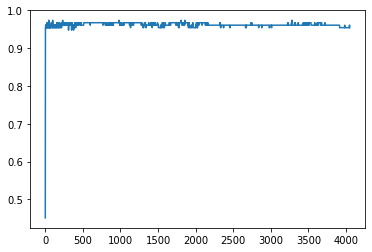

train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3460 Acc: 0.9542

Epoch 4051/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3473 Acc: 0.9542

Epoch 4052/4999
----------
train Loss: 0.0117 Acc: 0.9959
val Loss: 0.3432 Acc: 0.9542

Epoch 4053/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.3417 Acc: 0.9542

Epoch 4054/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3399 Acc: 0.9673

Epoch 4055/4999
----------
train Loss: 0.0153 Acc: 0.9959
val Loss: 0.3355 Acc: 0.9608

Epoch 4056/4999
----------
train Loss: 0.0044 Acc: 1.0000
val Loss: 0.3310 Acc: 0.9608

Epoch 4057/4999
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.3305 Acc: 0.9608

Epoch 4058/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3311 Acc: 0.9608

Epoch 4059/4999
----------
train Loss: 0.0223 Acc: 0.9959
val Loss: 0.3312 Acc: 0.9608

Epoch 4060/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3309 Acc: 0.9673

Epoch 4061/4999
----------
train Loss: 0.0007 Acc: 1.0000
v

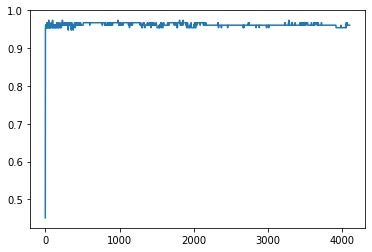

train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3290 Acc: 0.9608

Epoch 4101/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.3295 Acc: 0.9608

Epoch 4102/4999
----------
train Loss: 0.0075 Acc: 0.9959
val Loss: 0.3334 Acc: 0.9608

Epoch 4103/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.3369 Acc: 0.9608

Epoch 4104/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.3385 Acc: 0.9608

Epoch 4105/4999
----------
train Loss: 0.0027 Acc: 1.0000
val Loss: 0.3395 Acc: 0.9608

Epoch 4106/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3410 Acc: 0.9608

Epoch 4107/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3411 Acc: 0.9608

Epoch 4108/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3413 Acc: 0.9608

Epoch 4109/4999
----------
train Loss: 0.0087 Acc: 0.9959
val Loss: 0.3430 Acc: 0.9608

Epoch 4110/4999
----------
train Loss: 0.0080 Acc: 0.9959
val Loss: 0.3444 Acc: 0.9608

Epoch 4111/4999
----------
train Loss: 0.0084 Acc: 0.9959
v

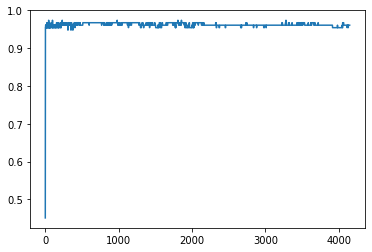

train Loss: 0.0080 Acc: 0.9959
val Loss: 0.3506 Acc: 0.9608

Epoch 4151/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.3507 Acc: 0.9608

Epoch 4152/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3507 Acc: 0.9608

Epoch 4153/4999
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3509 Acc: 0.9608

Epoch 4154/4999
----------
train Loss: 0.0058 Acc: 0.9959
val Loss: 0.3453 Acc: 0.9608

Epoch 4155/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3402 Acc: 0.9608

Epoch 4156/4999
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.3390 Acc: 0.9608

Epoch 4157/4999
----------
train Loss: 0.0045 Acc: 0.9959
val Loss: 0.3362 Acc: 0.9608

Epoch 4158/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.3375 Acc: 0.9608

Epoch 4159/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3392 Acc: 0.9608

Epoch 4160/4999
----------
train Loss: 0.0042 Acc: 0.9959
val Loss: 0.3394 Acc: 0.9608

Epoch 4161/4999
----------
train Loss: 0.0023 Acc: 1.0000
v

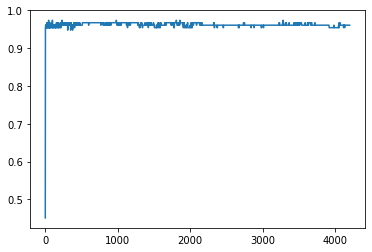

train Loss: 0.0023 Acc: 1.0000
val Loss: 0.3199 Acc: 0.9608

Epoch 4201/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.3195 Acc: 0.9608

Epoch 4202/4999
----------
train Loss: 0.0083 Acc: 0.9959
val Loss: 0.3179 Acc: 0.9608

Epoch 4203/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3172 Acc: 0.9608

Epoch 4204/4999
----------
train Loss: 0.0044 Acc: 0.9959
val Loss: 0.3188 Acc: 0.9608

Epoch 4205/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3216 Acc: 0.9608

Epoch 4206/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3232 Acc: 0.9608

Epoch 4207/4999
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3296 Acc: 0.9608

Epoch 4208/4999
----------
train Loss: 0.0049 Acc: 0.9959
val Loss: 0.3335 Acc: 0.9608

Epoch 4209/4999
----------
train Loss: 0.0140 Acc: 0.9959
val Loss: 0.3370 Acc: 0.9608

Epoch 4210/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3389 Acc: 0.9608

Epoch 4211/4999
----------
train Loss: 0.0009 Acc: 1.0000
v

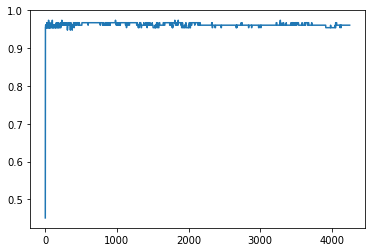

train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3489 Acc: 0.9608

Epoch 4251/4999
----------
train Loss: 0.0040 Acc: 0.9959
val Loss: 0.3504 Acc: 0.9608

Epoch 4252/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.3529 Acc: 0.9608

Epoch 4253/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.3530 Acc: 0.9608

Epoch 4254/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3504 Acc: 0.9608

Epoch 4255/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3499 Acc: 0.9608

Epoch 4256/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.3497 Acc: 0.9608

Epoch 4257/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.3478 Acc: 0.9608

Epoch 4258/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3474 Acc: 0.9608

Epoch 4259/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.3489 Acc: 0.9608

Epoch 4260/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3505 Acc: 0.9608

Epoch 4261/4999
----------
train Loss: 0.0004 Acc: 1.0000
v

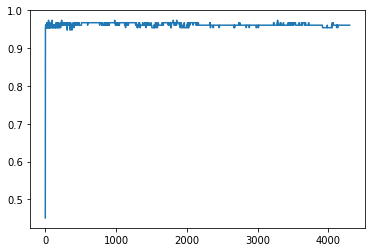

train Loss: 0.0041 Acc: 0.9959
val Loss: 0.3695 Acc: 0.9608

Epoch 4301/4999
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.3694 Acc: 0.9608

Epoch 4302/4999
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.3694 Acc: 0.9608

Epoch 4303/4999
----------
train Loss: 0.0190 Acc: 0.9959
val Loss: 0.3618 Acc: 0.9608

Epoch 4304/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.3599 Acc: 0.9608

Epoch 4305/4999
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.3584 Acc: 0.9608

Epoch 4306/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3575 Acc: 0.9608

Epoch 4307/4999
----------
train Loss: 0.0129 Acc: 0.9959
val Loss: 0.3551 Acc: 0.9608

Epoch 4308/4999
----------
train Loss: 0.0049 Acc: 0.9959
val Loss: 0.3394 Acc: 0.9608

Epoch 4309/4999
----------
train Loss: 0.0060 Acc: 0.9959
val Loss: 0.3388 Acc: 0.9608

Epoch 4310/4999
----------
train Loss: 0.0093 Acc: 0.9959
val Loss: 0.3403 Acc: 0.9608

Epoch 4311/4999
----------
train Loss: 0.0008 Acc: 1.0000
v

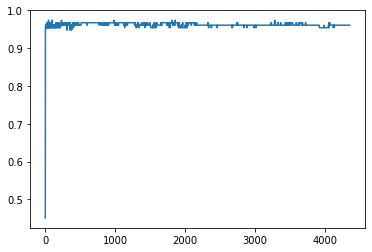

train Loss: 0.0000 Acc: 1.0000
val Loss: 0.3513 Acc: 0.9608

Epoch 4351/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3516 Acc: 0.9608

Epoch 4352/4999
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3519 Acc: 0.9608

Epoch 4353/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3522 Acc: 0.9608

Epoch 4354/4999
----------
train Loss: 0.0046 Acc: 0.9959
val Loss: 0.3515 Acc: 0.9608

Epoch 4355/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3499 Acc: 0.9608

Epoch 4356/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.3497 Acc: 0.9608

Epoch 4357/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3496 Acc: 0.9608

Epoch 4358/4999
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3492 Acc: 0.9608

Epoch 4359/4999
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3492 Acc: 0.9608

Epoch 4360/4999
----------
train Loss: 0.0059 Acc: 0.9959
val Loss: 0.3492 Acc: 0.9608

Epoch 4361/4999
----------
train Loss: 0.0049 Acc: 0.9959
v

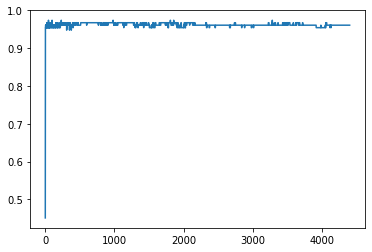

train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3508 Acc: 0.9608

Epoch 4401/4999
----------
train Loss: 0.0162 Acc: 0.9959
val Loss: 0.3474 Acc: 0.9608

Epoch 4402/4999
----------
train Loss: 0.0070 Acc: 0.9959
val Loss: 0.3372 Acc: 0.9608

Epoch 4403/4999
----------
train Loss: 0.0102 Acc: 0.9959
val Loss: 0.3301 Acc: 0.9608

Epoch 4404/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.3277 Acc: 0.9608

Epoch 4405/4999
----------
train Loss: 0.0056 Acc: 0.9959
val Loss: 0.3263 Acc: 0.9608

Epoch 4406/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.3253 Acc: 0.9608

Epoch 4407/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.3251 Acc: 0.9608

Epoch 4408/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.3260 Acc: 0.9608

Epoch 4409/4999
----------
train Loss: 0.0099 Acc: 0.9959
val Loss: 0.3281 Acc: 0.9608

Epoch 4410/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.3293 Acc: 0.9608

Epoch 4411/4999
----------
train Loss: 0.0373 Acc: 0.9918
v

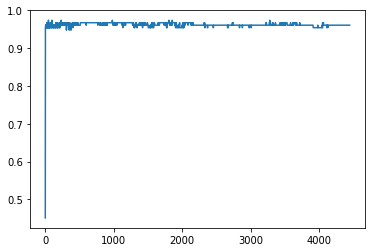

train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3538 Acc: 0.9608

Epoch 4451/4999
----------
train Loss: 0.0041 Acc: 0.9959
val Loss: 0.3463 Acc: 0.9608

Epoch 4452/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3448 Acc: 0.9608

Epoch 4453/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3450 Acc: 0.9608

Epoch 4454/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3452 Acc: 0.9608

Epoch 4455/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3450 Acc: 0.9608

Epoch 4456/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.3451 Acc: 0.9608

Epoch 4457/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3455 Acc: 0.9608

Epoch 4458/4999
----------
train Loss: 0.0119 Acc: 0.9959
val Loss: 0.3472 Acc: 0.9608

Epoch 4459/4999
----------
train Loss: 0.0209 Acc: 0.9959
val Loss: 0.3462 Acc: 0.9608

Epoch 4460/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3421 Acc: 0.9608

Epoch 4461/4999
----------
train Loss: 0.0041 Acc: 1.0000
v

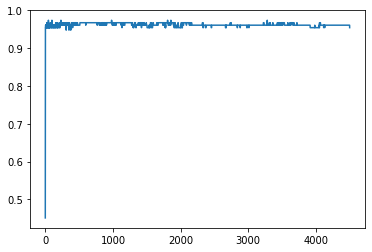

train Loss: 0.0172 Acc: 0.9959
val Loss: 0.3573 Acc: 0.9542

Epoch 4501/4999
----------
train Loss: 0.0182 Acc: 0.9918
val Loss: 0.3579 Acc: 0.9542

Epoch 4502/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3564 Acc: 0.9608

Epoch 4503/4999
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3568 Acc: 0.9608

Epoch 4504/4999
----------
train Loss: 0.0044 Acc: 1.0000
val Loss: 0.3564 Acc: 0.9608

Epoch 4505/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3568 Acc: 0.9608

Epoch 4506/4999
----------
train Loss: 0.0134 Acc: 0.9959
val Loss: 0.3533 Acc: 0.9608

Epoch 4507/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.3496 Acc: 0.9608

Epoch 4508/4999
----------
train Loss: 0.0103 Acc: 0.9918
val Loss: 0.3525 Acc: 0.9542

Epoch 4509/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3542 Acc: 0.9542

Epoch 4510/4999
----------
train Loss: 0.0189 Acc: 0.9918
val Loss: 0.3504 Acc: 0.9542

Epoch 4511/4999
----------
train Loss: 0.0011 Acc: 1.0000
v

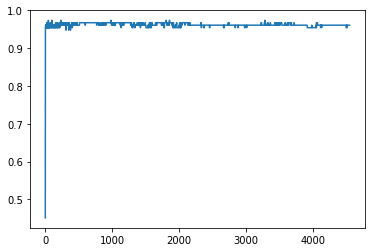

train Loss: 0.0029 Acc: 1.0000
val Loss: 0.3390 Acc: 0.9608

Epoch 4551/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.3379 Acc: 0.9608

Epoch 4552/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.3387 Acc: 0.9608

Epoch 4553/4999
----------
train Loss: 0.0081 Acc: 0.9959
val Loss: 0.3377 Acc: 0.9608

Epoch 4554/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3381 Acc: 0.9608

Epoch 4555/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.3382 Acc: 0.9608

Epoch 4556/4999
----------
train Loss: 0.0058 Acc: 0.9959
val Loss: 0.3393 Acc: 0.9608

Epoch 4557/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3408 Acc: 0.9608

Epoch 4558/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.3416 Acc: 0.9608

Epoch 4559/4999
----------
train Loss: 0.0027 Acc: 1.0000
val Loss: 0.3423 Acc: 0.9608

Epoch 4560/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3430 Acc: 0.9608

Epoch 4561/4999
----------
train Loss: 0.0014 Acc: 1.0000
v

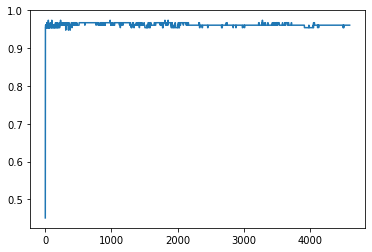

train Loss: 0.0032 Acc: 1.0000
val Loss: 0.3471 Acc: 0.9608

Epoch 4601/4999
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.3471 Acc: 0.9608

Epoch 4602/4999
----------
train Loss: 0.0044 Acc: 0.9959
val Loss: 0.3490 Acc: 0.9608

Epoch 4603/4999
----------
train Loss: 0.0083 Acc: 0.9959
val Loss: 0.3497 Acc: 0.9608

Epoch 4604/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3505 Acc: 0.9608

Epoch 4605/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3508 Acc: 0.9608

Epoch 4606/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.3523 Acc: 0.9608

Epoch 4607/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3533 Acc: 0.9608

Epoch 4608/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3534 Acc: 0.9608

Epoch 4609/4999
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3535 Acc: 0.9608

Epoch 4610/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3536 Acc: 0.9608

Epoch 4611/4999
----------
train Loss: 0.0024 Acc: 1.0000
v

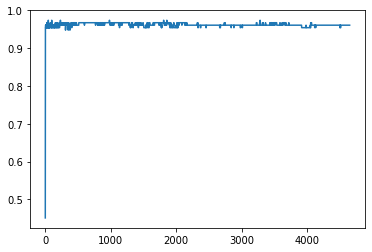

train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3700 Acc: 0.9608

Epoch 4651/4999
----------
train Loss: 0.0062 Acc: 0.9959
val Loss: 0.3714 Acc: 0.9608

Epoch 4652/4999
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3728 Acc: 0.9608

Epoch 4653/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3735 Acc: 0.9608

Epoch 4654/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3747 Acc: 0.9608

Epoch 4655/4999
----------
train Loss: 0.0051 Acc: 0.9959
val Loss: 0.3767 Acc: 0.9608

Epoch 4656/4999
----------
train Loss: 0.0039 Acc: 0.9959
val Loss: 0.3755 Acc: 0.9608

Epoch 4657/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3740 Acc: 0.9608

Epoch 4658/4999
----------
train Loss: 0.0150 Acc: 0.9918
val Loss: 0.3717 Acc: 0.9608

Epoch 4659/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3721 Acc: 0.9608

Epoch 4660/4999
----------
train Loss: 0.0092 Acc: 0.9959
val Loss: 0.3722 Acc: 0.9608

Epoch 4661/4999
----------
train Loss: 0.0024 Acc: 1.0000
v

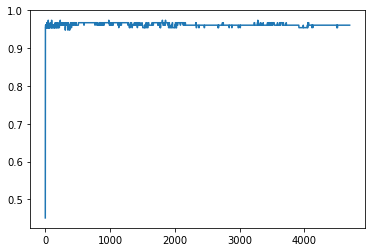

train Loss: 0.0016 Acc: 1.0000
val Loss: 0.3494 Acc: 0.9608

Epoch 4701/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3498 Acc: 0.9608

Epoch 4702/4999
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3500 Acc: 0.9608

Epoch 4703/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3505 Acc: 0.9608

Epoch 4704/4999
----------
train Loss: 0.0109 Acc: 0.9959
val Loss: 0.3483 Acc: 0.9608

Epoch 4705/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3474 Acc: 0.9608

Epoch 4706/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.3489 Acc: 0.9608

Epoch 4707/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3508 Acc: 0.9608

Epoch 4708/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3511 Acc: 0.9608

Epoch 4709/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.3519 Acc: 0.9608

Epoch 4710/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3524 Acc: 0.9608

Epoch 4711/4999
----------
train Loss: 0.0002 Acc: 1.0000
v

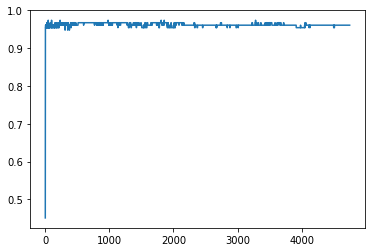

train Loss: 0.0078 Acc: 0.9959
val Loss: 0.3444 Acc: 0.9608

Epoch 4751/4999
----------
train Loss: 0.0055 Acc: 0.9959
val Loss: 0.3449 Acc: 0.9608

Epoch 4752/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3454 Acc: 0.9608

Epoch 4753/4999
----------
train Loss: 0.0057 Acc: 0.9959
val Loss: 0.3465 Acc: 0.9608

Epoch 4754/4999
----------
train Loss: 0.0044 Acc: 1.0000
val Loss: 0.3467 Acc: 0.9608

Epoch 4755/4999
----------
train Loss: 0.0075 Acc: 0.9918
val Loss: 0.3484 Acc: 0.9608

Epoch 4756/4999
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.3490 Acc: 0.9608

Epoch 4757/4999
----------
train Loss: 0.0061 Acc: 0.9959
val Loss: 0.3487 Acc: 0.9608

Epoch 4758/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3484 Acc: 0.9608

Epoch 4759/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3496 Acc: 0.9608

Epoch 4760/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.3499 Acc: 0.9608

Epoch 4761/4999
----------
train Loss: 0.0002 Acc: 1.0000
v

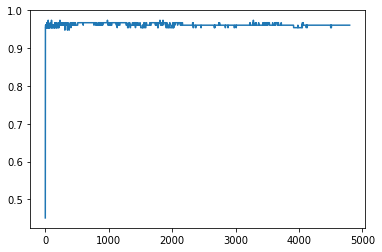

train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3345 Acc: 0.9608

Epoch 4801/4999
----------
train Loss: 0.0086 Acc: 0.9959
val Loss: 0.3314 Acc: 0.9608

Epoch 4802/4999
----------
train Loss: 0.0131 Acc: 0.9959
val Loss: 0.3288 Acc: 0.9608

Epoch 4803/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3267 Acc: 0.9608

Epoch 4804/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3262 Acc: 0.9608

Epoch 4805/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3262 Acc: 0.9608

Epoch 4806/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3263 Acc: 0.9608

Epoch 4807/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3267 Acc: 0.9608

Epoch 4808/4999
----------
train Loss: 0.0043 Acc: 1.0000
val Loss: 0.3272 Acc: 0.9608

Epoch 4809/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3272 Acc: 0.9608

Epoch 4810/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.3271 Acc: 0.9608

Epoch 4811/4999
----------
train Loss: 0.0004 Acc: 1.0000
v

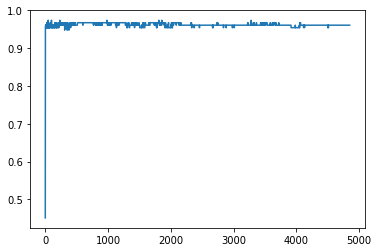

train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3475 Acc: 0.9608

Epoch 4851/4999
----------
train Loss: 0.0088 Acc: 0.9959
val Loss: 0.3448 Acc: 0.9608

Epoch 4852/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3447 Acc: 0.9608

Epoch 4853/4999
----------
train Loss: 0.0069 Acc: 0.9959
val Loss: 0.3419 Acc: 0.9608

Epoch 4854/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3403 Acc: 0.9608

Epoch 4855/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.3403 Acc: 0.9608

Epoch 4856/4999
----------
train Loss: 0.0066 Acc: 0.9959
val Loss: 0.3443 Acc: 0.9608

Epoch 4857/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3461 Acc: 0.9608

Epoch 4858/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3464 Acc: 0.9608

Epoch 4859/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3457 Acc: 0.9608

Epoch 4860/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3456 Acc: 0.9608

Epoch 4861/4999
----------
train Loss: 0.0069 Acc: 1.0000
v

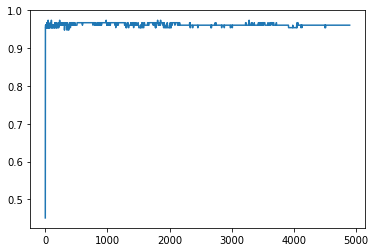

train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3298 Acc: 0.9608

Epoch 4901/4999
----------
train Loss: 0.0052 Acc: 0.9959
val Loss: 0.3288 Acc: 0.9608

Epoch 4902/4999
----------
train Loss: 0.0159 Acc: 0.9959
val Loss: 0.3310 Acc: 0.9608

Epoch 4903/4999
----------
train Loss: 0.0060 Acc: 0.9959
val Loss: 0.3299 Acc: 0.9608

Epoch 4904/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.3205 Acc: 0.9608

Epoch 4905/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3186 Acc: 0.9608

Epoch 4906/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3184 Acc: 0.9608

Epoch 4907/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.3187 Acc: 0.9608

Epoch 4908/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3190 Acc: 0.9608

Epoch 4909/4999
----------
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.3194 Acc: 0.9608

Epoch 4910/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3195 Acc: 0.9608

Epoch 4911/4999
----------
train Loss: 0.0003 Acc: 1.0000
v

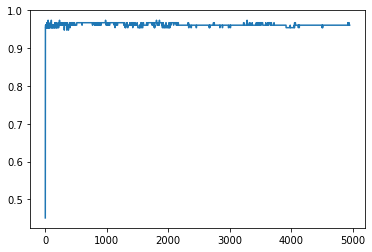

train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3577 Acc: 0.9608

Epoch 4951/4999
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.3567 Acc: 0.9608

Epoch 4952/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3569 Acc: 0.9608

Epoch 4953/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3568 Acc: 0.9608

Epoch 4954/4999
----------
train Loss: 0.0072 Acc: 0.9959
val Loss: 0.3586 Acc: 0.9608

Epoch 4955/4999
----------
train Loss: 0.0134 Acc: 0.9918
val Loss: 0.3578 Acc: 0.9542

Epoch 4956/4999
----------
train Loss: 0.0149 Acc: 0.9959
val Loss: 0.3588 Acc: 0.9542

Epoch 4957/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3593 Acc: 0.9542

Epoch 4958/4999
----------
train Loss: 0.0110 Acc: 0.9959
val Loss: 0.3511 Acc: 0.9608

Epoch 4959/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3474 Acc: 0.9608

Epoch 4960/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.3468 Acc: 0.9608

Epoch 4961/4999
----------
train Loss: 0.0004 Acc: 1.0000
v

In [36]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [ ]:

if model_name == "alexnet":
    torch.save(model_ft.state_dict()['classifier.1.weight'], 'ant_bee_Alexnet_FC_25088_2_acc8889_weight.pt')
    torch.save(model_ft.state_dict()['classifier.1.bias'], 'ant_bee_Alexnet_FC_25088_2_acc8889_bias.pt')
elif model_name == "vgg":
    torch.save(model_ft.state_dict()['classifier.weight'], 'ant_bee_VGG19_FC_25088_2_acc9542_weight.pt')
    torch.save(model_ft.state_dict()['classifier.bias'], 'ant_bee_VGG19_FC_25088_2_acc9542_bias.pt')

In [ ]:
model_ft.state_dict()['classifier.weight'].shape

In [ ]:
model_ft.state_dict()['classifier.bias'].shape

Comparison with Model Trained from Scratch
------------------------------------------

See how the model learns if we do not use transfer
learning. The performance of finetuning vs. feature extracting depends
largely on the dataset but in general both transfer learning methods
produce favorable results in terms of training time and overall accuracy
versus a model trained from scratch.




	 features.0.weight False
	 features.0.bias False
	 features.2.weight False
	 features.2.bias False
	 features.5.weight False
	 features.5.bias False
	 features.7.weight False
	 features.7.bias False
	 features.10.weight False
	 features.10.bias False
	 features.12.weight False
	 features.12.bias False
	 features.14.weight False
	 features.14.bias False
	 features.16.weight False
	 features.16.bias False
	 features.19.weight False
	 features.19.bias False
	 features.21.weight False
	 features.21.bias False
	 features.23.weight False
	 features.23.bias False
	 features.25.weight False
	 features.25.bias False
	 features.28.weight False
	 features.28.bias False
	 features.30.weight False
	 features.30.bias False
	 features.32.weight False
	 features.32.bias False
	 features.34.weight False
	 features.34.bias False
	 classifier.0.weight True
	 classifier.0.bias True
	 classifier.3.weight True
	 classifier.3.bias True
	 classifier.6.weight True
	 classifier.6.bias True
VGG(
  (features): S

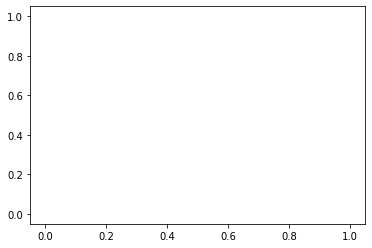

train Loss: 19.1242 Acc: 0.0041
val Loss: 19.5858 Acc: 0.0000

Epoch 1/4999
----------
train Loss: 7.8134 Acc: 0.2869
val Loss: 0.9462 Acc: 0.8497

Epoch 2/4999
----------
train Loss: 0.4799 Acc: 0.8975
val Loss: 0.3393 Acc: 0.9281

Epoch 3/4999
----------
train Loss: 0.2244 Acc: 0.9221
val Loss: 0.2584 Acc: 0.9608

Epoch 4/4999
----------
train Loss: 0.2424 Acc: 0.9303
val Loss: 0.2186 Acc: 0.9542

Epoch 5/4999
----------
train Loss: 0.1259 Acc: 0.9508
val Loss: 0.2063 Acc: 0.9542

Epoch 6/4999
----------
train Loss: 0.1079 Acc: 0.9590
val Loss: 0.2031 Acc: 0.9608

Epoch 7/4999
----------
train Loss: 0.0905 Acc: 0.9713
val Loss: 0.2086 Acc: 0.9477

Epoch 8/4999
----------
train Loss: 0.1380 Acc: 0.9631
val Loss: 0.1881 Acc: 0.9542

Epoch 9/4999
----------
train Loss: 0.1325 Acc: 0.9508
val Loss: 0.1886 Acc: 0.9608

Epoch 10/4999
----------
train Loss: 0.1060 Acc: 0.9672
val Loss: 0.1757 Acc: 0.9608

Epoch 11/4999
----------
train Loss: 0.0561 Acc: 0.9754
val Loss: 0.1784 Acc: 0.9608



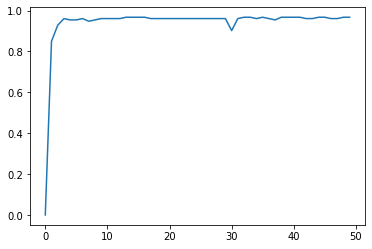

train Loss: 0.0692 Acc: 0.9713
val Loss: 0.1433 Acc: 0.9608

Epoch 51/4999
----------
train Loss: 0.0792 Acc: 0.9672
val Loss: 0.1417 Acc: 0.9608

Epoch 52/4999
----------
train Loss: 0.0531 Acc: 0.9795
val Loss: 0.1465 Acc: 0.9542

Epoch 53/4999
----------
train Loss: 0.0539 Acc: 0.9713
val Loss: 0.1623 Acc: 0.9542

Epoch 54/4999
----------
train Loss: 0.0423 Acc: 0.9918
val Loss: 0.1700 Acc: 0.9608

Epoch 55/4999
----------
train Loss: 0.0423 Acc: 0.9836
val Loss: 0.1709 Acc: 0.9542

Epoch 56/4999
----------
train Loss: 0.0525 Acc: 0.9877
val Loss: 0.1694 Acc: 0.9608

Epoch 57/4999
----------
train Loss: 0.0410 Acc: 0.9877
val Loss: 0.1697 Acc: 0.9608

Epoch 58/4999
----------
train Loss: 0.0393 Acc: 0.9877
val Loss: 0.1637 Acc: 0.9608

Epoch 59/4999
----------
train Loss: 0.0382 Acc: 0.9836
val Loss: 0.1674 Acc: 0.9608

Epoch 60/4999
----------
train Loss: 0.0602 Acc: 0.9713
val Loss: 0.1661 Acc: 0.9608

Epoch 61/4999
----------
train Loss: 0.0564 Acc: 0.9795
val Loss: 0.1692 Acc: 0

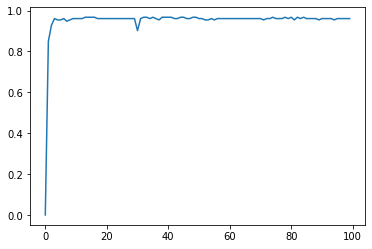

train Loss: 0.0294 Acc: 0.9918
val Loss: 0.1760 Acc: 0.9608

Epoch 101/4999
----------
train Loss: 0.0337 Acc: 0.9877
val Loss: 0.1748 Acc: 0.9608

Epoch 102/4999
----------
train Loss: 0.0318 Acc: 0.9836
val Loss: 0.1815 Acc: 0.9542

Epoch 103/4999
----------
train Loss: 0.0500 Acc: 0.9795
val Loss: 0.1878 Acc: 0.9542

Epoch 104/4999
----------
train Loss: 0.0550 Acc: 0.9795
val Loss: 0.1932 Acc: 0.9608

Epoch 105/4999
----------
train Loss: 0.0392 Acc: 0.9836
val Loss: 0.1881 Acc: 0.9477

Epoch 106/4999
----------
train Loss: 0.0676 Acc: 0.9672
val Loss: 0.1915 Acc: 0.9542

Epoch 107/4999
----------
train Loss: 0.0520 Acc: 0.9877
val Loss: 0.1968 Acc: 0.9542

Epoch 108/4999
----------
train Loss: 0.0229 Acc: 0.9918
val Loss: 0.2035 Acc: 0.9542

Epoch 109/4999
----------
train Loss: 0.0434 Acc: 0.9836
val Loss: 0.2038 Acc: 0.9542

Epoch 110/4999
----------
train Loss: 0.0753 Acc: 0.9754
val Loss: 0.2245 Acc: 0.9673

Epoch 111/4999
----------
train Loss: 0.0818 Acc: 0.9631
val Loss: 0.

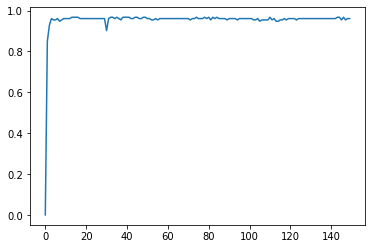

train Loss: 0.0398 Acc: 0.9918
val Loss: 0.1700 Acc: 0.9608

Epoch 151/4999
----------
train Loss: 0.0281 Acc: 0.9877
val Loss: 0.1685 Acc: 0.9608

Epoch 152/4999
----------
train Loss: 0.0379 Acc: 0.9918
val Loss: 0.1709 Acc: 0.9673

Epoch 153/4999
----------
train Loss: 0.0265 Acc: 0.9877
val Loss: 0.1714 Acc: 0.9673

Epoch 154/4999
----------
train Loss: 0.0392 Acc: 0.9836
val Loss: 0.1676 Acc: 0.9673

Epoch 155/4999
----------
train Loss: 0.0425 Acc: 0.9877
val Loss: 0.1698 Acc: 0.9673

Epoch 156/4999
----------
train Loss: 0.0250 Acc: 0.9918
val Loss: 0.1716 Acc: 0.9673

Epoch 157/4999
----------
train Loss: 0.0184 Acc: 1.0000
val Loss: 0.1744 Acc: 0.9542

Epoch 158/4999
----------
train Loss: 0.0246 Acc: 0.9877
val Loss: 0.1784 Acc: 0.9608

Epoch 159/4999
----------
train Loss: 0.0358 Acc: 0.9836
val Loss: 0.1814 Acc: 0.9608

Epoch 160/4999
----------
train Loss: 0.0603 Acc: 0.9672
val Loss: 0.1838 Acc: 0.9608

Epoch 161/4999
----------
train Loss: 0.0488 Acc: 0.9754
val Loss: 0.

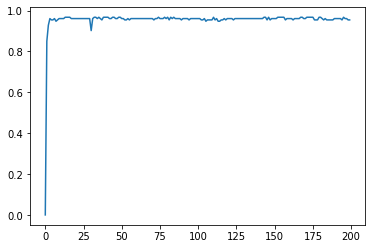

train Loss: 0.0599 Acc: 0.9836
val Loss: 0.1821 Acc: 0.9673

Epoch 201/4999
----------
train Loss: 0.0409 Acc: 0.9836
val Loss: 0.1766 Acc: 0.9608

Epoch 202/4999
----------
train Loss: 0.0154 Acc: 0.9959
val Loss: 0.1803 Acc: 0.9608

Epoch 203/4999
----------
train Loss: 0.0208 Acc: 0.9959
val Loss: 0.1863 Acc: 0.9673

Epoch 204/4999
----------
train Loss: 0.0328 Acc: 0.9877
val Loss: 0.1964 Acc: 0.9673

Epoch 205/4999
----------
train Loss: 0.0320 Acc: 0.9836
val Loss: 0.2035 Acc: 0.9673

Epoch 206/4999
----------
train Loss: 0.0546 Acc: 0.9836
val Loss: 0.1902 Acc: 0.9542

Epoch 207/4999
----------
train Loss: 0.0430 Acc: 0.9877
val Loss: 0.1873 Acc: 0.9542

Epoch 208/4999
----------
train Loss: 0.0356 Acc: 0.9836
val Loss: 0.1849 Acc: 0.9542

Epoch 209/4999
----------
train Loss: 0.0402 Acc: 0.9795
val Loss: 0.2026 Acc: 0.9542

Epoch 210/4999
----------
train Loss: 0.0441 Acc: 0.9877
val Loss: 0.1938 Acc: 0.9608

Epoch 211/4999
----------
train Loss: 0.0268 Acc: 0.9877
val Loss: 0.

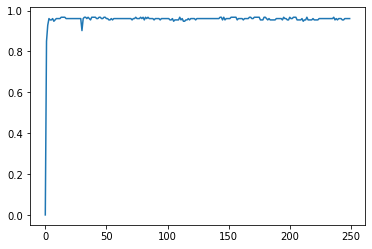

train Loss: 0.0100 Acc: 1.0000
val Loss: 0.2095 Acc: 0.9608

Epoch 251/4999
----------
train Loss: 0.0291 Acc: 0.9959
val Loss: 0.2128 Acc: 0.9608

Epoch 252/4999
----------
train Loss: 0.0203 Acc: 0.9959
val Loss: 0.2133 Acc: 0.9608

Epoch 253/4999
----------
train Loss: 0.0267 Acc: 0.9836
val Loss: 0.2127 Acc: 0.9608

Epoch 254/4999
----------
train Loss: 0.0685 Acc: 0.9754
val Loss: 0.2019 Acc: 0.9608

Epoch 255/4999
----------
train Loss: 0.0320 Acc: 0.9959
val Loss: 0.1979 Acc: 0.9673

Epoch 256/4999
----------
train Loss: 0.0156 Acc: 0.9959
val Loss: 0.1968 Acc: 0.9608

Epoch 257/4999
----------
train Loss: 0.0158 Acc: 0.9918
val Loss: 0.2045 Acc: 0.9673

Epoch 258/4999
----------
train Loss: 0.0093 Acc: 0.9959
val Loss: 0.2091 Acc: 0.9673

Epoch 259/4999
----------
train Loss: 0.0223 Acc: 0.9836
val Loss: 0.2087 Acc: 0.9673

Epoch 260/4999
----------
train Loss: 0.0188 Acc: 0.9877
val Loss: 0.2062 Acc: 0.9673

Epoch 261/4999
----------
train Loss: 0.0468 Acc: 0.9836
val Loss: 0.

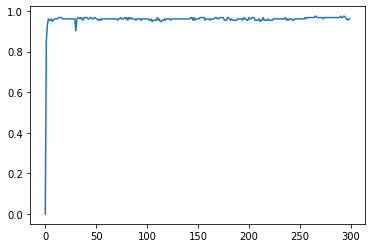

train Loss: 0.0430 Acc: 0.9877
val Loss: 0.2136 Acc: 0.9608

Epoch 301/4999
----------
train Loss: 0.0359 Acc: 0.9877
val Loss: 0.2085 Acc: 0.9673

Epoch 302/4999
----------
train Loss: 0.0336 Acc: 0.9795
val Loss: 0.2051 Acc: 0.9608

Epoch 303/4999
----------
train Loss: 0.0235 Acc: 0.9959
val Loss: 0.2017 Acc: 0.9542

Epoch 304/4999
----------
train Loss: 0.0264 Acc: 0.9918
val Loss: 0.1922 Acc: 0.9673

Epoch 305/4999
----------
train Loss: 0.0249 Acc: 0.9877
val Loss: 0.1918 Acc: 0.9542

Epoch 306/4999
----------
train Loss: 0.0265 Acc: 0.9918
val Loss: 0.1891 Acc: 0.9673

Epoch 307/4999
----------
train Loss: 0.0340 Acc: 0.9795
val Loss: 0.1929 Acc: 0.9673

Epoch 308/4999
----------
train Loss: 0.0416 Acc: 0.9877
val Loss: 0.1928 Acc: 0.9673

Epoch 309/4999
----------
train Loss: 0.0222 Acc: 0.9918
val Loss: 0.1967 Acc: 0.9673

Epoch 310/4999
----------
train Loss: 0.0534 Acc: 0.9754
val Loss: 0.2498 Acc: 0.9673

Epoch 311/4999
----------
train Loss: 0.0169 Acc: 0.9959
val Loss: 0.

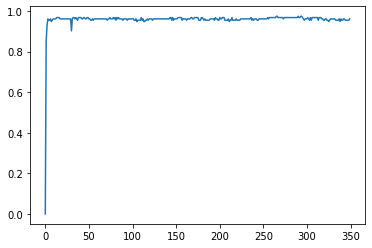

train Loss: 0.0116 Acc: 0.9959
val Loss: 0.2484 Acc: 0.9608

Epoch 351/4999
----------
train Loss: 0.0098 Acc: 0.9959
val Loss: 0.2507 Acc: 0.9608

Epoch 352/4999
----------
train Loss: 0.0259 Acc: 0.9959
val Loss: 0.2579 Acc: 0.9542

Epoch 353/4999
----------
train Loss: 0.0217 Acc: 0.9918
val Loss: 0.2715 Acc: 0.9673

Epoch 354/4999
----------
train Loss: 0.0295 Acc: 0.9877
val Loss: 0.2617 Acc: 0.9542

Epoch 355/4999
----------
train Loss: 0.0257 Acc: 0.9918
val Loss: 0.2555 Acc: 0.9542

Epoch 356/4999
----------
train Loss: 0.0142 Acc: 0.9959
val Loss: 0.2511 Acc: 0.9542

Epoch 357/4999
----------
train Loss: 0.0148 Acc: 0.9918
val Loss: 0.2554 Acc: 0.9542

Epoch 358/4999
----------
train Loss: 0.0121 Acc: 0.9959
val Loss: 0.2565 Acc: 0.9542

Epoch 359/4999
----------
train Loss: 0.0152 Acc: 0.9959
val Loss: 0.2568 Acc: 0.9542

Epoch 360/4999
----------
train Loss: 0.0185 Acc: 0.9918
val Loss: 0.2590 Acc: 0.9542

Epoch 361/4999
----------
train Loss: 0.0039 Acc: 1.0000
val Loss: 0.

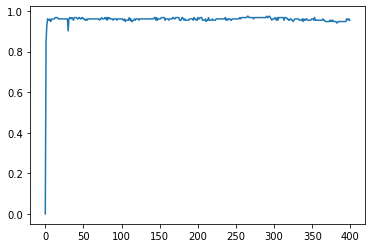

train Loss: 0.0055 Acc: 1.0000
val Loss: 0.2258 Acc: 0.9542

Epoch 401/4999
----------
train Loss: 0.0362 Acc: 0.9836
val Loss: 0.2353 Acc: 0.9477

Epoch 402/4999
----------
train Loss: 0.0304 Acc: 0.9959
val Loss: 0.2279 Acc: 0.9477

Epoch 403/4999
----------
train Loss: 0.0207 Acc: 0.9918
val Loss: 0.2075 Acc: 0.9673

Epoch 404/4999
----------
train Loss: 0.0373 Acc: 0.9836
val Loss: 0.1997 Acc: 0.9542

Epoch 405/4999
----------
train Loss: 0.0294 Acc: 0.9836
val Loss: 0.2150 Acc: 0.9477

Epoch 406/4999
----------
train Loss: 0.0398 Acc: 0.9877
val Loss: 0.2182 Acc: 0.9477

Epoch 407/4999
----------
train Loss: 0.0294 Acc: 0.9877
val Loss: 0.2147 Acc: 0.9542

Epoch 408/4999
----------
train Loss: 0.0158 Acc: 0.9918
val Loss: 0.2223 Acc: 0.9542

Epoch 409/4999
----------
train Loss: 0.0250 Acc: 0.9959
val Loss: 0.2208 Acc: 0.9542

Epoch 410/4999
----------
train Loss: 0.0138 Acc: 0.9959
val Loss: 0.2170 Acc: 0.9542

Epoch 411/4999
----------
train Loss: 0.0153 Acc: 0.9959
val Loss: 0.

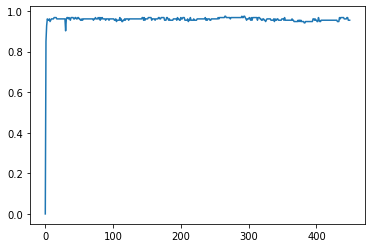

train Loss: 0.0367 Acc: 0.9795
val Loss: 0.2504 Acc: 0.9542

Epoch 451/4999
----------
train Loss: 0.0035 Acc: 1.0000
val Loss: 0.2519 Acc: 0.9542

Epoch 452/4999
----------
train Loss: 0.0097 Acc: 0.9959
val Loss: 0.2536 Acc: 0.9542

Epoch 453/4999
----------
train Loss: 0.0195 Acc: 0.9959
val Loss: 0.2581 Acc: 0.9542

Epoch 454/4999
----------
train Loss: 0.0099 Acc: 0.9959
val Loss: 0.2619 Acc: 0.9542

Epoch 455/4999
----------
train Loss: 0.0099 Acc: 0.9959
val Loss: 0.2650 Acc: 0.9542

Epoch 456/4999
----------
train Loss: 0.0129 Acc: 0.9959
val Loss: 0.2704 Acc: 0.9542

Epoch 457/4999
----------
train Loss: 0.0377 Acc: 0.9836
val Loss: 0.2742 Acc: 0.9673

Epoch 458/4999
----------
train Loss: 0.0111 Acc: 1.0000
val Loss: 0.2796 Acc: 0.9673

Epoch 459/4999
----------
train Loss: 0.0295 Acc: 0.9918
val Loss: 0.2704 Acc: 0.9673

Epoch 460/4999
----------
train Loss: 0.0180 Acc: 0.9877
val Loss: 0.2668 Acc: 0.9608

Epoch 461/4999
----------
train Loss: 0.0044 Acc: 1.0000
val Loss: 0.

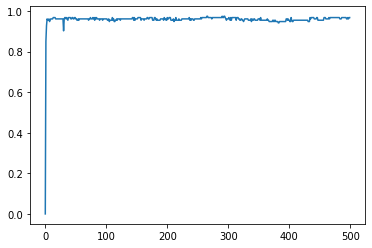

train Loss: 0.0127 Acc: 0.9959
val Loss: 0.2483 Acc: 0.9673

Epoch 501/4999
----------
train Loss: 0.0394 Acc: 0.9918
val Loss: 0.2541 Acc: 0.9542

Epoch 502/4999
----------
train Loss: 0.0049 Acc: 1.0000
val Loss: 0.2847 Acc: 0.9542

Epoch 503/4999
----------
train Loss: 0.0122 Acc: 0.9918
val Loss: 0.2784 Acc: 0.9608

Epoch 504/4999
----------
train Loss: 0.0119 Acc: 0.9959
val Loss: 0.2700 Acc: 0.9608

Epoch 505/4999
----------
train Loss: 0.0077 Acc: 0.9959
val Loss: 0.2716 Acc: 0.9673

Epoch 506/4999
----------
train Loss: 0.0584 Acc: 0.9795
val Loss: 0.2730 Acc: 0.9673

Epoch 507/4999
----------
train Loss: 0.0155 Acc: 0.9918
val Loss: 0.2707 Acc: 0.9673

Epoch 508/4999
----------
train Loss: 0.0055 Acc: 1.0000
val Loss: 0.2695 Acc: 0.9673

Epoch 509/4999
----------
train Loss: 0.0137 Acc: 0.9959
val Loss: 0.2732 Acc: 0.9673

Epoch 510/4999
----------
train Loss: 0.0140 Acc: 0.9959
val Loss: 0.2761 Acc: 0.9673

Epoch 511/4999
----------
train Loss: 0.0113 Acc: 0.9959
val Loss: 0.

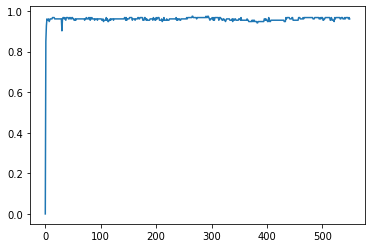

train Loss: 0.0192 Acc: 0.9918
val Loss: 0.2612 Acc: 0.9608

Epoch 551/4999
----------
train Loss: 0.0224 Acc: 0.9918
val Loss: 0.2622 Acc: 0.9673

Epoch 552/4999
----------
train Loss: 0.0114 Acc: 0.9959
val Loss: 0.2696 Acc: 0.9673

Epoch 553/4999
----------
train Loss: 0.0234 Acc: 0.9877
val Loss: 0.2685 Acc: 0.9673

Epoch 554/4999
----------
train Loss: 0.0053 Acc: 1.0000
val Loss: 0.2696 Acc: 0.9608

Epoch 555/4999
----------
train Loss: 0.0111 Acc: 0.9959
val Loss: 0.2684 Acc: 0.9608

Epoch 556/4999
----------
train Loss: 0.0147 Acc: 0.9918
val Loss: 0.2680 Acc: 0.9608

Epoch 557/4999
----------
train Loss: 0.0172 Acc: 0.9918
val Loss: 0.2703 Acc: 0.9608

Epoch 558/4999
----------
train Loss: 0.0094 Acc: 0.9959
val Loss: 0.2791 Acc: 0.9673

Epoch 559/4999
----------
train Loss: 0.0136 Acc: 0.9959
val Loss: 0.2839 Acc: 0.9673

Epoch 560/4999
----------
train Loss: 0.0117 Acc: 0.9959
val Loss: 0.2848 Acc: 0.9673

Epoch 561/4999
----------
train Loss: 0.0192 Acc: 0.9918
val Loss: 0.

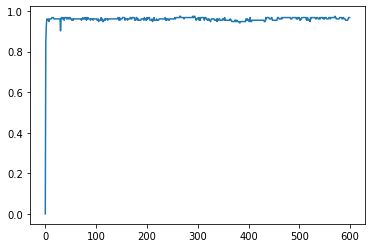

train Loss: 0.0177 Acc: 0.9877
val Loss: 0.2596 Acc: 0.9673

Epoch 601/4999
----------
train Loss: 0.0177 Acc: 0.9959
val Loss: 0.2581 Acc: 0.9673

Epoch 602/4999
----------
train Loss: 0.0410 Acc: 0.9795
val Loss: 0.2608 Acc: 0.9673

Epoch 603/4999
----------
train Loss: 0.0194 Acc: 0.9918
val Loss: 0.2629 Acc: 0.9673

Epoch 604/4999
----------
train Loss: 0.0142 Acc: 0.9918
val Loss: 0.2701 Acc: 0.9608

Epoch 605/4999
----------
train Loss: 0.0345 Acc: 0.9959
val Loss: 0.2672 Acc: 0.9608

Epoch 606/4999
----------
train Loss: 0.0047 Acc: 1.0000
val Loss: 0.2633 Acc: 0.9608

Epoch 607/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.2637 Acc: 0.9608

Epoch 608/4999
----------
train Loss: 0.0129 Acc: 0.9959
val Loss: 0.2603 Acc: 0.9608

Epoch 609/4999
----------
train Loss: 0.0085 Acc: 0.9959
val Loss: 0.2619 Acc: 0.9608

Epoch 610/4999
----------
train Loss: 0.0306 Acc: 0.9877
val Loss: 0.2634 Acc: 0.9608

Epoch 611/4999
----------
train Loss: 0.0080 Acc: 1.0000
val Loss: 0.

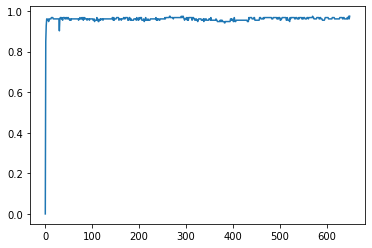

train Loss: 0.0047 Acc: 1.0000
val Loss: 0.2519 Acc: 0.9739

Epoch 651/4999
----------
train Loss: 0.0208 Acc: 0.9918
val Loss: 0.2496 Acc: 0.9608

Epoch 652/4999
----------
train Loss: 0.0202 Acc: 0.9877
val Loss: 0.2602 Acc: 0.9608

Epoch 653/4999
----------
train Loss: 0.0107 Acc: 0.9959
val Loss: 0.2542 Acc: 0.9673

Epoch 654/4999
----------
train Loss: 0.0179 Acc: 0.9959
val Loss: 0.2594 Acc: 0.9673

Epoch 655/4999
----------
train Loss: 0.0223 Acc: 0.9959
val Loss: 0.2581 Acc: 0.9673

Epoch 656/4999
----------
train Loss: 0.0042 Acc: 1.0000
val Loss: 0.2587 Acc: 0.9673

Epoch 657/4999
----------
train Loss: 0.0279 Acc: 0.9877
val Loss: 0.2547 Acc: 0.9673

Epoch 658/4999
----------
train Loss: 0.0220 Acc: 0.9959
val Loss: 0.2490 Acc: 0.9673

Epoch 659/4999
----------
train Loss: 0.0150 Acc: 0.9959
val Loss: 0.2474 Acc: 0.9673

Epoch 660/4999
----------
train Loss: 0.0030 Acc: 1.0000
val Loss: 0.2458 Acc: 0.9673

Epoch 661/4999
----------
train Loss: 0.0150 Acc: 0.9918
val Loss: 0.

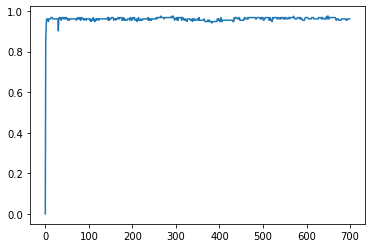

train Loss: 0.0267 Acc: 0.9877
val Loss: 0.2759 Acc: 0.9608

Epoch 701/4999
----------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.2753 Acc: 0.9608

Epoch 702/4999
----------
train Loss: 0.0168 Acc: 0.9959
val Loss: 0.2727 Acc: 0.9608

Epoch 703/4999
----------
train Loss: 0.0161 Acc: 0.9959
val Loss: 0.2681 Acc: 0.9608

Epoch 704/4999
----------
train Loss: 0.0230 Acc: 0.9918
val Loss: 0.2676 Acc: 0.9608

Epoch 705/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.2689 Acc: 0.9608

Epoch 706/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.2691 Acc: 0.9608

Epoch 707/4999
----------
train Loss: 0.0045 Acc: 1.0000
val Loss: 0.2698 Acc: 0.9608

Epoch 708/4999
----------
train Loss: 0.0214 Acc: 0.9918
val Loss: 0.2709 Acc: 0.9608

Epoch 709/4999
----------
train Loss: 0.0102 Acc: 0.9918
val Loss: 0.2717 Acc: 0.9608

Epoch 710/4999
----------
train Loss: 0.0138 Acc: 0.9918
val Loss: 0.2722 Acc: 0.9608

Epoch 711/4999
----------
train Loss: 0.0048 Acc: 1.0000
val Loss: 0.

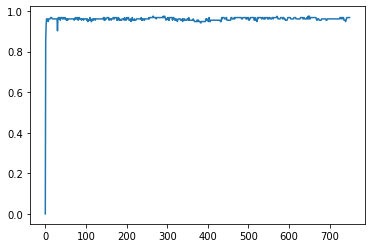

train Loss: 0.0083 Acc: 1.0000
val Loss: 0.2727 Acc: 0.9673

Epoch 751/4999
----------
train Loss: 0.0073 Acc: 0.9959
val Loss: 0.2731 Acc: 0.9608

Epoch 752/4999
----------
train Loss: 0.0081 Acc: 1.0000
val Loss: 0.2716 Acc: 0.9477

Epoch 753/4999
----------
train Loss: 0.0202 Acc: 0.9918
val Loss: 0.2564 Acc: 0.9608

Epoch 754/4999
----------
train Loss: 0.0112 Acc: 0.9918
val Loss: 0.2572 Acc: 0.9673

Epoch 755/4999
----------
train Loss: 0.0172 Acc: 0.9918
val Loss: 0.2534 Acc: 0.9673

Epoch 756/4999
----------
train Loss: 0.0076 Acc: 0.9959
val Loss: 0.2520 Acc: 0.9673

Epoch 757/4999
----------
train Loss: 0.0119 Acc: 0.9959
val Loss: 0.2535 Acc: 0.9608

Epoch 758/4999
----------
train Loss: 0.0084 Acc: 1.0000
val Loss: 0.2580 Acc: 0.9608

Epoch 759/4999
----------
train Loss: 0.0151 Acc: 0.9918
val Loss: 0.2582 Acc: 0.9608

Epoch 760/4999
----------
train Loss: 0.0141 Acc: 0.9959
val Loss: 0.2588 Acc: 0.9608

Epoch 761/4999
----------
train Loss: 0.0218 Acc: 0.9918
val Loss: 0.

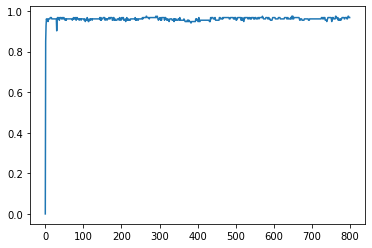

train Loss: 0.0025 Acc: 1.0000
val Loss: 0.2608 Acc: 0.9673

Epoch 801/4999
----------
train Loss: 0.0343 Acc: 0.9877
val Loss: 0.2641 Acc: 0.9673

Epoch 802/4999
----------
train Loss: 0.0206 Acc: 0.9877
val Loss: 0.2724 Acc: 0.9673

Epoch 803/4999
----------
train Loss: 0.0128 Acc: 0.9959
val Loss: 0.2757 Acc: 0.9608

Epoch 804/4999
----------
train Loss: 0.0037 Acc: 1.0000
val Loss: 0.2790 Acc: 0.9542

Epoch 805/4999
----------
train Loss: 0.0065 Acc: 1.0000
val Loss: 0.2802 Acc: 0.9608

Epoch 806/4999
----------
train Loss: 0.0137 Acc: 0.9918
val Loss: 0.2857 Acc: 0.9542

Epoch 807/4999
----------
train Loss: 0.0072 Acc: 1.0000
val Loss: 0.2935 Acc: 0.9542

Epoch 808/4999
----------
train Loss: 0.0036 Acc: 1.0000
val Loss: 0.2943 Acc: 0.9542

Epoch 809/4999
----------
train Loss: 0.0325 Acc: 0.9836
val Loss: 0.2874 Acc: 0.9608

Epoch 810/4999
----------
train Loss: 0.0404 Acc: 0.9918
val Loss: 0.2830 Acc: 0.9608

Epoch 811/4999
----------
train Loss: 0.0361 Acc: 0.9877
val Loss: 0.

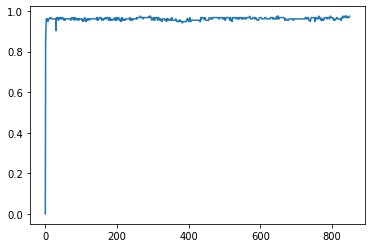

train Loss: 0.0252 Acc: 0.9959
val Loss: 0.2558 Acc: 0.9739

Epoch 851/4999
----------
train Loss: 0.0129 Acc: 0.9877
val Loss: 0.2453 Acc: 0.9673

Epoch 852/4999
----------
train Loss: 0.0041 Acc: 1.0000
val Loss: 0.2461 Acc: 0.9673

Epoch 853/4999
----------
train Loss: 0.0140 Acc: 0.9918
val Loss: 0.2456 Acc: 0.9673

Epoch 854/4999
----------
train Loss: 0.0104 Acc: 0.9959
val Loss: 0.2448 Acc: 0.9673

Epoch 855/4999
----------
train Loss: 0.0091 Acc: 0.9959
val Loss: 0.2471 Acc: 0.9673

Epoch 856/4999
----------
train Loss: 0.0022 Acc: 1.0000
val Loss: 0.2476 Acc: 0.9673

Epoch 857/4999
----------
train Loss: 0.0282 Acc: 0.9877
val Loss: 0.2455 Acc: 0.9673

Epoch 858/4999
----------
train Loss: 0.0042 Acc: 1.0000
val Loss: 0.2447 Acc: 0.9673

Epoch 859/4999
----------
train Loss: 0.0412 Acc: 0.9918
val Loss: 0.2443 Acc: 0.9673

Epoch 860/4999
----------
train Loss: 0.0063 Acc: 0.9959
val Loss: 0.2425 Acc: 0.9673

Epoch 861/4999
----------
train Loss: 0.0347 Acc: 0.9877
val Loss: 0.

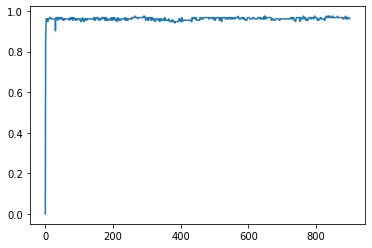

train Loss: 0.0085 Acc: 1.0000
val Loss: 0.2695 Acc: 0.9608

Epoch 901/4999
----------
train Loss: 0.0078 Acc: 1.0000
val Loss: 0.2732 Acc: 0.9673

Epoch 902/4999
----------
train Loss: 0.0162 Acc: 0.9918
val Loss: 0.2699 Acc: 0.9673

Epoch 903/4999
----------
train Loss: 0.0054 Acc: 1.0000
val Loss: 0.2691 Acc: 0.9673

Epoch 904/4999
----------
train Loss: 0.0092 Acc: 0.9959
val Loss: 0.2692 Acc: 0.9673

Epoch 905/4999
----------
train Loss: 0.0081 Acc: 0.9959
val Loss: 0.2679 Acc: 0.9608

Epoch 906/4999
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.2665 Acc: 0.9608

Epoch 907/4999
----------
train Loss: 0.0127 Acc: 0.9918
val Loss: 0.2697 Acc: 0.9673

Epoch 908/4999
----------
train Loss: 0.0070 Acc: 0.9959
val Loss: 0.2726 Acc: 0.9673

Epoch 909/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.2754 Acc: 0.9673

Epoch 910/4999
----------
train Loss: 0.0145 Acc: 0.9959
val Loss: 0.2765 Acc: 0.9673

Epoch 911/4999
----------
train Loss: 0.0073 Acc: 0.9959
val Loss: 0.

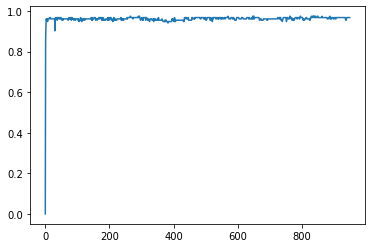

train Loss: 0.0093 Acc: 0.9959
val Loss: 0.2816 Acc: 0.9673

Epoch 951/4999
----------
train Loss: 0.0109 Acc: 0.9959
val Loss: 0.2807 Acc: 0.9673

Epoch 952/4999
----------
train Loss: 0.0073 Acc: 0.9959
val Loss: 0.2809 Acc: 0.9673

Epoch 953/4999
----------
train Loss: 0.0048 Acc: 1.0000
val Loss: 0.2815 Acc: 0.9673

Epoch 954/4999
----------
train Loss: 0.0027 Acc: 1.0000
val Loss: 0.2830 Acc: 0.9673

Epoch 955/4999
----------
train Loss: 0.0248 Acc: 0.9918
val Loss: 0.2854 Acc: 0.9673

Epoch 956/4999
----------
train Loss: 0.0229 Acc: 0.9918
val Loss: 0.2875 Acc: 0.9673

Epoch 957/4999
----------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.2873 Acc: 0.9673

Epoch 958/4999
----------
train Loss: 0.0336 Acc: 0.9959
val Loss: 0.2857 Acc: 0.9673

Epoch 959/4999
----------
train Loss: 0.0099 Acc: 0.9959
val Loss: 0.2827 Acc: 0.9673

Epoch 960/4999
----------
train Loss: 0.0145 Acc: 0.9959
val Loss: 0.2827 Acc: 0.9673

Epoch 961/4999
----------
train Loss: 0.0105 Acc: 0.9959
val Loss: 0.

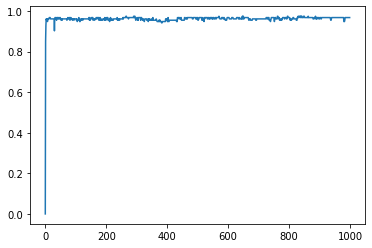

train Loss: 0.0099 Acc: 0.9959
val Loss: 0.2647 Acc: 0.9673

Epoch 1001/4999
----------
train Loss: 0.0061 Acc: 1.0000
val Loss: 0.2662 Acc: 0.9608

Epoch 1002/4999
----------
train Loss: 0.0194 Acc: 0.9959
val Loss: 0.2659 Acc: 0.9608

Epoch 1003/4999
----------
train Loss: 0.0071 Acc: 1.0000
val Loss: 0.2665 Acc: 0.9608

Epoch 1004/4999
----------
train Loss: 0.0054 Acc: 1.0000
val Loss: 0.2681 Acc: 0.9673

Epoch 1005/4999
----------
train Loss: 0.0311 Acc: 0.9918
val Loss: 0.2702 Acc: 0.9673

Epoch 1006/4999
----------
train Loss: 0.0464 Acc: 0.9836
val Loss: 0.2697 Acc: 0.9673

Epoch 1007/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.2688 Acc: 0.9608

Epoch 1008/4999
----------
train Loss: 0.0144 Acc: 0.9959
val Loss: 0.2683 Acc: 0.9673

Epoch 1009/4999
----------
train Loss: 0.0272 Acc: 0.9918
val Loss: 0.2674 Acc: 0.9673

Epoch 1010/4999
----------
train Loss: 0.0148 Acc: 0.9959
val Loss: 0.2686 Acc: 0.9608

Epoch 1011/4999
----------
train Loss: 0.0186 Acc: 0.9918
v

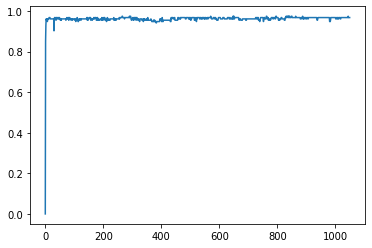

train Loss: 0.0095 Acc: 0.9959
val Loss: 0.2784 Acc: 0.9673

Epoch 1051/4999
----------
train Loss: 0.0039 Acc: 0.9959
val Loss: 0.2771 Acc: 0.9673

Epoch 1052/4999
----------
train Loss: 0.0280 Acc: 0.9918
val Loss: 0.2785 Acc: 0.9673

Epoch 1053/4999
----------
train Loss: 0.0044 Acc: 1.0000
val Loss: 0.2799 Acc: 0.9673

Epoch 1054/4999
----------
train Loss: 0.0114 Acc: 0.9959
val Loss: 0.2745 Acc: 0.9608

Epoch 1055/4999
----------
train Loss: 0.0133 Acc: 0.9959
val Loss: 0.2704 Acc: 0.9608

Epoch 1056/4999
----------
train Loss: 0.0060 Acc: 0.9959
val Loss: 0.2656 Acc: 0.9673

Epoch 1057/4999
----------
train Loss: 0.0092 Acc: 0.9918
val Loss: 0.2675 Acc: 0.9673

Epoch 1058/4999
----------
train Loss: 0.0294 Acc: 0.9959
val Loss: 0.2678 Acc: 0.9673

Epoch 1059/4999
----------
train Loss: 0.0101 Acc: 0.9959
val Loss: 0.2610 Acc: 0.9673

Epoch 1060/4999
----------
train Loss: 0.0139 Acc: 0.9918
val Loss: 0.2574 Acc: 0.9673

Epoch 1061/4999
----------
train Loss: 0.0014 Acc: 1.0000
v

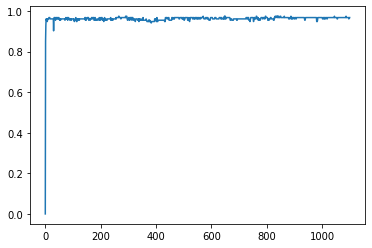

train Loss: 0.0042 Acc: 1.0000
val Loss: 0.3000 Acc: 0.9673

Epoch 1101/4999
----------
train Loss: 0.0066 Acc: 1.0000
val Loss: 0.2983 Acc: 0.9673

Epoch 1102/4999
----------
train Loss: 0.0224 Acc: 0.9918
val Loss: 0.2972 Acc: 0.9673

Epoch 1103/4999
----------
train Loss: 0.0197 Acc: 0.9918
val Loss: 0.3012 Acc: 0.9673

Epoch 1104/4999
----------
train Loss: 0.0156 Acc: 0.9918
val Loss: 0.3030 Acc: 0.9673

Epoch 1105/4999
----------
train Loss: 0.0393 Acc: 0.9877
val Loss: 0.2970 Acc: 0.9673

Epoch 1106/4999
----------
train Loss: 0.0252 Acc: 0.9918
val Loss: 0.2970 Acc: 0.9673

Epoch 1107/4999
----------
train Loss: 0.0256 Acc: 0.9877
val Loss: 0.2904 Acc: 0.9673

Epoch 1108/4999
----------
train Loss: 0.0122 Acc: 0.9959
val Loss: 0.2787 Acc: 0.9739

Epoch 1109/4999
----------
train Loss: 0.0061 Acc: 1.0000
val Loss: 0.2766 Acc: 0.9739

Epoch 1110/4999
----------
train Loss: 0.0180 Acc: 0.9959
val Loss: 0.2757 Acc: 0.9739

Epoch 1111/4999
----------
train Loss: 0.0149 Acc: 0.9918
v

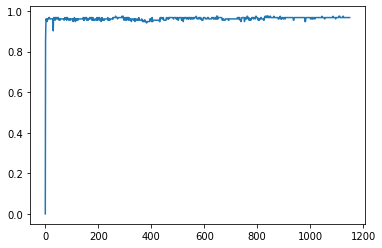

train Loss: 0.0102 Acc: 0.9959
val Loss: 0.2708 Acc: 0.9673

Epoch 1151/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.2702 Acc: 0.9673

Epoch 1152/4999
----------
train Loss: 0.0027 Acc: 1.0000
val Loss: 0.2694 Acc: 0.9673

Epoch 1153/4999
----------
train Loss: 0.0163 Acc: 0.9918
val Loss: 0.2709 Acc: 0.9608

Epoch 1154/4999
----------
train Loss: 0.0054 Acc: 0.9959
val Loss: 0.2726 Acc: 0.9608

Epoch 1155/4999
----------
train Loss: 0.0189 Acc: 0.9959
val Loss: 0.2693 Acc: 0.9673

Epoch 1156/4999
----------
train Loss: 0.0091 Acc: 0.9959
val Loss: 0.2688 Acc: 0.9673

Epoch 1157/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.2700 Acc: 0.9673

Epoch 1158/4999
----------
train Loss: 0.0048 Acc: 1.0000
val Loss: 0.2715 Acc: 0.9673

Epoch 1159/4999
----------
train Loss: 0.0052 Acc: 1.0000
val Loss: 0.2711 Acc: 0.9673

Epoch 1160/4999
----------
train Loss: 0.0163 Acc: 0.9959
val Loss: 0.2707 Acc: 0.9673

Epoch 1161/4999
----------
train Loss: 0.0148 Acc: 0.9918
v

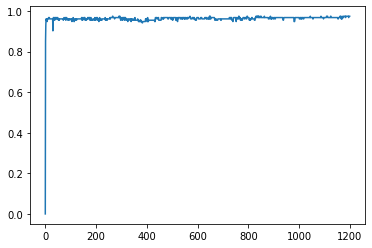

train Loss: 0.0066 Acc: 0.9959
val Loss: 0.2588 Acc: 0.9739

Epoch 1201/4999
----------
train Loss: 0.0109 Acc: 1.0000
val Loss: 0.2579 Acc: 0.9739

Epoch 1202/4999
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.2586 Acc: 0.9739

Epoch 1203/4999
----------
train Loss: 0.0091 Acc: 0.9959
val Loss: 0.2589 Acc: 0.9739

Epoch 1204/4999
----------
train Loss: 0.0309 Acc: 0.9918
val Loss: 0.2575 Acc: 0.9739

Epoch 1205/4999
----------
train Loss: 0.0050 Acc: 1.0000
val Loss: 0.2566 Acc: 0.9739

Epoch 1206/4999
----------
train Loss: 0.0065 Acc: 1.0000
val Loss: 0.2572 Acc: 0.9739

Epoch 1207/4999
----------
train Loss: 0.0113 Acc: 0.9918
val Loss: 0.2541 Acc: 0.9673

Epoch 1208/4999
----------
train Loss: 0.0234 Acc: 0.9918
val Loss: 0.2518 Acc: 0.9673

Epoch 1209/4999
----------
train Loss: 0.0091 Acc: 0.9959
val Loss: 0.2524 Acc: 0.9739

Epoch 1210/4999
----------
train Loss: 0.0100 Acc: 0.9959
val Loss: 0.2548 Acc: 0.9739

Epoch 1211/4999
----------
train Loss: 0.0011 Acc: 1.0000
v

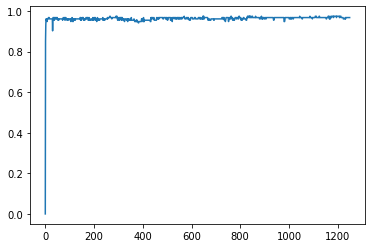

train Loss: 0.0038 Acc: 1.0000
val Loss: 0.2607 Acc: 0.9673

Epoch 1251/4999
----------
train Loss: 0.0056 Acc: 1.0000
val Loss: 0.2630 Acc: 0.9673

Epoch 1252/4999
----------
train Loss: 0.0100 Acc: 0.9959
val Loss: 0.2629 Acc: 0.9673

Epoch 1253/4999
----------
train Loss: 0.0095 Acc: 0.9959
val Loss: 0.2613 Acc: 0.9673

Epoch 1254/4999
----------
train Loss: 0.0201 Acc: 0.9836
val Loss: 0.2619 Acc: 0.9673

Epoch 1255/4999
----------
train Loss: 0.0062 Acc: 1.0000
val Loss: 0.2641 Acc: 0.9673

Epoch 1256/4999
----------
train Loss: 0.0167 Acc: 0.9959
val Loss: 0.2644 Acc: 0.9673

Epoch 1257/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.2643 Acc: 0.9673

Epoch 1258/4999
----------
train Loss: 0.0132 Acc: 0.9959
val Loss: 0.2607 Acc: 0.9673

Epoch 1259/4999
----------
train Loss: 0.0035 Acc: 1.0000
val Loss: 0.2600 Acc: 0.9673

Epoch 1260/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.2596 Acc: 0.9673

Epoch 1261/4999
----------
train Loss: 0.0086 Acc: 0.9959
v

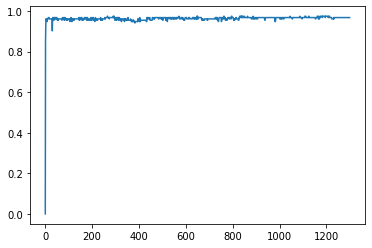

train Loss: 0.0035 Acc: 1.0000
val Loss: 0.2837 Acc: 0.9673

Epoch 1301/4999
----------
train Loss: 0.0042 Acc: 0.9959
val Loss: 0.2810 Acc: 0.9673

Epoch 1302/4999
----------
train Loss: 0.0382 Acc: 0.9918
val Loss: 0.2558 Acc: 0.9673

Epoch 1303/4999
----------
train Loss: 0.0048 Acc: 1.0000
val Loss: 0.2465 Acc: 0.9673

Epoch 1304/4999
----------
train Loss: 0.0098 Acc: 0.9918
val Loss: 0.2350 Acc: 0.9739

Epoch 1305/4999
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.2318 Acc: 0.9739

Epoch 1306/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.2312 Acc: 0.9739

Epoch 1307/4999
----------
train Loss: 0.0171 Acc: 0.9959
val Loss: 0.2299 Acc: 0.9673

Epoch 1308/4999
----------
train Loss: 0.0078 Acc: 0.9959
val Loss: 0.2325 Acc: 0.9673

Epoch 1309/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.2359 Acc: 0.9673

Epoch 1310/4999
----------
train Loss: 0.0096 Acc: 0.9959
val Loss: 0.2384 Acc: 0.9673

Epoch 1311/4999
----------
train Loss: 0.0416 Acc: 0.9836
v

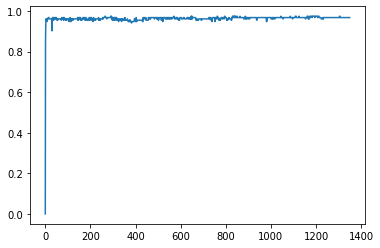

train Loss: 0.0106 Acc: 0.9959
val Loss: 0.2702 Acc: 0.9673

Epoch 1351/4999
----------
train Loss: 0.0147 Acc: 0.9918
val Loss: 0.2670 Acc: 0.9673

Epoch 1352/4999
----------
train Loss: 0.0313 Acc: 0.9877
val Loss: 0.2707 Acc: 0.9673

Epoch 1353/4999
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.2731 Acc: 0.9673

Epoch 1354/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.2749 Acc: 0.9673

Epoch 1355/4999
----------
train Loss: 0.0076 Acc: 0.9959
val Loss: 0.2763 Acc: 0.9673

Epoch 1356/4999
----------
train Loss: 0.0108 Acc: 0.9959
val Loss: 0.2778 Acc: 0.9608

Epoch 1357/4999
----------
train Loss: 0.0214 Acc: 0.9918
val Loss: 0.2777 Acc: 0.9673

Epoch 1358/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.2787 Acc: 0.9673

Epoch 1359/4999
----------
train Loss: 0.0199 Acc: 0.9877
val Loss: 0.2754 Acc: 0.9608

Epoch 1360/4999
----------
train Loss: 0.0091 Acc: 0.9959
val Loss: 0.2740 Acc: 0.9673

Epoch 1361/4999
----------
train Loss: 0.0123 Acc: 0.9959
v

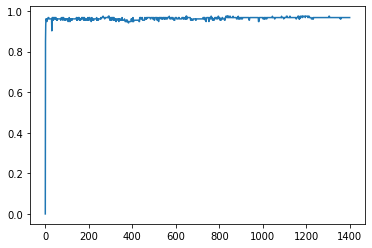

train Loss: 0.0020 Acc: 1.0000
val Loss: 0.2729 Acc: 0.9673

Epoch 1401/4999
----------
train Loss: 0.0153 Acc: 0.9918
val Loss: 0.2761 Acc: 0.9673

Epoch 1402/4999
----------
train Loss: 0.0105 Acc: 0.9918
val Loss: 0.2714 Acc: 0.9673

Epoch 1403/4999
----------
train Loss: 0.0022 Acc: 1.0000
val Loss: 0.2695 Acc: 0.9673

Epoch 1404/4999
----------
train Loss: 0.0126 Acc: 0.9959
val Loss: 0.2721 Acc: 0.9673

Epoch 1405/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.2776 Acc: 0.9673

Epoch 1406/4999
----------
train Loss: 0.0061 Acc: 0.9959
val Loss: 0.2800 Acc: 0.9673

Epoch 1407/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.2803 Acc: 0.9673

Epoch 1408/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.2801 Acc: 0.9673

Epoch 1409/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.2797 Acc: 0.9673

Epoch 1410/4999
----------
train Loss: 0.0096 Acc: 0.9959
val Loss: 0.2795 Acc: 0.9673

Epoch 1411/4999
----------
train Loss: 0.0040 Acc: 1.0000
v

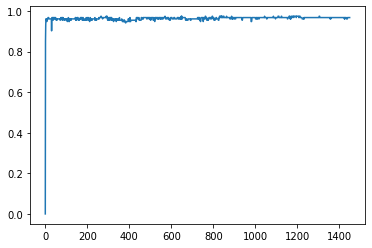

train Loss: 0.0057 Acc: 0.9959
val Loss: 0.2907 Acc: 0.9673

Epoch 1451/4999
----------
train Loss: 0.0168 Acc: 0.9959
val Loss: 0.2918 Acc: 0.9673

Epoch 1452/4999
----------
train Loss: 0.0044 Acc: 1.0000
val Loss: 0.2881 Acc: 0.9673

Epoch 1453/4999
----------
train Loss: 0.0221 Acc: 0.9959
val Loss: 0.2912 Acc: 0.9673

Epoch 1454/4999
----------
train Loss: 0.0173 Acc: 0.9918
val Loss: 0.2880 Acc: 0.9673

Epoch 1455/4999
----------
train Loss: 0.0065 Acc: 0.9959
val Loss: 0.2807 Acc: 0.9673

Epoch 1456/4999
----------
train Loss: 0.0080 Acc: 0.9959
val Loss: 0.2803 Acc: 0.9673

Epoch 1457/4999
----------
train Loss: 0.0068 Acc: 0.9959
val Loss: 0.2778 Acc: 0.9673

Epoch 1458/4999
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.2779 Acc: 0.9673

Epoch 1459/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.2787 Acc: 0.9673

Epoch 1460/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.2793 Acc: 0.9673

Epoch 1461/4999
----------
train Loss: 0.0056 Acc: 1.0000
v

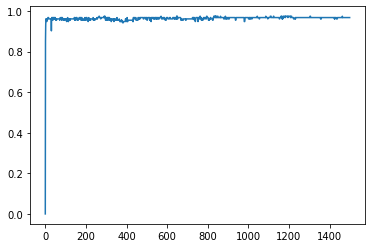

train Loss: 0.0021 Acc: 1.0000
val Loss: 0.2934 Acc: 0.9673

Epoch 1501/4999
----------
train Loss: 0.0075 Acc: 0.9959
val Loss: 0.2905 Acc: 0.9673

Epoch 1502/4999
----------
train Loss: 0.0179 Acc: 0.9918
val Loss: 0.2926 Acc: 0.9673

Epoch 1503/4999
----------
train Loss: 0.0087 Acc: 0.9959
val Loss: 0.2989 Acc: 0.9673

Epoch 1504/4999
----------
train Loss: 0.0049 Acc: 0.9959
val Loss: 0.3051 Acc: 0.9673

Epoch 1505/4999
----------
train Loss: 0.0077 Acc: 0.9959
val Loss: 0.3088 Acc: 0.9673

Epoch 1506/4999
----------
train Loss: 0.0071 Acc: 0.9959
val Loss: 0.3082 Acc: 0.9673

Epoch 1507/4999
----------
train Loss: 0.0116 Acc: 0.9959
val Loss: 0.3043 Acc: 0.9673

Epoch 1508/4999
----------
train Loss: 0.0079 Acc: 0.9959
val Loss: 0.3065 Acc: 0.9673

Epoch 1509/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.3067 Acc: 0.9673

Epoch 1510/4999
----------
train Loss: 0.0038 Acc: 1.0000
val Loss: 0.3066 Acc: 0.9673

Epoch 1511/4999
----------
train Loss: 0.0071 Acc: 0.9959
v

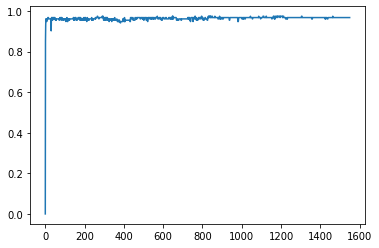

train Loss: 0.0011 Acc: 1.0000
val Loss: 0.2928 Acc: 0.9673

Epoch 1551/4999
----------
train Loss: 0.0038 Acc: 1.0000
val Loss: 0.2948 Acc: 0.9673

Epoch 1552/4999
----------
train Loss: 0.0122 Acc: 0.9959
val Loss: 0.2962 Acc: 0.9673

Epoch 1553/4999
----------
train Loss: 0.0150 Acc: 0.9959
val Loss: 0.2885 Acc: 0.9673

Epoch 1554/4999
----------
train Loss: 0.0079 Acc: 0.9959
val Loss: 0.2885 Acc: 0.9673

Epoch 1555/4999
----------
train Loss: 0.0081 Acc: 1.0000
val Loss: 0.2875 Acc: 0.9673

Epoch 1556/4999
----------
train Loss: 0.0022 Acc: 1.0000
val Loss: 0.2886 Acc: 0.9673

Epoch 1557/4999
----------
train Loss: 0.0146 Acc: 0.9918
val Loss: 0.2878 Acc: 0.9673

Epoch 1558/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.2908 Acc: 0.9673

Epoch 1559/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.2922 Acc: 0.9673

Epoch 1560/4999
----------
train Loss: 0.0095 Acc: 0.9959
val Loss: 0.2930 Acc: 0.9673

Epoch 1561/4999
----------
train Loss: 0.0014 Acc: 1.0000
v

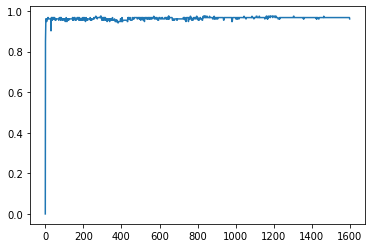

train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3176 Acc: 0.9608

Epoch 1601/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.3191 Acc: 0.9608

Epoch 1602/4999
----------
train Loss: 0.0232 Acc: 0.9836
val Loss: 0.3175 Acc: 0.9608

Epoch 1603/4999
----------
train Loss: 0.0054 Acc: 0.9959
val Loss: 0.3138 Acc: 0.9608

Epoch 1604/4999
----------
train Loss: 0.0157 Acc: 0.9918
val Loss: 0.3011 Acc: 0.9673

Epoch 1605/4999
----------
train Loss: 0.0061 Acc: 0.9959
val Loss: 0.2961 Acc: 0.9673

Epoch 1606/4999
----------
train Loss: 0.0091 Acc: 0.9959
val Loss: 0.2944 Acc: 0.9673

Epoch 1607/4999
----------
train Loss: 0.0163 Acc: 0.9918
val Loss: 0.2843 Acc: 0.9739

Epoch 1608/4999
----------
train Loss: 0.0087 Acc: 0.9959
val Loss: 0.2796 Acc: 0.9739

Epoch 1609/4999
----------
train Loss: 0.0330 Acc: 0.9877
val Loss: 0.2722 Acc: 0.9739

Epoch 1610/4999
----------
train Loss: 0.0059 Acc: 1.0000
val Loss: 0.2665 Acc: 0.9673

Epoch 1611/4999
----------
train Loss: 0.0018 Acc: 1.0000
v

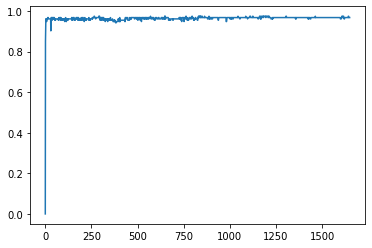

train Loss: 0.0056 Acc: 0.9959
val Loss: 0.2929 Acc: 0.9673

Epoch 1651/4999
----------
train Loss: 0.0293 Acc: 0.9877
val Loss: 0.2865 Acc: 0.9673

Epoch 1652/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.2831 Acc: 0.9673

Epoch 1653/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.2820 Acc: 0.9673

Epoch 1654/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.2823 Acc: 0.9673

Epoch 1655/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.2851 Acc: 0.9673

Epoch 1656/4999
----------
train Loss: 0.0088 Acc: 0.9959
val Loss: 0.2881 Acc: 0.9673

Epoch 1657/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.2901 Acc: 0.9673

Epoch 1658/4999
----------
train Loss: 0.0078 Acc: 0.9959
val Loss: 0.2923 Acc: 0.9673

Epoch 1659/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.2956 Acc: 0.9673

Epoch 1660/4999
----------
train Loss: 0.0108 Acc: 0.9959
val Loss: 0.2972 Acc: 0.9673

Epoch 1661/4999
----------
train Loss: 0.0057 Acc: 1.0000
v

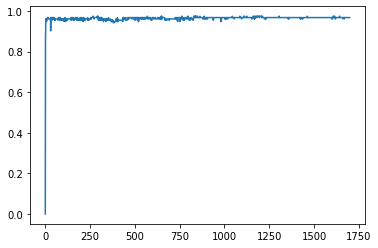

train Loss: 0.0047 Acc: 1.0000
val Loss: 0.2905 Acc: 0.9673

Epoch 1701/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.2907 Acc: 0.9673

Epoch 1702/4999
----------
train Loss: 0.0204 Acc: 0.9877
val Loss: 0.2924 Acc: 0.9673

Epoch 1703/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.2936 Acc: 0.9673

Epoch 1704/4999
----------
train Loss: 0.0050 Acc: 0.9959
val Loss: 0.2955 Acc: 0.9673

Epoch 1705/4999
----------
train Loss: 0.0112 Acc: 0.9959
val Loss: 0.2989 Acc: 0.9673

Epoch 1706/4999
----------
train Loss: 0.0280 Acc: 0.9918
val Loss: 0.3016 Acc: 0.9673

Epoch 1707/4999
----------
train Loss: 0.0048 Acc: 1.0000
val Loss: 0.3049 Acc: 0.9673

Epoch 1708/4999
----------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.3064 Acc: 0.9673

Epoch 1709/4999
----------
train Loss: 0.0124 Acc: 0.9959
val Loss: 0.3069 Acc: 0.9673

Epoch 1710/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.3065 Acc: 0.9673

Epoch 1711/4999
----------
train Loss: 0.0157 Acc: 0.9959
v

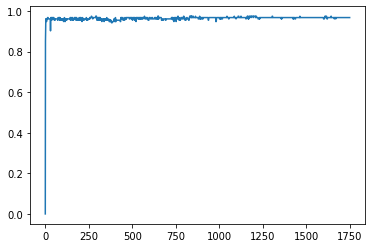

train Loss: 0.0048 Acc: 0.9959
val Loss: 0.2909 Acc: 0.9673

Epoch 1751/4999
----------
train Loss: 0.0073 Acc: 0.9959
val Loss: 0.2929 Acc: 0.9673

Epoch 1752/4999
----------
train Loss: 0.0096 Acc: 0.9959
val Loss: 0.2972 Acc: 0.9673

Epoch 1753/4999
----------
train Loss: 0.0100 Acc: 0.9959
val Loss: 0.3020 Acc: 0.9673

Epoch 1754/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.3046 Acc: 0.9673

Epoch 1755/4999
----------
train Loss: 0.0287 Acc: 0.9959
val Loss: 0.3043 Acc: 0.9673

Epoch 1756/4999
----------
train Loss: 0.0052 Acc: 0.9959
val Loss: 0.3100 Acc: 0.9673

Epoch 1757/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.3108 Acc: 0.9673

Epoch 1758/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.3129 Acc: 0.9673

Epoch 1759/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.3126 Acc: 0.9673

Epoch 1760/4999
----------
train Loss: 0.0103 Acc: 0.9959
val Loss: 0.3118 Acc: 0.9673

Epoch 1761/4999
----------
train Loss: 0.0173 Acc: 0.9959
v

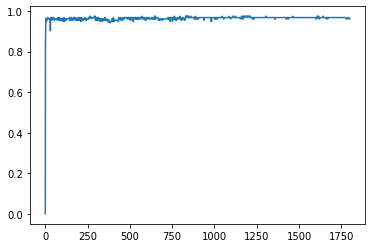

train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3286 Acc: 0.9608

Epoch 1801/4999
----------
train Loss: 0.0155 Acc: 0.9959
val Loss: 0.3277 Acc: 0.9608

Epoch 1802/4999
----------
train Loss: 0.0036 Acc: 1.0000
val Loss: 0.3257 Acc: 0.9608

Epoch 1803/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.3247 Acc: 0.9608

Epoch 1804/4999
----------
train Loss: 0.0097 Acc: 0.9959
val Loss: 0.3277 Acc: 0.9608

Epoch 1805/4999
----------
train Loss: 0.0086 Acc: 0.9959
val Loss: 0.3303 Acc: 0.9608

Epoch 1806/4999
----------
train Loss: 0.0154 Acc: 0.9959
val Loss: 0.3296 Acc: 0.9608

Epoch 1807/4999
----------
train Loss: 0.0158 Acc: 0.9959
val Loss: 0.3264 Acc: 0.9608

Epoch 1808/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.3262 Acc: 0.9608

Epoch 1809/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3285 Acc: 0.9608

Epoch 1810/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3295 Acc: 0.9608

Epoch 1811/4999
----------
train Loss: 0.0134 Acc: 0.9959
v

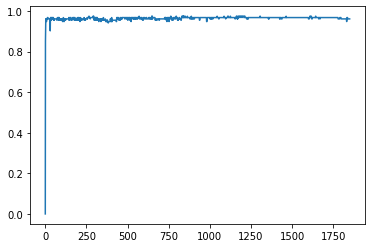

train Loss: 0.0044 Acc: 1.0000
val Loss: 0.3176 Acc: 0.9673

Epoch 1851/4999
----------
train Loss: 0.0137 Acc: 0.9959
val Loss: 0.3193 Acc: 0.9673

Epoch 1852/4999
----------
train Loss: 0.0225 Acc: 0.9877
val Loss: 0.3177 Acc: 0.9673

Epoch 1853/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.3214 Acc: 0.9673

Epoch 1854/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.3247 Acc: 0.9673

Epoch 1855/4999
----------
train Loss: 0.0070 Acc: 1.0000
val Loss: 0.3272 Acc: 0.9673

Epoch 1856/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3274 Acc: 0.9673

Epoch 1857/4999
----------
train Loss: 0.0059 Acc: 0.9959
val Loss: 0.3223 Acc: 0.9673

Epoch 1858/4999
----------
train Loss: 0.0042 Acc: 1.0000
val Loss: 0.3224 Acc: 0.9608

Epoch 1859/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3232 Acc: 0.9673

Epoch 1860/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.3236 Acc: 0.9673

Epoch 1861/4999
----------
train Loss: 0.0388 Acc: 0.9918
v

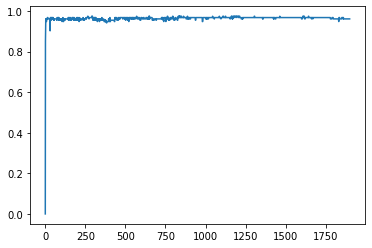

train Loss: 0.0244 Acc: 0.9918
val Loss: 0.3405 Acc: 0.9608

Epoch 1901/4999
----------
train Loss: 0.0070 Acc: 0.9959
val Loss: 0.3375 Acc: 0.9608

Epoch 1902/4999
----------
train Loss: 0.0160 Acc: 0.9918
val Loss: 0.3358 Acc: 0.9608

Epoch 1903/4999
----------
train Loss: 0.0115 Acc: 0.9918
val Loss: 0.3381 Acc: 0.9608

Epoch 1904/4999
----------
train Loss: 0.0079 Acc: 0.9959
val Loss: 0.3390 Acc: 0.9608

Epoch 1905/4999
----------
train Loss: 0.0091 Acc: 0.9959
val Loss: 0.3320 Acc: 0.9608

Epoch 1906/4999
----------
train Loss: 0.0131 Acc: 0.9918
val Loss: 0.3265 Acc: 0.9608

Epoch 1907/4999
----------
train Loss: 0.0099 Acc: 0.9959
val Loss: 0.3251 Acc: 0.9608

Epoch 1908/4999
----------
train Loss: 0.0241 Acc: 0.9918
val Loss: 0.3283 Acc: 0.9608

Epoch 1909/4999
----------
train Loss: 0.0257 Acc: 0.9877
val Loss: 0.3319 Acc: 0.9608

Epoch 1910/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.3373 Acc: 0.9608

Epoch 1911/4999
----------
train Loss: 0.0084 Acc: 0.9959
v

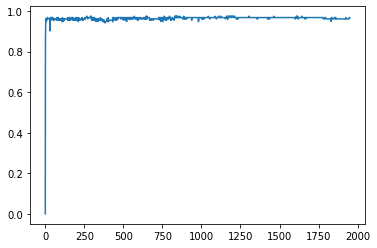

train Loss: 0.0104 Acc: 0.9959
val Loss: 0.3166 Acc: 0.9673

Epoch 1951/4999
----------
train Loss: 0.0377 Acc: 0.9877
val Loss: 0.3074 Acc: 0.9673

Epoch 1952/4999
----------
train Loss: 0.0093 Acc: 0.9959
val Loss: 0.2999 Acc: 0.9608

Epoch 1953/4999
----------
train Loss: 0.0311 Acc: 0.9877
val Loss: 0.2974 Acc: 0.9608

Epoch 1954/4999
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.2961 Acc: 0.9673

Epoch 1955/4999
----------
train Loss: 0.0096 Acc: 0.9959
val Loss: 0.2909 Acc: 0.9673

Epoch 1956/4999
----------
train Loss: 0.0082 Acc: 0.9959
val Loss: 0.2753 Acc: 0.9673

Epoch 1957/4999
----------
train Loss: 0.0054 Acc: 0.9959
val Loss: 0.2757 Acc: 0.9673

Epoch 1958/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.2757 Acc: 0.9673

Epoch 1959/4999
----------
train Loss: 0.0222 Acc: 0.9918
val Loss: 0.2802 Acc: 0.9673

Epoch 1960/4999
----------
train Loss: 0.0253 Acc: 0.9877
val Loss: 0.2802 Acc: 0.9673

Epoch 1961/4999
----------
train Loss: 0.0072 Acc: 0.9959
v

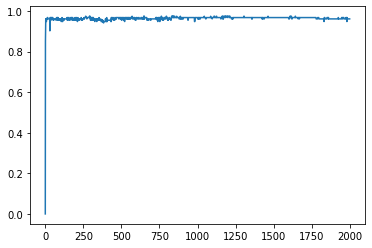

train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3472 Acc: 0.9608

Epoch 2001/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.3471 Acc: 0.9608

Epoch 2002/4999
----------
train Loss: 0.0049 Acc: 1.0000
val Loss: 0.3461 Acc: 0.9608

Epoch 2003/4999
----------
train Loss: 0.0050 Acc: 1.0000
val Loss: 0.3464 Acc: 0.9608

Epoch 2004/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3468 Acc: 0.9608

Epoch 2005/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3475 Acc: 0.9608

Epoch 2006/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.3485 Acc: 0.9608

Epoch 2007/4999
----------
train Loss: 0.0115 Acc: 0.9918
val Loss: 0.3455 Acc: 0.9608

Epoch 2008/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.3433 Acc: 0.9608

Epoch 2009/4999
----------
train Loss: 0.0085 Acc: 1.0000
val Loss: 0.3429 Acc: 0.9608

Epoch 2010/4999
----------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.3436 Acc: 0.9608

Epoch 2011/4999
----------
train Loss: 0.0025 Acc: 1.0000
v

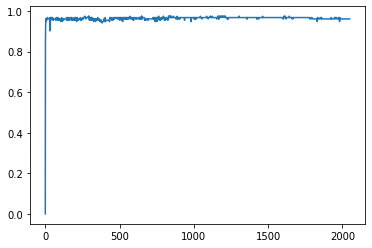

train Loss: 0.0097 Acc: 0.9959
val Loss: 0.3553 Acc: 0.9608

Epoch 2051/4999
----------
train Loss: 0.0078 Acc: 0.9959
val Loss: 0.3535 Acc: 0.9608

Epoch 2052/4999
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3544 Acc: 0.9608

Epoch 2053/4999
----------
train Loss: 0.0072 Acc: 1.0000
val Loss: 0.3586 Acc: 0.9608

Epoch 2054/4999
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.3604 Acc: 0.9608

Epoch 2055/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.3614 Acc: 0.9608

Epoch 2056/4999
----------
train Loss: 0.0041 Acc: 1.0000
val Loss: 0.3617 Acc: 0.9608

Epoch 2057/4999
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.3618 Acc: 0.9608

Epoch 2058/4999
----------
train Loss: 0.0001 Acc: 1.0000
val Loss: 0.3597 Acc: 0.9608

Epoch 2059/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.3602 Acc: 0.9608

Epoch 2060/4999
----------
train Loss: 0.0104 Acc: 0.9918
val Loss: 0.3612 Acc: 0.9608

Epoch 2061/4999
----------
train Loss: 0.0140 Acc: 0.9959
v

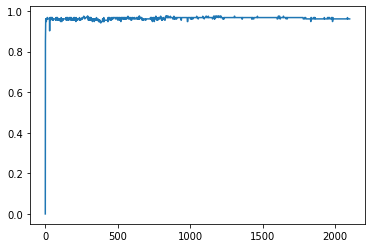

train Loss: 0.0089 Acc: 0.9959
val Loss: 0.3540 Acc: 0.9608

Epoch 2101/4999
----------
train Loss: 0.0113 Acc: 0.9959
val Loss: 0.3516 Acc: 0.9608

Epoch 2102/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3516 Acc: 0.9608

Epoch 2103/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.3543 Acc: 0.9608

Epoch 2104/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3552 Acc: 0.9608

Epoch 2105/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.3560 Acc: 0.9608

Epoch 2106/4999
----------
train Loss: 0.0024 Acc: 1.0000
val Loss: 0.3578 Acc: 0.9608

Epoch 2107/4999
----------
train Loss: 0.0056 Acc: 0.9959
val Loss: 0.3605 Acc: 0.9608

Epoch 2108/4999
----------
train Loss: 0.0209 Acc: 0.9959
val Loss: 0.3618 Acc: 0.9608

Epoch 2109/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.3633 Acc: 0.9608

Epoch 2110/4999
----------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.3642 Acc: 0.9608

Epoch 2111/4999
----------
train Loss: 0.0076 Acc: 0.9959
v

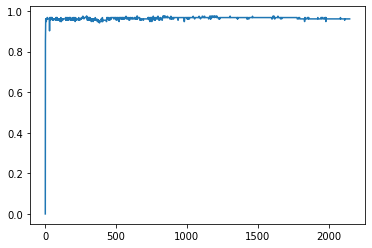

train Loss: 0.0114 Acc: 0.9959
val Loss: 0.3652 Acc: 0.9608

Epoch 2151/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.3668 Acc: 0.9608

Epoch 2152/4999
----------
train Loss: 0.0112 Acc: 0.9918
val Loss: 0.3688 Acc: 0.9608

Epoch 2153/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3693 Acc: 0.9608

Epoch 2154/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.3703 Acc: 0.9608

Epoch 2155/4999
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.3706 Acc: 0.9608

Epoch 2156/4999
----------
train Loss: 0.0177 Acc: 0.9918
val Loss: 0.3681 Acc: 0.9608

Epoch 2157/4999
----------
train Loss: 0.0110 Acc: 0.9918
val Loss: 0.3656 Acc: 0.9608

Epoch 2158/4999
----------
train Loss: 0.0049 Acc: 1.0000
val Loss: 0.3627 Acc: 0.9608

Epoch 2159/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3607 Acc: 0.9608

Epoch 2160/4999
----------
train Loss: 0.0178 Acc: 0.9918
val Loss: 0.3603 Acc: 0.9608

Epoch 2161/4999
----------
train Loss: 0.0009 Acc: 1.0000
v

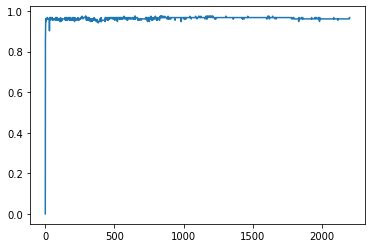

train Loss: 0.0045 Acc: 0.9959
val Loss: 0.3544 Acc: 0.9673

Epoch 2201/4999
----------
train Loss: 0.0070 Acc: 1.0000
val Loss: 0.3520 Acc: 0.9673

Epoch 2202/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3503 Acc: 0.9673

Epoch 2203/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.3506 Acc: 0.9673

Epoch 2204/4999
----------
train Loss: 0.0028 Acc: 1.0000
val Loss: 0.3506 Acc: 0.9673

Epoch 2205/4999
----------
train Loss: 0.0089 Acc: 0.9959
val Loss: 0.3477 Acc: 0.9673

Epoch 2206/4999
----------
train Loss: 0.0022 Acc: 1.0000
val Loss: 0.3431 Acc: 0.9673

Epoch 2207/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.3436 Acc: 0.9608

Epoch 2208/4999
----------
train Loss: 0.0074 Acc: 0.9959
val Loss: 0.3439 Acc: 0.9608

Epoch 2209/4999
----------
train Loss: 0.0030 Acc: 1.0000
val Loss: 0.3431 Acc: 0.9608

Epoch 2210/4999
----------
train Loss: 0.0093 Acc: 0.9959
val Loss: 0.3433 Acc: 0.9608

Epoch 2211/4999
----------
train Loss: 0.0019 Acc: 1.0000
v

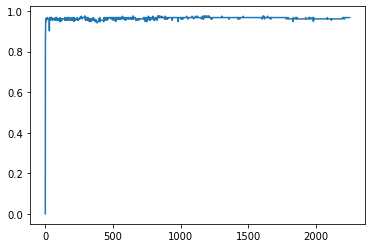

train Loss: 0.0020 Acc: 1.0000
val Loss: 0.3533 Acc: 0.9673

Epoch 2251/4999
----------
train Loss: 0.0054 Acc: 1.0000
val Loss: 0.3508 Acc: 0.9673

Epoch 2252/4999
----------
train Loss: 0.0044 Acc: 1.0000
val Loss: 0.3516 Acc: 0.9673

Epoch 2253/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.3532 Acc: 0.9673

Epoch 2254/4999
----------
train Loss: 0.0038 Acc: 1.0000
val Loss: 0.3597 Acc: 0.9673

Epoch 2255/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.3651 Acc: 0.9673

Epoch 2256/4999
----------
train Loss: 0.0039 Acc: 1.0000
val Loss: 0.3672 Acc: 0.9673

Epoch 2257/4999
----------
train Loss: 0.0058 Acc: 0.9959
val Loss: 0.3689 Acc: 0.9673

Epoch 2258/4999
----------
train Loss: 0.0067 Acc: 0.9959
val Loss: 0.3675 Acc: 0.9608

Epoch 2259/4999
----------
train Loss: 0.0149 Acc: 0.9959
val Loss: 0.3662 Acc: 0.9673

Epoch 2260/4999
----------
train Loss: 0.0055 Acc: 0.9959
val Loss: 0.3669 Acc: 0.9673

Epoch 2261/4999
----------
train Loss: 0.0041 Acc: 1.0000
v

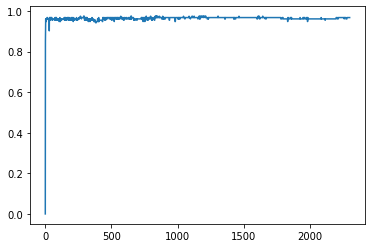

train Loss: 0.0067 Acc: 1.0000
val Loss: 0.3594 Acc: 0.9673

Epoch 2301/4999
----------
train Loss: 0.0086 Acc: 0.9959
val Loss: 0.3612 Acc: 0.9673

Epoch 2302/4999
----------
train Loss: 0.0062 Acc: 0.9959
val Loss: 0.3634 Acc: 0.9608

Epoch 2303/4999
----------
train Loss: 0.0049 Acc: 0.9959
val Loss: 0.3665 Acc: 0.9673

Epoch 2304/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.3690 Acc: 0.9673

Epoch 2305/4999
----------
train Loss: 0.0094 Acc: 0.9918
val Loss: 0.3686 Acc: 0.9673

Epoch 2306/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.3690 Acc: 0.9673

Epoch 2307/4999
----------
train Loss: 0.0099 Acc: 0.9959
val Loss: 0.3711 Acc: 0.9673

Epoch 2308/4999
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.3723 Acc: 0.9673

Epoch 2309/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.3780 Acc: 0.9673

Epoch 2310/4999
----------
train Loss: 0.0052 Acc: 0.9959
val Loss: 0.3798 Acc: 0.9673

Epoch 2311/4999
----------
train Loss: 0.0070 Acc: 0.9959
v

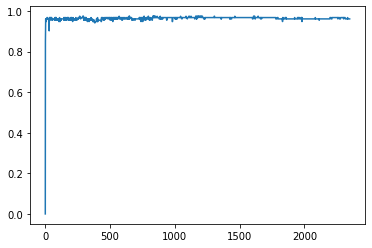

train Loss: 0.0019 Acc: 1.0000
val Loss: 0.3830 Acc: 0.9608

Epoch 2351/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3816 Acc: 0.9608

Epoch 2352/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3824 Acc: 0.9608

Epoch 2353/4999
----------
train Loss: 0.0113 Acc: 0.9959
val Loss: 0.3817 Acc: 0.9608

Epoch 2354/4999
----------
train Loss: 0.0031 Acc: 1.0000
val Loss: 0.3821 Acc: 0.9608

Epoch 2355/4999
----------
train Loss: 0.0342 Acc: 0.9959
val Loss: 0.3813 Acc: 0.9608

Epoch 2356/4999
----------
train Loss: 0.0054 Acc: 0.9959
val Loss: 0.3828 Acc: 0.9608

Epoch 2357/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3823 Acc: 0.9608

Epoch 2358/4999
----------
train Loss: 0.0394 Acc: 0.9877
val Loss: 0.3802 Acc: 0.9608

Epoch 2359/4999
----------
train Loss: 0.0075 Acc: 0.9959
val Loss: 0.3796 Acc: 0.9608

Epoch 2360/4999
----------
train Loss: 0.0384 Acc: 0.9959
val Loss: 0.3805 Acc: 0.9608

Epoch 2361/4999
----------
train Loss: 0.0007 Acc: 1.0000
v

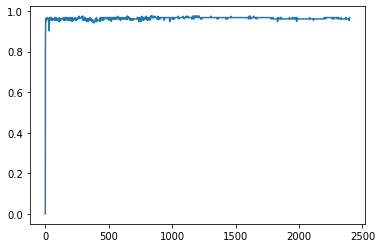

train Loss: 0.0013 Acc: 1.0000
val Loss: 0.3403 Acc: 0.9673

Epoch 2401/4999
----------
train Loss: 0.0053 Acc: 0.9959
val Loss: 0.3396 Acc: 0.9673

Epoch 2402/4999
----------
train Loss: 0.0054 Acc: 0.9959
val Loss: 0.3420 Acc: 0.9673

Epoch 2403/4999
----------
train Loss: 0.0132 Acc: 0.9918
val Loss: 0.3383 Acc: 0.9673

Epoch 2404/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3371 Acc: 0.9673

Epoch 2405/4999
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.3375 Acc: 0.9673

Epoch 2406/4999
----------
train Loss: 0.0112 Acc: 0.9959
val Loss: 0.3406 Acc: 0.9673

Epoch 2407/4999
----------
train Loss: 0.0090 Acc: 0.9959
val Loss: 0.3421 Acc: 0.9673

Epoch 2408/4999
----------
train Loss: 0.0099 Acc: 0.9959
val Loss: 0.3422 Acc: 0.9673

Epoch 2409/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3429 Acc: 0.9673

Epoch 2410/4999
----------
train Loss: 0.0113 Acc: 0.9959
val Loss: 0.3434 Acc: 0.9673

Epoch 2411/4999
----------
train Loss: 0.0210 Acc: 0.9918
v

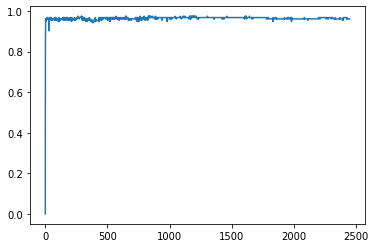

train Loss: 0.0056 Acc: 0.9959
val Loss: 0.3487 Acc: 0.9608

Epoch 2451/4999
----------
train Loss: 0.0122 Acc: 0.9959
val Loss: 0.3431 Acc: 0.9608

Epoch 2452/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.3418 Acc: 0.9673

Epoch 2453/4999
----------
train Loss: 0.0246 Acc: 0.9959
val Loss: 0.3398 Acc: 0.9673

Epoch 2454/4999
----------
train Loss: 0.0054 Acc: 0.9959
val Loss: 0.3364 Acc: 0.9673

Epoch 2455/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.3352 Acc: 0.9673

Epoch 2456/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.3343 Acc: 0.9673

Epoch 2457/4999
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.3334 Acc: 0.9608

Epoch 2458/4999
----------
train Loss: 0.0273 Acc: 0.9959
val Loss: 0.3307 Acc: 0.9673

Epoch 2459/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.3268 Acc: 0.9673

Epoch 2460/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3256 Acc: 0.9673

Epoch 2461/4999
----------
train Loss: 0.0107 Acc: 0.9959
v

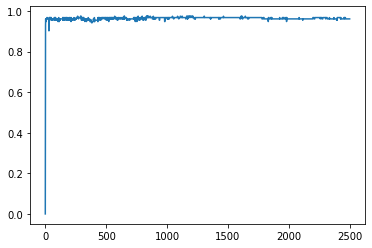

train Loss: 0.0111 Acc: 0.9959
val Loss: 0.3430 Acc: 0.9608

Epoch 2501/4999
----------
train Loss: 0.0027 Acc: 1.0000
val Loss: 0.3431 Acc: 0.9608

Epoch 2502/4999
----------
train Loss: 0.0131 Acc: 0.9959
val Loss: 0.3429 Acc: 0.9608

Epoch 2503/4999
----------
train Loss: 0.0038 Acc: 1.0000
val Loss: 0.3430 Acc: 0.9608

Epoch 2504/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3469 Acc: 0.9608

Epoch 2505/4999
----------
train Loss: 0.0114 Acc: 0.9918
val Loss: 0.3460 Acc: 0.9608

Epoch 2506/4999
----------
train Loss: 0.0049 Acc: 0.9959
val Loss: 0.3444 Acc: 0.9608

Epoch 2507/4999
----------
train Loss: 0.0398 Acc: 0.9877
val Loss: 0.3484 Acc: 0.9673

Epoch 2508/4999
----------
train Loss: 0.0132 Acc: 0.9959
val Loss: 0.3545 Acc: 0.9608

Epoch 2509/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3563 Acc: 0.9608

Epoch 2510/4999
----------
train Loss: 0.0055 Acc: 0.9959
val Loss: 0.3565 Acc: 0.9608

Epoch 2511/4999
----------
train Loss: 0.0002 Acc: 1.0000
v

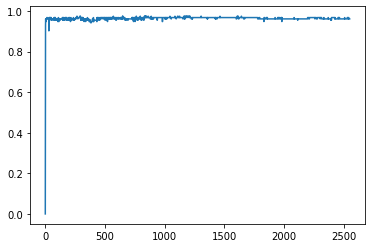

train Loss: 0.0036 Acc: 0.9959
val Loss: 0.3641 Acc: 0.9608

Epoch 2551/4999
----------
train Loss: 0.0064 Acc: 0.9959
val Loss: 0.3549 Acc: 0.9608

Epoch 2552/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.3510 Acc: 0.9608

Epoch 2553/4999
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.3497 Acc: 0.9608

Epoch 2554/4999
----------
train Loss: 0.0033 Acc: 1.0000
val Loss: 0.3499 Acc: 0.9673

Epoch 2555/4999
----------
train Loss: 0.0097 Acc: 0.9959
val Loss: 0.3497 Acc: 0.9673

Epoch 2556/4999
----------
train Loss: 0.0138 Acc: 0.9959
val Loss: 0.3515 Acc: 0.9673

Epoch 2557/4999
----------
train Loss: 0.0034 Acc: 1.0000
val Loss: 0.3534 Acc: 0.9673

Epoch 2558/4999
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3541 Acc: 0.9673

Epoch 2559/4999
----------
train Loss: 0.0106 Acc: 0.9918
val Loss: 0.3495 Acc: 0.9673

Epoch 2560/4999
----------
train Loss: 0.0023 Acc: 1.0000
val Loss: 0.3476 Acc: 0.9673

Epoch 2561/4999
----------
train Loss: 0.0027 Acc: 1.0000
v

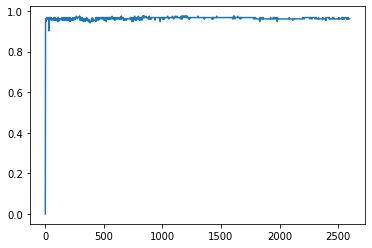

train Loss: 0.0028 Acc: 1.0000
val Loss: 0.3690 Acc: 0.9608

Epoch 2601/4999
----------
train Loss: 0.0121 Acc: 0.9959
val Loss: 0.3707 Acc: 0.9608

Epoch 2602/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.3724 Acc: 0.9608

Epoch 2603/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.3744 Acc: 0.9608

Epoch 2604/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.3748 Acc: 0.9608

Epoch 2605/4999
----------
train Loss: 0.0052 Acc: 0.9959
val Loss: 0.3746 Acc: 0.9608

Epoch 2606/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.3758 Acc: 0.9608

Epoch 2607/4999
----------
train Loss: 0.0049 Acc: 0.9959
val Loss: 0.3803 Acc: 0.9608

Epoch 2608/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.3844 Acc: 0.9608

Epoch 2609/4999
----------
train Loss: 0.0086 Acc: 0.9959
val Loss: 0.3840 Acc: 0.9608

Epoch 2610/4999
----------
train Loss: 0.0091 Acc: 0.9959
val Loss: 0.3831 Acc: 0.9608

Epoch 2611/4999
----------
train Loss: 0.0104 Acc: 0.9959
v

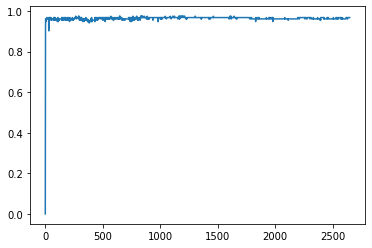

train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3688 Acc: 0.9673

Epoch 2651/4999
----------
train Loss: 0.0058 Acc: 0.9959
val Loss: 0.3631 Acc: 0.9673

Epoch 2652/4999
----------
train Loss: 0.0062 Acc: 0.9959
val Loss: 0.3600 Acc: 0.9673

Epoch 2653/4999
----------
train Loss: 0.0327 Acc: 0.9877
val Loss: 0.3626 Acc: 0.9673

Epoch 2654/4999
----------
train Loss: 0.0025 Acc: 1.0000
val Loss: 0.3655 Acc: 0.9673

Epoch 2655/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.3635 Acc: 0.9673

Epoch 2656/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3613 Acc: 0.9673

Epoch 2657/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.3620 Acc: 0.9673

Epoch 2658/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3629 Acc: 0.9673

Epoch 2659/4999
----------
train Loss: 0.0118 Acc: 0.9959
val Loss: 0.3624 Acc: 0.9673

Epoch 2660/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.3619 Acc: 0.9673

Epoch 2661/4999
----------
train Loss: 0.0070 Acc: 0.9959
v

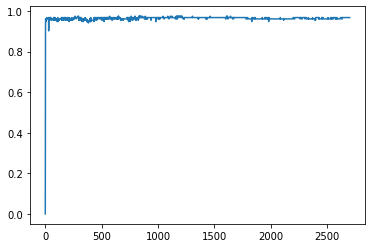

train Loss: 0.0003 Acc: 1.0000
val Loss: 0.3702 Acc: 0.9673

Epoch 2701/4999
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.3731 Acc: 0.9673

Epoch 2702/4999
----------
train Loss: 0.0043 Acc: 0.9959
val Loss: 0.3711 Acc: 0.9673

Epoch 2703/4999
----------
train Loss: 0.0022 Acc: 1.0000
val Loss: 0.3711 Acc: 0.9673

Epoch 2704/4999
----------
train Loss: 0.0054 Acc: 0.9959
val Loss: 0.3723 Acc: 0.9673

Epoch 2705/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.3741 Acc: 0.9673

Epoch 2706/4999
----------
train Loss: 0.0052 Acc: 0.9959
val Loss: 0.3760 Acc: 0.9673

Epoch 2707/4999
----------
train Loss: 0.0062 Acc: 0.9959
val Loss: 0.3807 Acc: 0.9673

Epoch 2708/4999
----------
train Loss: 0.0036 Acc: 1.0000
val Loss: 0.3829 Acc: 0.9673

Epoch 2709/4999
----------
train Loss: 0.0074 Acc: 0.9959
val Loss: 0.3860 Acc: 0.9673

Epoch 2710/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.3873 Acc: 0.9673

Epoch 2711/4999
----------
train Loss: 0.0019 Acc: 1.0000
v

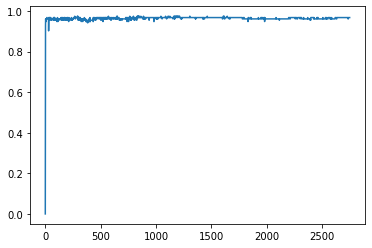

train Loss: 0.0185 Acc: 0.9959
val Loss: 0.3831 Acc: 0.9673

Epoch 2751/4999
----------
train Loss: 0.0030 Acc: 1.0000
val Loss: 0.3829 Acc: 0.9673

Epoch 2752/4999
----------
train Loss: 0.0071 Acc: 0.9918
val Loss: 0.3798 Acc: 0.9673

Epoch 2753/4999
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.3775 Acc: 0.9673

Epoch 2754/4999
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3782 Acc: 0.9673

Epoch 2755/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.3789 Acc: 0.9673

Epoch 2756/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3785 Acc: 0.9673

Epoch 2757/4999
----------
train Loss: 0.0030 Acc: 1.0000
val Loss: 0.3787 Acc: 0.9673

Epoch 2758/4999
----------
train Loss: 0.0065 Acc: 0.9959
val Loss: 0.3829 Acc: 0.9673

Epoch 2759/4999
----------
train Loss: 0.0042 Acc: 1.0000
val Loss: 0.3855 Acc: 0.9673

Epoch 2760/4999
----------
train Loss: 0.0008 Acc: 1.0000
val Loss: 0.3861 Acc: 0.9673

Epoch 2761/4999
----------
train Loss: 0.0046 Acc: 0.9959
v

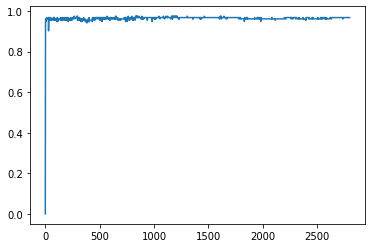

train Loss: 0.0008 Acc: 1.0000
val Loss: 0.4166 Acc: 0.9673

Epoch 2801/4999
----------
train Loss: 0.0158 Acc: 0.9959
val Loss: 0.4143 Acc: 0.9673

Epoch 2802/4999
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.4116 Acc: 0.9673

Epoch 2803/4999
----------
train Loss: 0.0187 Acc: 0.9918
val Loss: 0.4127 Acc: 0.9673

Epoch 2804/4999
----------
train Loss: 0.0035 Acc: 1.0000
val Loss: 0.4137 Acc: 0.9673

Epoch 2805/4999
----------
train Loss: 0.0079 Acc: 0.9959
val Loss: 0.4167 Acc: 0.9673

Epoch 2806/4999
----------
train Loss: 0.0048 Acc: 0.9959
val Loss: 0.4186 Acc: 0.9673

Epoch 2807/4999
----------
train Loss: 0.0005 Acc: 1.0000
val Loss: 0.4202 Acc: 0.9673

Epoch 2808/4999
----------
train Loss: 0.0047 Acc: 1.0000
val Loss: 0.4217 Acc: 0.9673

Epoch 2809/4999
----------
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.4212 Acc: 0.9673

Epoch 2810/4999
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.4211 Acc: 0.9673

Epoch 2811/4999
----------
train Loss: 0.0043 Acc: 0.9959
v

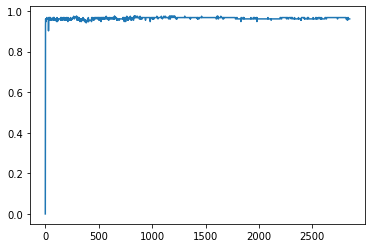

train Loss: 0.0088 Acc: 0.9959
val Loss: 0.3789 Acc: 0.9673

Epoch 2851/4999
----------
train Loss: 0.0035 Acc: 1.0000
val Loss: 0.3789 Acc: 0.9673

Epoch 2852/4999
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.3788 Acc: 0.9673

Epoch 2853/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.3790 Acc: 0.9673

Epoch 2854/4999
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.3793 Acc: 0.9673

Epoch 2855/4999
----------
train Loss: 0.0043 Acc: 0.9959
val Loss: 0.3789 Acc: 0.9608

Epoch 2856/4999
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.3810 Acc: 0.9608

Epoch 2857/4999
----------
train Loss: 0.0016 Acc: 1.0000
val Loss: 0.3834 Acc: 0.9608

Epoch 2858/4999
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.3846 Acc: 0.9608

Epoch 2859/4999
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.3852 Acc: 0.9608

Epoch 2860/4999
----------
train Loss: 0.0285 Acc: 0.9959
val Loss: 0.3862 Acc: 0.9608

Epoch 2861/4999
----------
train Loss: 0.0175 Acc: 0.9918
v

In [ ]:
# Initialize the non-pretrained version of the model used for this run

# scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)

# ============= For fair comparison, should use pretrained, and only update the last few layers ===========
if model_name == "alexnet":
    scratch_model = models.alexnet(pretrained=True)
elif model_name == "vgg":
    scratch_model = models.vgg19(pretrained=True)
    
for param in scratch_model.features.parameters():
    param.requires_grad = False
    
for name, param in scratch_model.named_parameters():
    print("\t",name, param.requires_grad)
    
    
print(scratch_model)

scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [22]:

if model_name == "alexnet":
    torch.save(scratch_model.state_dict()['classifier.1.weight'], 'ant_bee_Alexnet_ScratchModel_acc9085_weight.pt')
    torch.save(scratch_model.state_dict()['classifier.1.bias'], 'ant_bee_Alexnet_ScratchModel_acc9085_bias.pt')
elif model_name == "vgg":
    torch.save(scratch_model.state_dict()['classifier.weight'], 'ant_bee_VGG19_ScratchModel_acc_weight.pt')
    torch.save(scratch_model.state_dict()['classifier.bias'], 'ant_bee_VGG19_ScratchModel_acc_bias.pt')

KeyError: 'classifier.weight'

In [23]:
scratch_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Epoch 0/14
----------
train Loss: 0.6933 Acc: 0.5123
val Loss: 0.6941 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.6938 Acc: 0.4508
val Loss: 0.6922 Acc: 0.5425

Epoch 2/14
----------
train Loss: 0.6934 Acc: 0.4754
val Loss: 0.6928 Acc: 0.5817

Epoch 3/14
----------
train Loss: 0.6930 Acc: 0.5082
val Loss: 0.6926 Acc: 0.6275

Epoch 4/14
----------
train Loss: 0.6930 Acc: 0.5410
val Loss: 0.6925 Acc: 0.6013

Epoch 5/14
----------
train Loss: 0.6929 Acc: 0.5246
val Loss: 0.6912 Acc: 0.5425

Epoch 6/14
----------
train Loss: 0.6924 Acc: 0.5082
val Loss: 0.6913 Acc: 0.5817

Epoch 7/14
----------
train Loss: 0.6925 Acc: 0.5082
val Loss: 0.6904 Acc: 0.5425

Epoch 8/14
----------
train Loss: 0.6918 Acc: 0.5246
val Loss: 0.6910 Acc: 0.6601

Epoch 9/14
----------
train Loss: 0.6918 Acc: 0.5656
val Loss: 0.6904 Acc: 0.6471

Epoch 10/14
----------
train Loss: 0.6912 Acc: 0.5328
val Loss: 0.6892 Acc: 0.6405

Epoch 11/14
----------
train Loss: 0.6908 Acc: 0.5820
val Loss: 0.6898 Acc: 0.6144

Ep

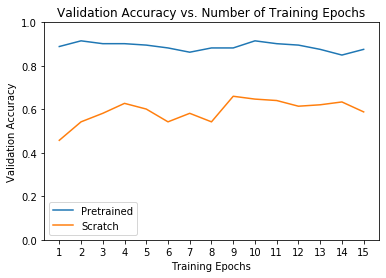

In [26]:
# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
model_ft.featuresshist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

Final Thoughts and Where to Go Next
-----------------------------------

Try running some of the other models and see how good the accuracy gets.
Also, notice that feature extracting takes less time because in the
backward pass we do not have to calculate most of the gradients. There
are many places to go from here. You could:

-  Run this code with a harder dataset and see some more benefits of
   transfer learning
-  Using the methods described here, use transfer learning to update a
   different model, perhaps in a new domain (i.e. NLP, audio, etc.)
-  Once you are happy with a model, you can export it as an ONNX model,
   or trace it using the hybrid frontend for more speed and optimization
   opportunities.


